In [1]:
import random
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from copy import copy, deepcopy
from itertools import product
from tqdm.notebook import tqdm
from scipy.spatial import ConvexHull
import scipy.stats as stats


from models.game import *

sns.set_style('ticks',  {"axes.grid" : "True", "grid.color": ".4", "grid.linestyle": ":"})
sns.set_context("paper")
plt.rcParams.update({'mathtext.default':  'regular' })
plt.rcParams['xtick.direction'] = 'out'


In [2]:
def process(list_strategy_profile, game : Game) : 
    data_utilities = []
    data_temp = []
    list_sum_strategy = np.sum(list_strategy_profile, axis=1)
    list_ = list(zip(list_strategy_profile,list_sum_strategy))
    for strategy, sum_ in tqdm(list_, total = len(list_), desc ='Processing'):
        u,temp = game.game_with_strategies_profile(strategy,sum_)
        data_utilities.append(u)
        data_temp.append(temp)
    return np.array(data_utilities), np.array(data_temp)

In [3]:
FIRST_YEAR = 2020
"Year of the first occurence of the game."

FINAL_YEAR = 2100
"Year of the last occurence of the game."

STEP = 5
"Number of years between two occurence of the game."

T = int((FINAL_YEAR - FIRST_YEAR) / STEP) 

horizon = FINAL_YEAR

r = [1.15, 1.60, 2, 0.5, 1.25,0.75]
e = [2, -2, -5, -4, -5, 2.5]

In [4]:
N = 2
"Default number of players"

# Espaces d'action des joueurs en GtCO2


ACTION_SETS =  np.array([[[0.0, 11.47],        # China  
                         [0.0, 5.01]]]*2*T)*4       # other 

ACTION_SETS = np.swapaxes(ACTION_SETS,0,1)


r"""Default action set of the players.

References
----------

.. [1] Hannah Ritchie, Max Roser and Pablo Rosado (2020) - "CO₂ and Greenhouse Gas Emissions". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions' [Online Resource]
       https://ourworldindata.org/grapher/annual-co2-emissions-per-country?facet=none&country=CHN~USA~European+Union+%2828%29~IND~RUS~Asia+%28excl.+China+and+India%29

"""

# ACTION_SETS =  np.array([[[0.0, 10.0],        # China  
#                          [0.0, 0.1],         # USA
#                          [0.0, 0.1],         # EU
#                          [0.0, 0.1],         # India
#                          [0.0, 0.1],         # Russia
#                          [0.0, 0.1]]]*T)  
# Coefficient d'impact de la temperature sur le climat 

DELTAS = np.array([1.1847,
                    1.1941])
r"""Default damage multiplier. 

References
----------

.. [1] http://www.fund-model.org/MimiFUND.jl/latest/tables/#Table-RT:-Regional-temperature-conversion-factor-1
"""



# PIB max des joueurs, j'ai pris le PIB 2020                

GDP_MAX = np.array([14.63,
                    19.29])*10


NAMES = ['China', 'USA']


r = [ 0.2, 0.4]
e = [10,-2]

In [4]:
lower_bounds = np.copy(ACTION_SETS[:,:T,:][..., 0])
upper_bounds = np.copy(ACTION_SETS[:,:T,:][..., 1])

In [5]:
lower_bounds

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [6]:
from ipywidgets import interact

list_benefit_functions=BENEFITS_SIGMOID
case = 'sigmoid'
list_damage_coef = [ np.array([0,0,1.1450]), np.array([0,0,2,0])] #, np.array([0,0,0,0,1])]

def game_two_player(  r , e0, K, indice, indice_damage):
    list_players = create_players(list_benefit_functions=list_benefit_functions,  damage_function=damage_polynome(list_damage_coef[indice_damage]), discount=1)
    player = list_players[indice]
    # print(player.action_set[0])
    x = np.linspace(*player.action_set[0]*4)
    plt.plot(x, player.benefit_shape(player.GDP_max, player.action_set[0,1]*2, r=r , e=e0, K=K)(x))
    plt.plot(x, (x+1)/(x+1) * player.GDP_max)
    # print(player.benefit_shape(player.GDP_max, player.action_set[0,1], r=r , e=e0, K=K)(x) -player.GDP_max )

interact(game_two_player, r=(-1,4,0.01), e0=(-10,10,0.01), K=(-10,10,0.01), indice=(0,N-1,1), indice_damage=(0,len(list_damage_coef)-1,1))

interactive(children=(FloatSlider(value=1.0, description='r', max=4.0, min=-1.0, step=0.01), FloatSlider(value…

<function __main__.game_two_player(r, e0, K, indice, indice_damage)>

In [7]:
from utility.array_to_latex import array_to_latex

X = 2020 + np.arange((horizon-2020)//5 )*5

list_t_piece = np.arange(1,T,2)


list_damage_coef = [np.array([0,0,1]), np.array([0,-2,2])] #, np.array([0,0,2]) ] #np.array([0,-2,2]),  np.array([0,-0.5,1.1])] #, np.array([0,0,1.1450]), np.array([0,0,0,0,1])]
list_alpha = [1,1.5,2] #[1,1.5,2]
list_list_benefit_functions = [
                                [partial(benefit_sigm, e=e[i], r = r[i]) for i in range(N)],
                                # BENEFITS_CONCAVE,
                                ]
 #[partial(benefit_sigm, e=e[i], r = r[i]) for i in range(N)], BENEFITS_LOG]
list_label_benefit_function = [
                                ('Sigmoid', '-'),
                                # ('Concave', '--'),
                                ]
#, #, ('Logaritmic', 'dotted')]
# list_damage_label = [array_to_latex(coef) for coef in list_damage_coef]


list_damage_label = [array_to_latex(coef) for coef in list_damage_coef]

case = 'sigmoid'
list_param = list(product(list_damage_coef, list_alpha, list_list_benefit_functions))
list_label = list(product(list_damage_label, list_alpha, list_label_benefit_function))

In [8]:
list__ = []
ress_ = []
list_ne = []
list_so = []
list_ne_planning = []
list_so_planning = []
list_ne_receding = []
list_so_receding = []


for param in tqdm(list_param):
    damage_coef, alpha, list_benefit_functions = param
    list_players = create_players(alpha=alpha, list_action_sets=ACTION_SETS, list_of_names=NAMES, list_benefit_functions=list_benefit_functions, damage_function=damage_polynome(damage_coef), discount=1)
    list_ = []
    game = Game(list_players, horizon=horizon)

    aa, asum_a, au, asum_u, atemp = game.receding_BRD_by_piece_return(1)
    list_ne.append(( atemp[T-1], np.sum(asum_u)))
    aa, asum_a, au, asum_u, atemp = game.planning_SO_by_piece_return(1)
    list_so.append(( atemp[T-1], np.sum(asum_u)))

    aa, asum_a, au, asum_u, atemp = game.receding_BRD_by_piece_return(T)
    list_ne_receding.append(( atemp[T-1], np.sum(asum_u)))

    aa, asum_a, au, asum_u, atemp = game.planning_BRD_by_piece_return(T)
    list_ne_planning.append(( atemp[T-1], np.sum(asum_u)))

    aa, asum_a, au, asum_u, atemp = game.planning_SO_by_piece_return(T)
    list_so_planning.append(( atemp[T-1], np.sum(asum_u)))

    aa, asum_a, au, asum_u, atemp = game.receding_SO_by_piece_return(T)
    list_so_receding.append(( atemp[T-1], np.sum(asum_u)))

    low_temp = game.scm_game.evaluate_trajectory(np.sum(lower_bounds, axis = 0))[-1][-1]
    up_temp = game.scm_game.evaluate_trajectory(np.sum(upper_bounds, axis = 0))[-1][-1]


    for temp in np.linspace(low_temp,up_temp,25) :
        list_.append(game.planning_social_optimum_with_constraint_temperature(constraint_value=temp))
    list__.append(np.array(list_))
    ress_.append(process(list_, game))

  0%|          | 0/6 [00:00<?, ?it/s]

Receding SO, t_piece = 16: 100%|██████████| 16/16 [00:46<00:00,  2.92s/it]
c:\ProgramData\Anaconda3\envs\CO2\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 6/6 [26:29<00:00, 264.88s/it]


In [12]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
plt.rcdefaults()

sns.set_style('ticks',  {"axes.grid" : "True", "grid.color": ".4", "grid.linestyle": ":"})
sns.set_context("paper")
#
#                       'mathtext.fontset' : 'cm',
#                       "font.family": "Helvetica",
#                       "text.usetex": True})
plt.rcParams['xtick.direction'] = 'out'
mpl.rc('legend' , fontsize= 16)
mpl.rc('axes'   , labelsize=15,  titlesize=14) 
plt.rcParams['font.size'] = '16'
sns.set_style('ticks',  {"axes.grid" : "True", "grid.color": ".4", "grid.linestyle": ":"})
sns.set_context('paper')
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.labelsize']  =15
plt.rcParams['xtick.labelsize']  =15
plt.rcParams['legend.fontsize']  = 16
plt.rcParams['axes.labelsize' ] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["figure.autolayout"] = True

In [13]:
sns.set_style('ticks',  {"axes.grid" : "True", "grid.color": ".4", "grid.linestyle": ":"})
sns.set_context('paper')
plt.rcParams.update({'mathtext.default':  'regular' })
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.labelsize']  =15
plt.rcParams['xtick.labelsize']  =15
plt.rcParams['legend.fontsize']  = 16
plt.rcParams['axes.labelsize' ] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["figure.autolayout"] = True

In [14]:
ne_style = {
    # 'color' : 'black',
    'linewidths' : 1,
            }
so_style = {
    'c' : 'white',
    # 'edgecolors' : 'black',
    'linewidths' : 1,
    'alpha' : 1
            }

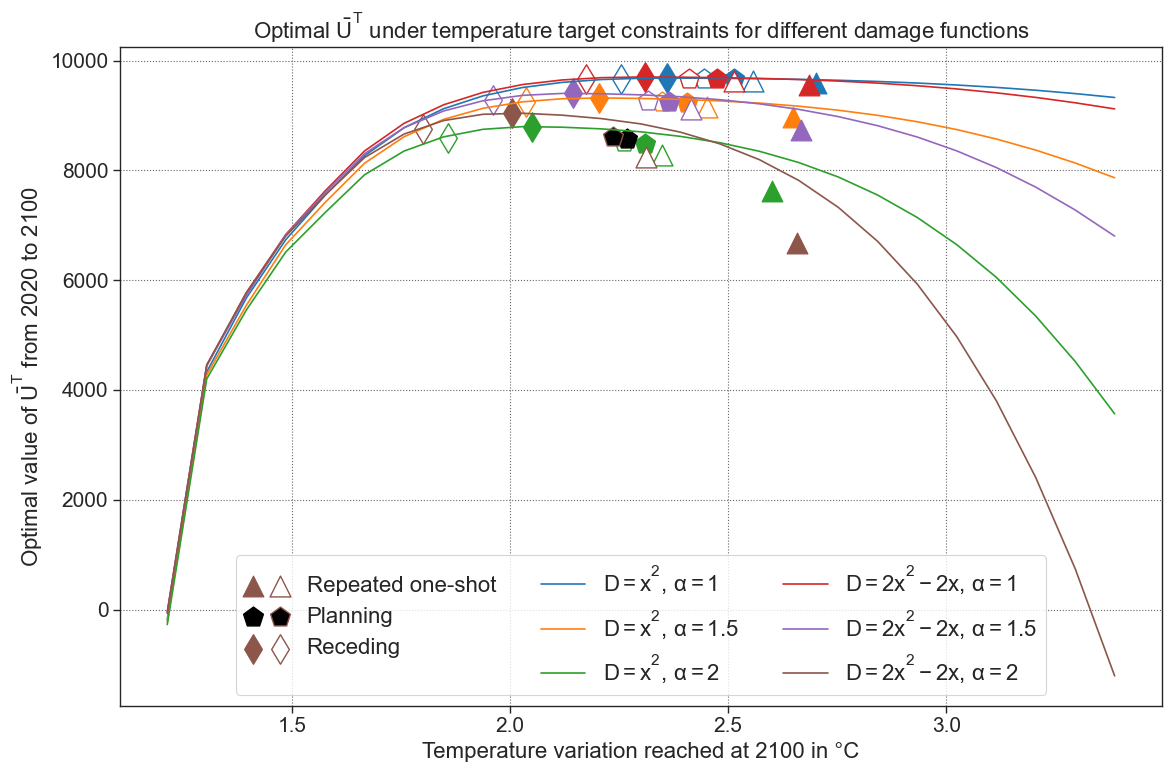

In [78]:
from matplotlib.legend_handler import HandlerTuple
from collections import OrderedDict

plt.rcParams['lines.markersize'] = 15


fig = plt.figure(dpi=100, figsize=(12,8))
ax = fig.gca()
list_p = []
for idx, all in enumerate(zip(ress_, list_ne, list_so, list_ne_planning, list_so_planning, list_ne_receding, list_so_receding )):
    res, ne, so, ne_planning, so_planning, ne_receding, so_receding = all

    p1 = ax.scatter(*ne, marker='^',  label='Repeated one-shot')
    color = p1.get_facecolor()
    p2 = ax.scatter(*so, marker='^', edgecolors=color, **so_style)
    repeated = (p1, p2)


    p1 = ax.scatter(*ne_planning, marker='p', c=color, label='Planning', **ne_style)
    p2 = ax.scatter(*ne_receding, marker='p', edgecolors=color, **so_style)
    planning = (p1, p2)


    p1 = ax.scatter(*so_planning, marker='d', c=color, label='Receding', **ne_style)
    p2 = ax.scatter(*so_receding, marker='d', edgecolors=color,  **so_style)
    receding = (p1, p2)

    p = ax.plot(res[1][:,-1], np.sum(res[0],axis=1), ls =list_label[idx][2][1],  label= r'$D = {},\,  \alpha = {}$'.format(list_label[idx][0],list_label[idx][1]))
    list_p.append(p[-1])
plt.xlabel('Temperature variation reached at {} in °C'.format(FINAL_YEAR))
plt.ylabel(r'Optimal value of $\bar{{U}}^T$ from {} to {}'.format(FIRST_YEAR, FINAL_YEAR))

# new_fig = plt.figure(fig)
# new_ax = new_fig.gca()
handles, labels = ax.get_legend_handles_labels()
# labels = list(OrderedDict.fromkeys(deepcopy(labels)))
# handles = [repeated, planning, receding] + list_p

# by_label = dict(zip(labels, handles))
# by_label['Repeated one-shot'][0].set_facecolor('black')
# by_label['Repeated one-shot'][1].set_edgecolor('black')

# by_label['Planning'][0].set_facecolor('black')
# by_label['Planning'][1].set_edgecolor('black')
# by_label['Receding'][0].set_facecolor('black')
# by_label['Receding'][1].set_edgecolor('black')

# Create a separate legend for modifying the facecolor
legend_fig = plt.figure()
legend_ax = legend_fig.add_subplot(111)

# Create legend handles and labels
handles = [repeated, planning, receding] + list_p
labels = list(OrderedDict.fromkeys(deepcopy(labels)))

# Create a dictionary mapping labels to handles
by_label = dict(zip(labels, handles))

# Set the facecolor of the 'Planning' curve in the legend
by_label['Planning'][0].set_facecolor('black')
by_label['Planning'][1].set_facecolor('black')

# Create the legend
legend_ax.legend(by_label.values(), by_label.keys(), loc="best", ncol=3, handler_map={tuple: HandlerTuple(ndivide=None)})

# Hide the legend axes
legend_ax.axis('off')

# Adjust the layout of the legend
legend_fig.tight_layout()

# Save the modified legend separately
legend_fig.savefig('journal/legend.pdf', format='pdf')

# Close the legend figure
plt.close(legend_fig)

ax.legend(by_label.values(), by_label.keys(), loc="best",  ncol=3, handler_map={tuple: HandlerTuple(ndivide=None)})

plt.title(r'Optimal $\bar{U}^T$ under temperature target constraints for different damage functions')
plt.savefig('journal/duality.pdf', format='pdf')

plt.show()

In [96]:
ne_style_legend = {
    'color' : 'black',
    # 'linewidths' : 1,
            }
so_style_legend = {
    'c' : 'white',
    'markeredgecolor' : 'black',
    # 'linewidths' : 1,
    # 'alpha' : 1
            }

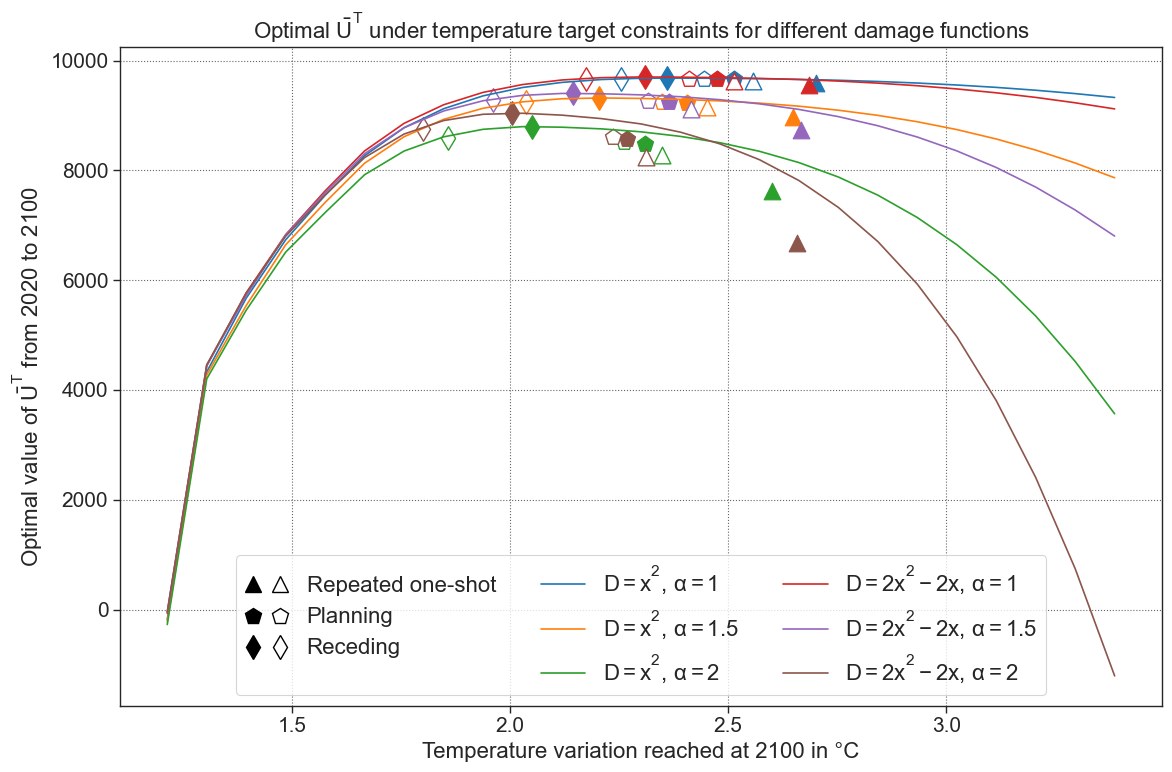

In [100]:
from matplotlib.legend_handler import HandlerTuple
from collections import OrderedDict

plt.rcParams['lines.markersize'] = 12

fig = plt.figure(dpi=100, figsize=(12,8))
ax = fig.gca()
list_p = []
legend_handles = []  # To store the legend handles for custom legend

for idx, all in enumerate(zip(ress_, list_ne, list_so, list_ne_planning, list_so_planning, list_ne_receding, list_so_receding)):
    res, ne, so, ne_planning, so_planning, ne_receding, so_receding = all

    p1 = ax.scatter(*ne, marker='^',  label='Repeated one-shot')
    color = p1.get_facecolor()
    p2 = ax.scatter(*so, marker='^', edgecolors=color, **so_style)
    repeated = (p1, p2)

    p1 = ax.scatter(*ne_planning, marker='p', c=color, label='Planning', **ne_style)
    p2 = ax.scatter(*ne_receding, marker='p', edgecolors=color, **so_style)
    planning = (p1, p2)

    p1 = ax.scatter(*so_planning, marker='d', c=color, label='Receding', **ne_style)
    p2 = ax.scatter(*so_receding, marker='d', edgecolors=color,  **so_style)
    receding = (p1, p2)

    p = ax.plot(res[1][:,-1], np.sum(res[0],axis=1), ls =list_label[idx][2][1],  label= r'$D = {},\,  \alpha = {}$'.format(list_label[idx][0],list_label[idx][1]))
    list_p.append(p[-1])

plt.xlabel('Temperature variation reached at {} in °C'.format(FINAL_YEAR))
plt.ylabel(r'Optimal value of $\bar{{U}}^T$ from {} to {}'.format(FIRST_YEAR, FINAL_YEAR))

new_fig = plt.figure(fig)
new_ax = new_fig.gca()
handles, labels = new_ax.get_legend_handles_labels()

# Append the handles and labels from the plot to the custom legend
legend_handles.extend(handles)
labels.extend(labels)

# Create custom legend handles and labels
repeated_handle = (plt.Line2D([], [], ls= '', marker='^', label='Repeated one-shot', **ne_style_legend), plt.Line2D([], [], ls= '', marker='^', label='Repeated one-shot', **so_style_legend))
planning_handle = (plt.Line2D([], [], ls= '', marker='p', label='Planning', **ne_style_legend), plt.Line2D([], [], ls= '', marker='p', label='Planning', **so_style_legend))
receding_handle = (plt.Line2D([], [], ls= '', marker='d', label='Receding', **ne_style_legend), plt.Line2D([], [], ls= '', marker='d', label='Receding', **so_style_legend))

handles.extend([repeated_handle, planning_handle, receding_handle])
for handle in handles:
    if type(handle) == tuple:
        labels.extend(handle[0].get_label())
    else : 
        labels.extend(handle.get_label())

by_label = dict(zip(labels, handles))


ax.legend(by_label.values(), by_label.keys(), loc="best",  ncol=3, handler_map={tuple: HandlerTuple(ndivide=None)})

# Append the custom legend handles to list_p
list_p.extend(legend_handles)

plt.title(r'Optimal $\bar{U}^T$ under temperature target constraints for different damage functions')
plt.savefig('journal/duality.pdf', format='pdf')

plt.show()


In [86]:
handles

In [49]:
for i in range(len(list_p)):
    print(list_p[i].get_label())

$D = x^{2},\,  \alpha = 1$
$D = x^{2},\,  \alpha = 1.5$
$D = x^{2},\,  \alpha = 2$
$D = 2x^{2}-2x,\,  \alpha = 1$
$D = 2x^{2}-2x,\,  \alpha = 1.5$
$D = 2x^{2}-2x,\,  \alpha = 2$


In [44]:
by_label

{'Repeated one-shot': <matplotlib.lines.Line2D at 0x13644f4d250>,
 'Planning': <matplotlib.lines.Line2D at 0x13644f15910>,
 'Receding': <matplotlib.lines.Line2D at 0x13644f286d0>,
 '$D = x^{2},\\,  \\alpha = 1$': <matplotlib.lines.Line2D at 0x13643798970>,
 '$D = x^{2},\\,  \\alpha = 1.5$': <matplotlib.lines.Line2D at 0x13644f3c490>}

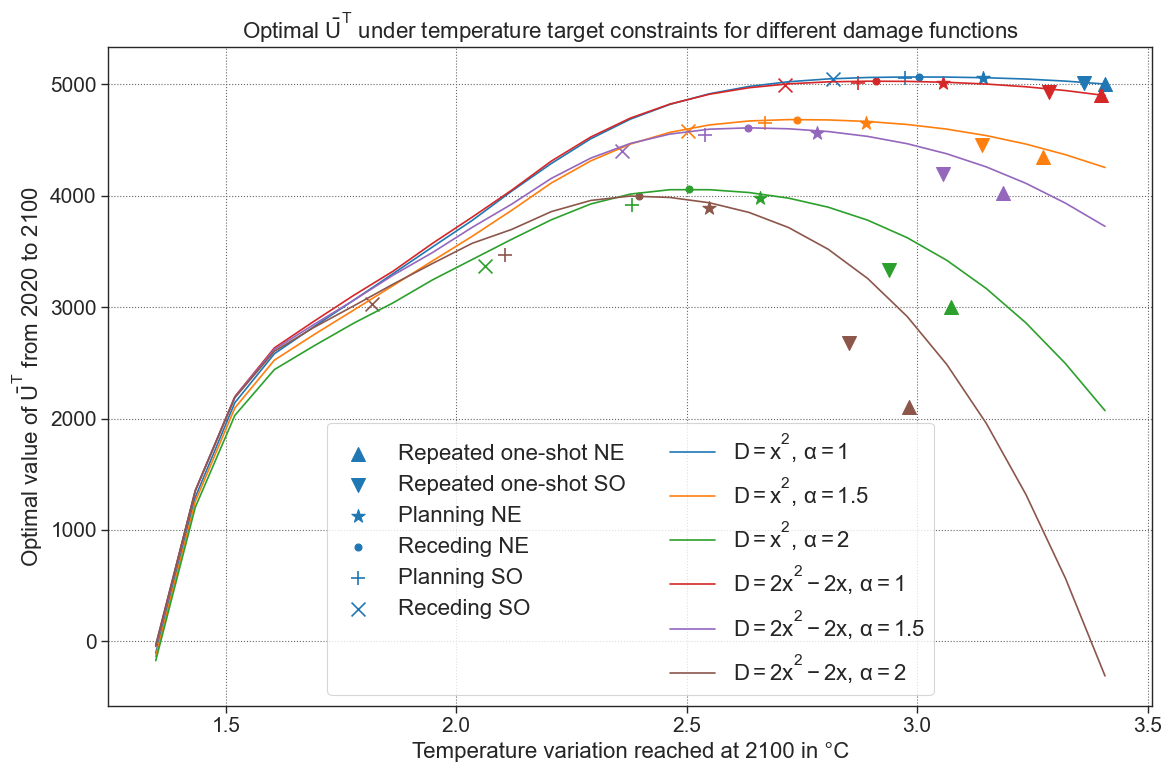

In [ ]:
plt.figure(dpi=100, figsize=(12,8))
for idx, all in enumerate(zip(ress_, list_ne, list_so, list_ne_planning, list_so_planning, list_ne_receding, list_so_receding )):
    res, ne, so, ne_planning, so_planning, ne_receding, so_receding = all
    if idx ==0 :
        p = plt.scatter(*ne, marker='^', s=100, label='Repeated one-shot NE')
        color = p.get_facecolor()
        plt.scatter(*so, marker='v', c=color, s=100, label='Repeated one-shot SO')
        plt.scatter(*ne_planning, marker='*', c=color, s=100, label='Planning NE')
        plt.scatter(*so_planning, marker='.', c=color,s=100, label='Receding NE')
        plt.scatter(*ne_receding, marker='+',c=color, s=100, label='Planning SO')
        plt.scatter(*so_receding, marker='x',c=color, s=100, label='Receding SO')

    else : 
        p = plt.scatter(*ne, marker='^', s=100)
        color = p.get_facecolor()
        plt.scatter(*so, marker='v', c=color, s=100)
        plt.scatter(*ne_planning, marker='*', c=color, s=100)
        plt.scatter(*so_planning, marker='.', c=color,s=100)
        plt.scatter(*ne_receding, marker='+',c=color, s=100)
        plt.scatter(*so_receding, marker='x',c=color, s=100)
    plt.plot(res[1][:,-1], np.sum(res[0],axis=1), ls =list_label[idx][2][1],  label= r'$D = {},\,  \alpha = {}$'.format(list_label[idx][0],list_label[idx][1]))
    plt.xlabel('Temperature variation reached at {} in °C'.format(FINAL_YEAR))
    plt.ylabel(r'Optimal value of $\bar{{U}}^T$ from {} to {}'.format(FIRST_YEAR, FINAL_YEAR))

plt.title(r'Optimal $\bar{U}^T$ under temperature target constraints for different damage functions')
plt.legend(ncol= 2)
plt.savefig('journal/duality.pdf', format='pdf')

plt.show()

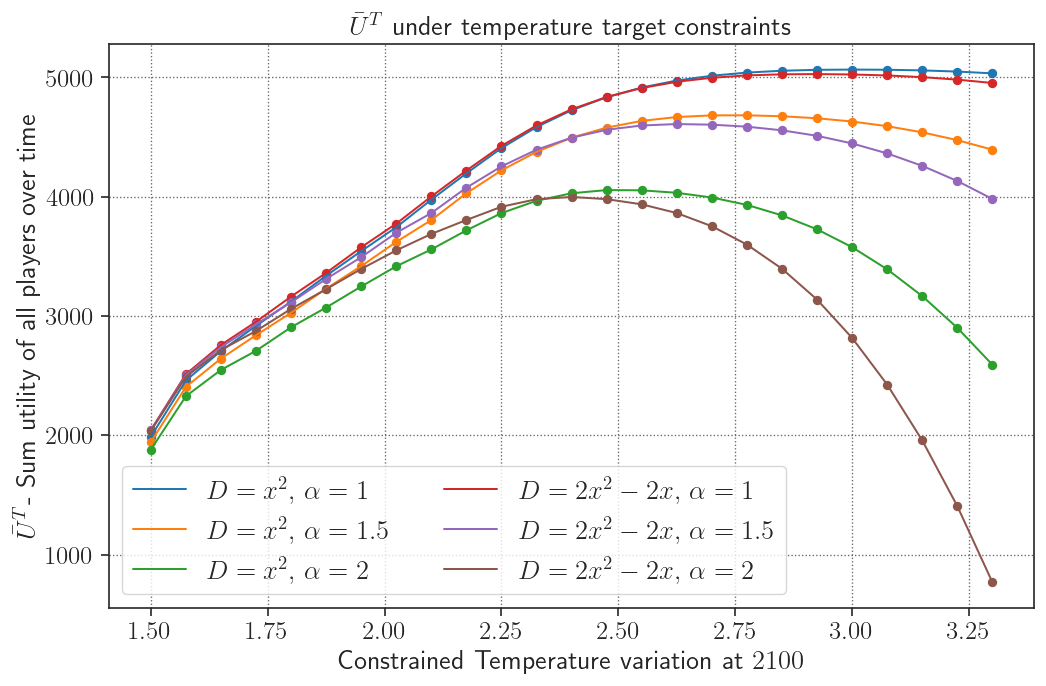

In [ ]:
plt.figure(dpi=120, figsize=FIG_SIZE)
for idx, res in enumerate(ress_):
    # plt.scatter(res[1][:,-1], np.sum(res[0],axis=1))
    p = plt.scatter()
    plt.plot(res[1][:,-1], np.sum(res[0],axis=1), ls =list_label[idx][2][1],  label= r'$D = {},\,  \alpha = {}$'.format(list_label[idx][0],list_label[idx][1]))
    plt.xlabel('Constrained Temperature variation at $2100$')
    plt.ylabel(r'$\bar{U}^T$- Sum utility of all players over time')

plt.title(r'$\bar{U}^T$ under temperature target constraints')
plt.legend(ncol= 2)
plt.savefig('journal/duality.pdf', format='pdf')

plt.show()

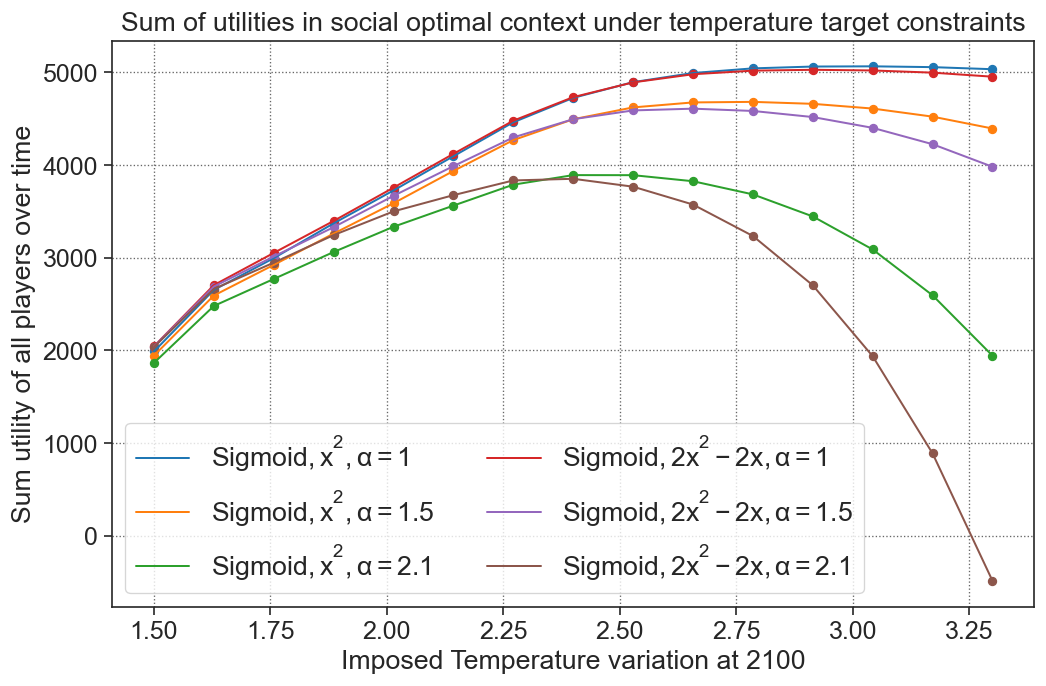

In [ ]:
plt.figure(dpi=120, figsize=FIG_SIZE)
for idx, res in enumerate(ress_):
    plt.scatter(res[1][:,-1], np.sum(res[0],axis=1))
    plt.plot(res[1][:,-1], np.sum(res[0],axis=1), ls =list_label[idx][2][1],  label= r'${}, {}, \alpha = {}$'.format(list_label[idx][2][0],list_label[idx][0],list_label[idx][1]))
    plt.xlabel('Imposed Temperature variation at 2100')
    plt.ylabel('Sum utility of all players over time')

plt.title('Sum of utilities in social optimal context under temperature target constraints')
plt.legend(ncol= 2)
plt.savefig('journal/scm.pdf', format='pdf')

plt.show()

In [8]:
list_players = create_players(alpha=2, list_action_sets=ACTION_SETS, list_of_names=NAMES, list_benefit_functions=list_list_benefit_functions[0], damage_function=damage_polynome(list_damage_coef[0]), discount=1)

game = Game(list_players, horizon=horizon)


In [9]:
actions, utilities, temp = game.pareto_front(nb_points=10)

(2, 2)
[[-231.18024873 2779.16482359]
 [1656.50950731 -909.41207733]]


Player 0:  10%|█         | 1/10 [00:00<00:02,  3.19it/s]

Player 1: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


In [38]:
utilities[:,1]

array([ 2723.99139562,  2726.76142585,  2699.76028182,  2655.27703882,
        2591.60893679,  2506.1399145 ,  2392.32933899,  2248.33668199,
        2248.33101841,  2248.33101841,  2248.33101841,  2248.33505559,
        1881.32992555,  1459.99919024,  1038.66845583,   617.33771985,
         196.00698572,  -225.32374982,  -646.65448394, -1067.98521871])

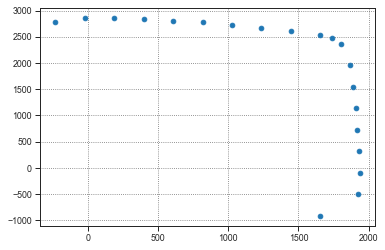

In [10]:
plt.scatter(utilities[:,0], utilities[:,1])

In [23]:
from utility.array_to_latex import array_to_latex

X = 2020 + np.arange((horizon-2020)//5 )*5

list_t_piece = np.arange(1,T,2)


list_damage_coef = [np.array([0,0,1])] #, np.array([0,0,2]) ] #np.array([0,-2,2]),  np.array([0,-0.5,1.1])] #, np.array([0,0,1.1450]), np.array([0,0,0,0,1])]
list_list_benefit_functions = [
                                #[partial(benefit_sigm, e=e[i], r = r[i]) for i in range(N)],
                                BENEFITS_CONCAVE,
                                ]
 #[partial(benefit_sigm, e=e[i], r = r[i]) for i in range(N)], BENEFITS_LOG]
list_label_benefit_function = [
                                #('Sigmoid', '-'),
                                ('log', '-'),
                                ]
#, #, ('Logaritmic', 'dotted')]
# list_damage_label = [array_to_latex(coef) for coef in list_damage_coef]




list_alpha = [1,3]


list_damage_label = [array_to_latex(coef) for coef in list_damage_coef]

case = 'sigmoid'
list_param = list(product(list_damage_coef, list_alpha, list_list_benefit_functions))
list_label = list(product(list_damage_label, list_alpha, list_label_benefit_function))    

list__ = []
ress_ = []

for param, label in zip(list_param,list_label):
    damage_coef, alpha, list_benefit_functions = param
    list_players = create_players(alpha=alpha, list_action_sets=ACTION_SETS, list_of_names=NAMES, list_benefit_functions=list_benefit_functions, damage_function=damage_polynome(damage_coef), discount=1)
    list_ = []
    game = Game(list_players, horizon=horizon)
    for temp in tqdm(np.linspace(1.5,3.3,20), leave=False) :
        list_.append(game.planning_social_optimum_with_constraint_temperature(constraint_value=temp))
    list__.append(np.array(list_))
    ress_.append(process(list_, game))


print('fin')

list_alpha = [1,1.5] #[1,1.5,2]


list_damage_label = [array_to_latex(coef) for coef in list_damage_coef]

case = 'sigmoid'
list_param = list(product(list_damage_coef, list_alpha, list_list_benefit_functions))
list_label = list(product(list_damage_label, list_alpha, list_label_benefit_function))

ress = []
liste = []
for param, label in tqdm(zip(list_param,list_label), total=len(list_param), desc='Over all'):
    damage_coef, alpha, list_benefit_functions = param
    list_players = create_players(alpha=alpha, list_action_sets=ACTION_SETS, list_of_names=NAMES, list_benefit_functions=list_benefit_functions, damage_function=damage_polynome(damage_coef), discount=1)
    list_ = []
    game = Game(list_players, horizon=horizon)
    for temp in tqdm(np.linspace(1.5,3.3,20), leave=False) :
        list_.append(game.planning_social_optimum_with_constraint_temperature(constraint_value=temp))
    liste.append(np.array(list_))
    ress.append(process(list_, game))


(20, 16)


Processing: 100%|██████████| 20/20 [00:00<00:00, 2074.23it/s]


(20, 16)


Processing: 100%|██████████| 20/20 [00:00<00:00, 2972.36it/s]


fin


Over all:   0%|          | 0/2 [00:00<?, ?it/s]

(20, 16)


Over all:  50%|█████     | 1/2 [00:03<00:03,  3.14s/it]

(20, 16)


Over all: 100%|██████████| 2/2 [00:06<00:00,  3.42s/it]


In [24]:
ress[0][0]

array([[ -52.38905028,  933.08444191],
       [ -56.4069856 , 1466.42727148],
       [ -60.64579382, 1931.84919967],
       [ -65.10926802, 2322.00509803],
       [ -67.54335133, 2626.76436461],
       [ 136.97275708, 2672.75454113],
       [ 348.9853191 , 2701.46152767],
       [ 557.36407556, 2725.65469974],
       [ 759.01545508, 2748.23608681],
       [ 952.60084193, 2769.35778743],
       [1136.99518745, 2788.85393937],
       [1310.98899483, 2806.5455281 ],
       [1473.28369015, 2822.23870508],
       [1622.47942952, 2835.73027553],
       [1757.07850141, 2846.79719399],
       [1875.4739614 , 2855.20038662],
       [1975.93604003, 2860.6903523 ],
       [2056.62087143, 2862.98995112],
       [2115.54456229, 2861.81134666],
       [2150.58330495, 2856.84635709]])

In [25]:
ress_[0][0]

array([[ -52.38905028,  933.08444191],
       [ -56.4069856 , 1466.42727148],
       [ -60.64579382, 1931.84919967],
       [ -65.10926802, 2322.00509803],
       [ -67.54335133, 2626.76436461],
       [ 136.97275708, 2672.75454113],
       [ 348.9853191 , 2701.46152767],
       [ 557.36407556, 2725.65469974],
       [ 759.01545508, 2748.23608681],
       [ 952.60084193, 2769.35778743],
       [1136.99518745, 2788.85393937],
       [1310.98899483, 2806.5455281 ],
       [1473.28369015, 2822.23870508],
       [1622.47942952, 2835.73027553],
       [1757.07850141, 2846.79719399],
       [1875.4739614 , 2855.20038662],
       [1975.93604003, 2860.6903523 ],
       [2056.62087143, 2862.98995112],
       [2115.54456229, 2861.81134666],
       [2150.58330495, 2856.84635709]])

In [26]:
ress = []

for l in liste :
    ress.append(process(l, game))

(20, 16)


Processing: 100%|██████████| 20/20 [00:00<00:00, 1038.50it/s]


(20, 16)


Processing: 100%|██████████| 20/20 [00:00<00:00, 2306.02it/s]


In [55]:
np.sum(res[0], axis = 1)

array([ 833.9543421 , 1352.22599059, 1800.77409726, 2172.12685824,
       2458.27528503, 2689.00858374, 2908.89245999, 3119.37052791,
       3319.21642835, 3507.0911107 , 3681.56076536, 3841.0909131 ,
       3984.04013671, 4108.65343042, 4213.05514633, 4295.24150898,
       4353.07268133, 4384.26434533, 4386.3759988 , 4354.16383891])

In [54]:
ress[0][1][:,-1]

array([1.5       , 1.59473684, 1.68947368, 1.78421053, 1.87894737,
       1.97368421, 2.06842105, 2.16315789, 2.25789474, 2.35263158,
       2.44736842, 2.54210526, 2.63684211, 2.73157895, 2.82631579,
       2.92105263, 3.01578947, 3.11052632, 3.20526316, 3.3       ])

In [17]:
list_label_benefit_function

[('Sigmoid', '-'), ('log', '-')]

In [38]:
list_label

[('x^{2}', 1, ('Sigmoid', '-')),
 ('x^{2}', 1, ('log', '-')),
 ('x^{2}', 1.5, ('Sigmoid', '-')),
 ('x^{2}', 1.5, ('log', '-')),
 ('x^{2}', 2, ('Sigmoid', '-')),
 ('x^{2}', 2, ('log', '-'))]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[[ -72.54634923  906.29568581]
 [ -81.32587195 1433.31043523]
 [ -91.00726781 1891.49924388]
 [-101.64715414 2273.44678066]
 [-111.06427506 2568.92569218]
 [  84.03238439 2602.39755851]
 [ 286.5452162  2618.47954226]
 [ 485.14720513 2629.67953297]
 [ 676.09586863 2638.03716665]
 [ 857.9122145  2643.51798359]
 [1029.41125092 2645.87645796]
 [1189.31890759 2644.84775798]
 [1336.27465086 2640.15569156]
 [1468.8118283  2631.50827633]
 [1585.3681748  2618.5966761 ]
 [1684.26795711 2601.09039764]
 [1763.71362062 2578.64985437]
 [1821.79153601 2550.90519176]
 [1856.44728942 2517.47485263]
 [1865.48507971 2477.95497686]]
[[ -72.20654704  906.16088914]
 [ -80.93828664 1433.16427724]
 [ -90.56760859 1891.34170585]
 [-101.15095832 2273.27781656]
 [-112.74617815 2571.02146318]
 [  78.70838224 2610.30020149]
 [ 283.90728132 2624.98517867]
 [ 482.72172717 2636.64880074]
 [ 673.51516585 2645.70126249]
 [ 855.17405537 2651.91705534]
 [1026.5026723  2655.05809306]
 [1186.23739617 2654.85351693]
 [1333.

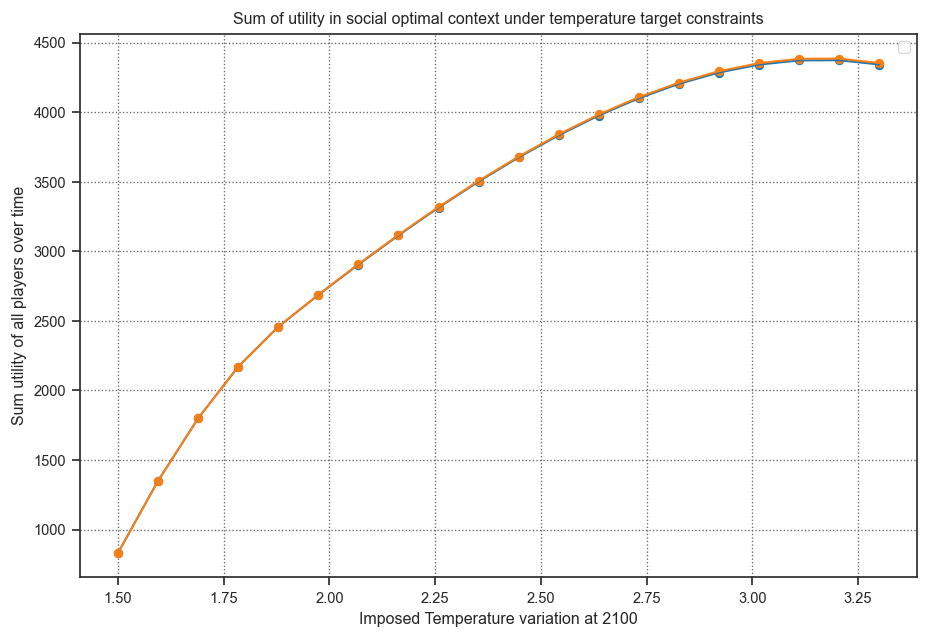

In [41]:
plt.figure(dpi=120, figsize=FIG_SIZE)
for idx, res in enumerate(ress):
    print(res[0])
    plt.scatter(res[1][:,-1], np.sum(res[0],axis=1))#, label= r'${}, {}, \alpha = {}$'.format(list_label[idx][2][0],list_label[idx][0],list_label[idx][1]))
    plt.plot(res[1][:,-1], np.sum(res[0],axis=1))
    plt.xlabel('Imposed Temperature variation at 2100')
    plt.ylabel('Sum utility of all players over time')

plt.title('Sum of utility in social optimal context under temperature target constraints')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


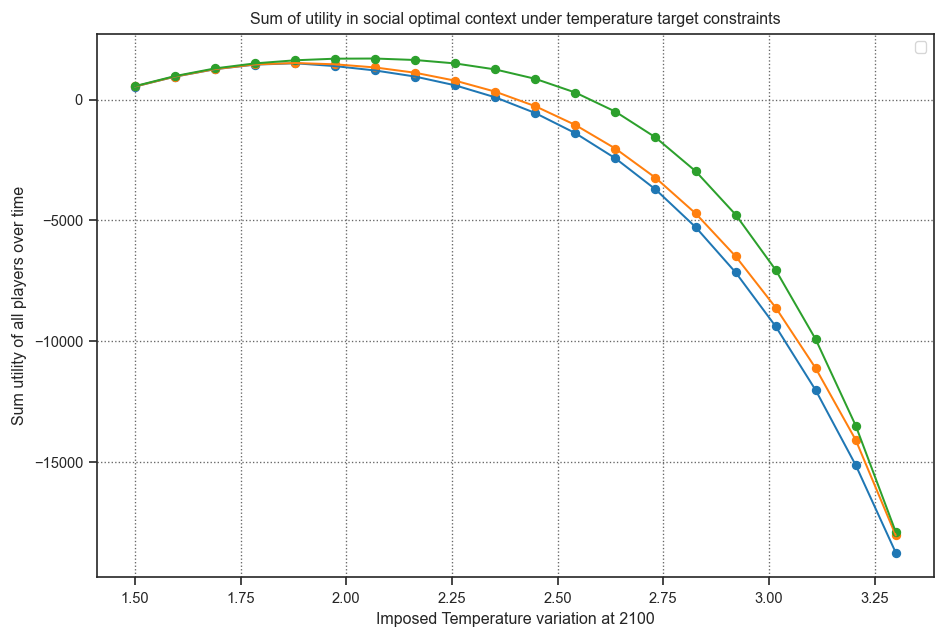

In [ ]:
plt.figure(dpi=120, figsize=FIG_SIZE)
for idx, res in enumerate(ress):
    plt.scatter(res[1][:,-1], np.sum(res[0],axis=1))#, label= r'${}, {}, \alpha = {}$'.format(list_label[idx][2][0],list_label[idx][0],list_label[idx][1]))
    plt.plot(res[1][:,-1], np.sum(res[0],axis=1))
    plt.xlabel('Imposed Temperature variation at 2100')
    plt.ylabel('Sum utility of all players over time')

plt.title('Sum of utility in social optimal context under temperature target constraints')
plt.legend()
plt.show()

[[-100.89668328  868.61850565]
 [-117.99588984 1384.57651666]
 [-137.7315535  1829.40335016]
 [-160.40204525 2195.36238792]
 [-184.12609202 2471.8276038 ]
 [  -9.2440047  2478.43459881]
 [ 171.76074933 2465.9326611 ]
 [ 347.12947657 2446.25598613]
 [ 511.55713749 2419.36759447]
 [ 663.02565495 2384.51659038]
 [ 799.97125517 2340.95405236]
 [ 920.71078783 2287.87148725]
 [1023.46068792 2224.43050044]
 [1106.29869944 2149.7336191 ]
 [1167.19231586 2062.84706299]
 [1203.96252835 1962.77149304]
 [1214.29042481 1848.47444616]
 [1195.71204222 1718.85468237]
 [1145.59929158 1572.76823858]
 [1061.15510026 1409.01217365]]
[[-100.27028087  868.86459648]
 [-117.25464409 1384.90036825]
 [-136.85952739 1829.82042142]
 [-159.38180458 2195.88987179]
 [-185.1387922  2474.8127357 ]
 [ -10.05913324 2492.32946901]
 [ 176.21040935 2481.85760769]
 [ 353.18435005 2464.4955172 ]
 [ 518.81598468 2440.1083086 ]
 [ 671.64005036 2408.00304142]
 [ 810.08917401 2367.44771246]
 [ 932.50334219 2317.64466254]
 [1037.

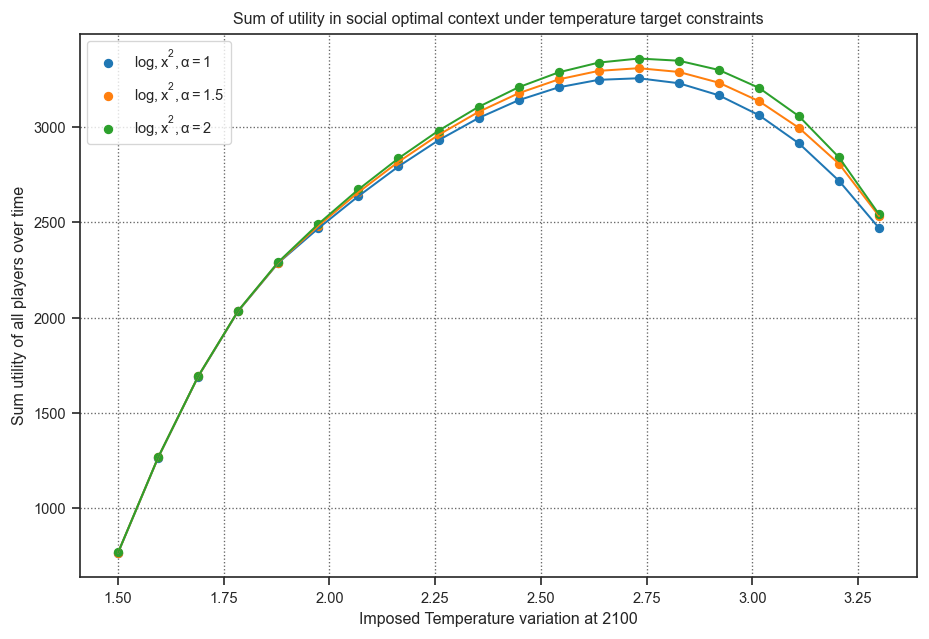

In [ ]:
plt.figure(dpi=120, figsize=FIG_SIZE)
for idx, res in enumerate(ress):
    print(res[0])
    plt.scatter(res[1][:,-1], np.sum(res[0],axis=1), label= r'${}, {}, \alpha = {}$'.format(list_label[idx][2][0],list_label[idx][0],list_label[idx][1]))
    plt.plot(res[1][:,-1], np.sum(res[0],axis=1))
    plt.xlabel('Imposed Temperature variation at 2100')
    plt.ylabel('Sum utility of all players over time')

plt.title('Sum of utility in social optimal context under temperature target constraints')
plt.legend()
plt.show()

[[  -197.403239      740.36270163]
 [  -252.5442149    1205.76375643]
 [  -322.51563503   1583.8280028 ]
 [  -410.66470059   1862.76697164]
 [  -518.95447505   2026.84556969]
 [  -472.82737492   1862.33906595]
 [  -441.58106722   1650.81033885]
 [  -441.5573786    1398.10266677]
 [  -492.00583106   1085.64705662]
 [  -603.71713752    701.03390775]
 [  -786.84436174    232.09925761]
 [ -1052.87443848   -334.99447335]
 [ -1414.5924852   -1015.7065824 ]
 [ -1886.37941324  -1827.49191347]
 [ -2484.14057941  -2789.72106234]
 [ -3225.64183562  -3924.10805504]
 [ -4130.47245147  -5254.63740772]
 [ -5220.32328339  -6807.96262107]
 [ -6519.05136326  -8613.44061342]
 [ -8052.90241386 -10703.43723973]]
[[  -195.59609673    742.17797852]
 [  -250.2352463    1208.17108881]
 [  -319.58339109   1586.98307347]
 [  -406.96346594   1866.85745738]
 [  -516.27748566   2034.73424519]
 [  -447.15847259   1911.43082664]
 [  -392.16292461   1726.49774247]
 [  -378.10037764   1492.62878746]
 [  -413.90495536  

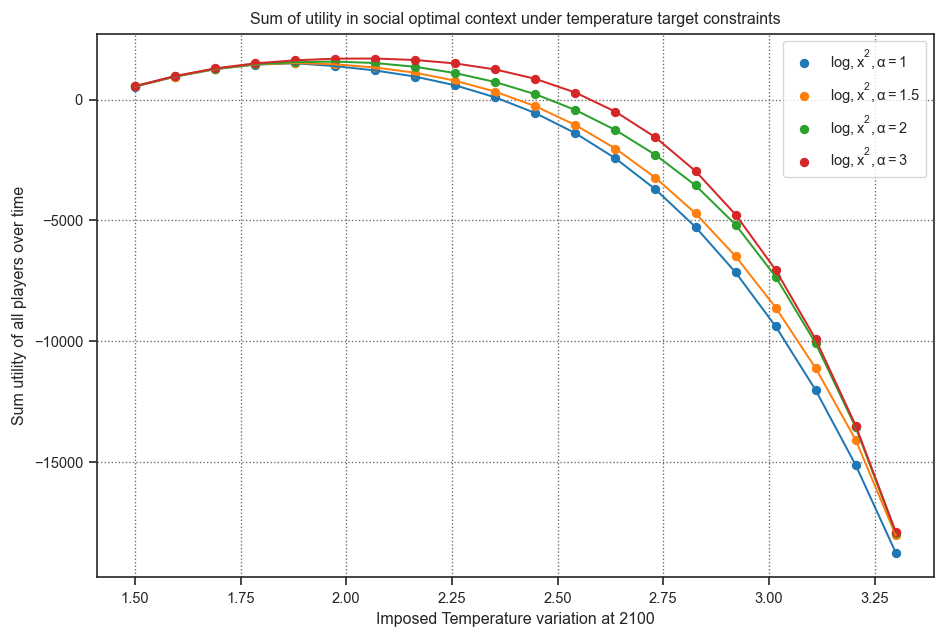

In [ ]:
plt.figure(dpi=120, figsize=FIG_SIZE)
for idx, res in enumerate(ress):
    print(res[0])
    plt.scatter(res[1][:,-1], np.sum(res[0],axis=1), label= r'${}, {}, \alpha = {}$'.format(list_label[idx][2][0],list_label[idx][0],list_label[idx][1]))
    plt.plot(res[1][:,-1], np.sum(res[0],axis=1))
    plt.xlabel('Imposed Temperature variation at 2100')
    plt.ylabel('Sum utility of all players over time')

plt.title('Sum of utility in social optimal context under temperature target constraints')
plt.legend()
plt.show()

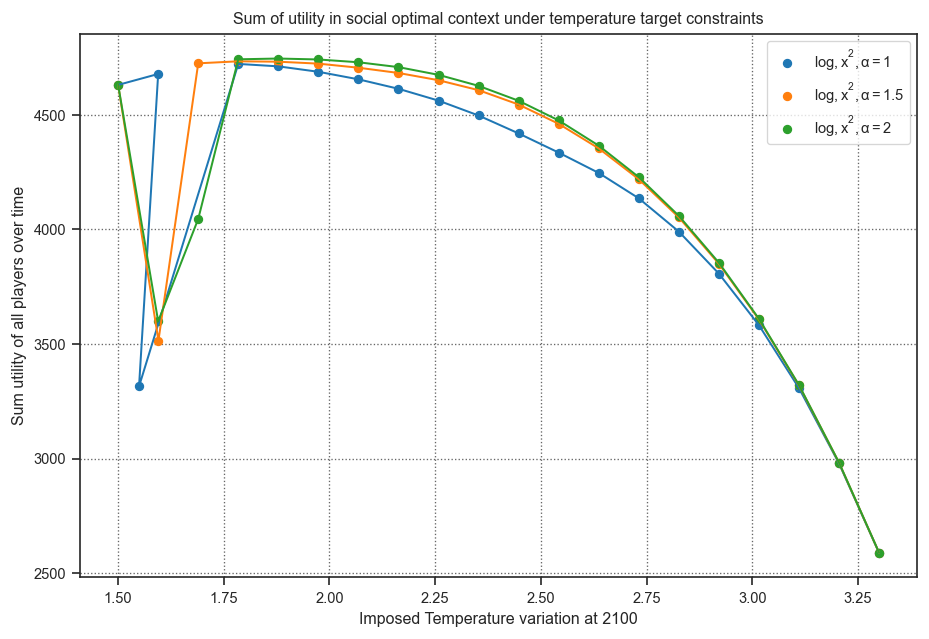

In [ ]:
plt.figure(dpi=120, figsize=FIG_SIZE)
for idx, res in enumerate(ress):
    plt.scatter(res[1][:,-1], np.sum(res[0],axis=1), label= r'${}, {}, \alpha = {}$'.format(list_label[idx][2][0],list_label[idx][0],list_label[idx][1]))
    plt.plot(res[1][:,-1], np.sum(res[0],axis=1))
    plt.xlabel('Imposed Temperature variation at 2100')
    plt.ylabel('Sum utility of all players over time')

plt.title('Sum of utility in social optimal context under temperature target constraints')
plt.legend()
plt.show()

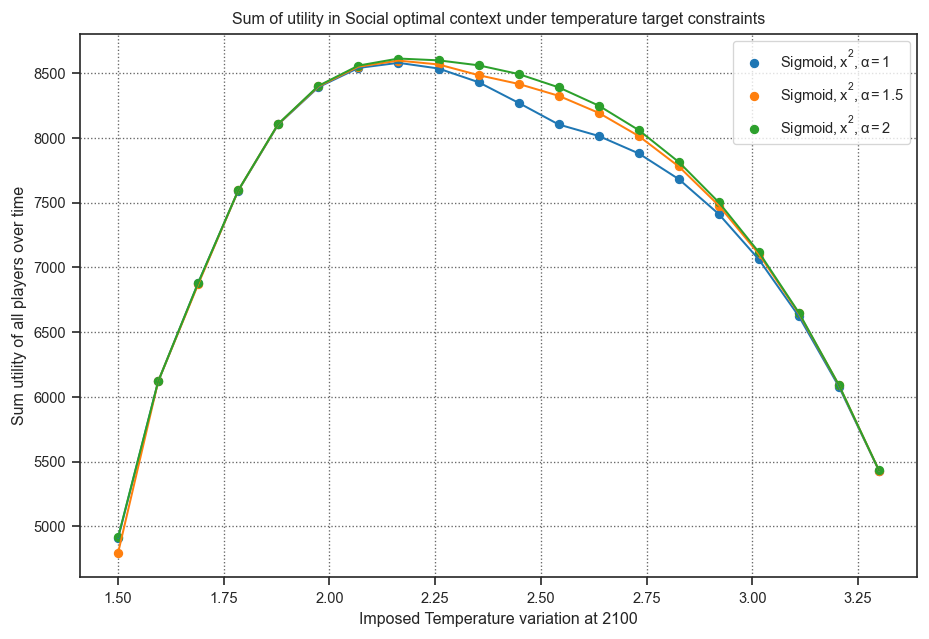

In [ ]:
plt.figure(dpi=120, figsize=FIG_SIZE)
for idx, res in enumerate(ress):
    plt.scatter(res[1][:,-1], np.sum(res[0],axis=1), label= r'${}, {}, \alpha = {}$'.format(list_label[idx][2][0],list_label[idx][0],list_label[idx][1]))
    plt.plot(res[1][:,-1], np.sum(res[0],axis=1))
    plt.xlabel('Imposed Temperature variation at 2100')
    plt.ylabel('Sum utility of all players over time')

plt.title('Sum of utility in social optimal context under temperature target constraints')
plt.legend()
plt.show()

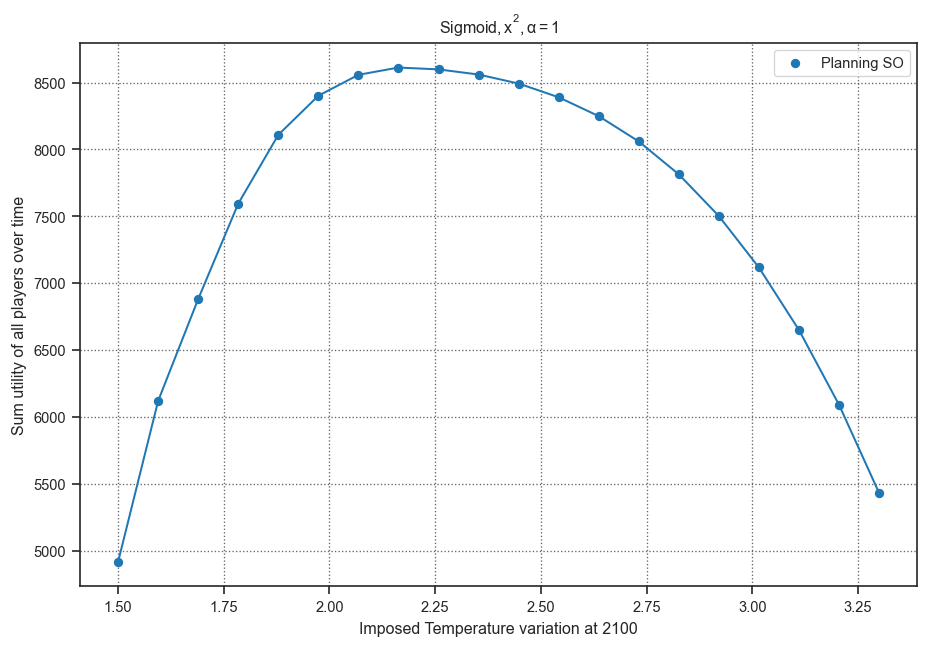

In [23]:
plt.figure(dpi=120, figsize=FIG_SIZE)
plt.scatter(res[1][:,-1], np.sum(res[0],axis=1), label='Planning SO')
plt.plot(res[1][:,-1], np.sum(res[0],axis=1))
plt.xlabel('Imposed Temperature variation at 2100')
plt.ylabel('Sum utility of all players over time')

plt.title(r'${}, {}, \alpha = {}$'.format(list_label[0][2][0],list_label[0][0],list_label[0][1]))
plt.legend()
plt.show()

In [16]:
a

array([[ 0.        , 11.36448238, 11.8466904 , 12.23809014, 12.58581797,
        12.89615729, 13.17743467, 13.42806435, 13.6511022 , 13.84533051,
        14.00818453, 14.13085306, 14.18879679, 14.16406494, 14.23209942,
        15.71447173],
       [ 6.33356529,  6.37308317,  6.4143813 ,  6.45670249,  6.50053883,
         6.54490964,  6.58923973,  6.63167345,  6.67199488,  6.70903676,
         6.74138699,  6.76655929,  6.77869694,  6.7733869 ,  6.78783501,
         7.14768629]])

In [17]:
s = np.sum(a, axis =0)

In [18]:
SCM.evaluate_trajectory(s)

(array([ 857.99441681,  873.78922995,  887.56203982,  900.5422758 ,
         913.20952998,  925.741642  ,  938.20783811,  950.62560577,
         962.99703384,  975.31268357,  987.55483088,  999.69126542,
        1011.65514049, 1023.35974277, 1034.9802949 , 1048.62151048]),
 array([2.2896108 , 2.53198394, 2.67446572, 2.81796606, 2.89852813,
        2.97728383, 3.01868619, 3.05987411, 3.09189425, 3.12572807,
        3.17331339, 3.22051392, 3.27001723, 3.31742172, 3.3626944 ,
        3.41759016]),
 array([1.12042393, 1.25020723, 1.34876352, 1.44130777, 1.50999172,
        1.57324351, 1.62223693, 1.66868406, 1.71213851, 1.7566399 ,
        1.80774442, 1.86160839, 1.91835868, 1.97644124, 2.03551855,
        2.1       ]))

In [12]:
a_1, a_2 = game.get_action_space()[:,:T,:]
min1max2 = np.stack((a_1[..., 0], a_2[...,1] ))
max1min2 = np.stack((a_1[..., 1], a_2[...,0] ))

In [13]:
np.sum(min1max2, axis=0)

array([20.04, 20.04, 20.04, 20.04, 20.04, 20.04, 20.04, 20.04, 20.04,
       20.04, 20.04, 20.04, 20.04, 20.04, 20.04, 20.04])

In [14]:
vals = np.stack([game.game_with_strategies_profile(min1max2, np.sum(min1max2, axis=0))[0], game.game_with_strategies_profile(max1min2, np.sum(min1max2, axis=0))[0] ])
val = np.stack([np.linspace(*vals[:,0]),np.linspace(*vals[:,1])])

In [38]:
val

array([[-272.69569938, -224.92427081, -177.15284224, -129.38141366,
         -81.60998509,  -33.83855652,   13.93287205,   61.70430062,
         109.47572919,  157.24715776,  205.01858634,  252.79001491,
         300.56144348,  348.33287205,  396.10430062,  443.87572919,
         491.64715776,  539.41858634,  587.19001491,  634.96144348,
         682.73287205,  730.50430062,  778.27572919,  826.04715776,
         873.81858634,  921.59001491,  969.36144348, 1017.13287205,
        1064.90430062, 1112.67572919, 1160.44715776, 1208.21858634,
        1255.99001491, 1303.76144348, 1351.53287205, 1399.30430062,
        1447.07572919, 1494.84715776, 1542.61858634, 1590.39001491,
        1638.16144348, 1685.93287205, 1733.70430062, 1781.47572919,
        1829.24715776, 1877.01858634, 1924.79001491, 1972.56144348,
        2020.33287205, 2068.10430062],
       [2723.99139562, 2661.00364051, 2598.01588541, 2535.02813031,
        2472.04037521, 2409.05262011, 2346.064865  , 2283.0771099 ,
        2

In [ ]:

val_2 = game.game_with_strategies_profile(list_players[1].action_set[:T,:][..., 0], list_players[1].action_set[t0:tmax,:][..., 0])

In [10]:
res = game.pareto_front()

Pareto front: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


In [12]:
game.reset()
a_rece, sum_a_rece, u_rece, sum_u_rece, temp_rece = game.receding_BRD_by_piece_return(T)
game.reset()
a_plan, sum_a_plan, u_plan, sum_u_plan, temp_plan = game.planning_BRD_by_piece_return(T)

game.reset()
a_plan_so, sum_a_plan_so, u_plan_so, sum_u_plan_so, temp_plan_so = game.planning_SO_by_piece_return(T)
game.reset()
a_rece_so, sum_a_rece_so, u_rece_so, sum_u_rece_so, temp_rece_so = game.receding_SO_by_piece_return(T)

u_p = np.sum(u_plan, axis=1)
u_r = np.sum(u_rece, axis=1)
u_p_so = np.sum(u_plan_so, axis =1)
u_r_so = np.sum(u_rece_so, axis =1)

Receding BRD, t_piece = 16:   0%|          | 0/16 [00:00<?, ?it/s]

{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 0, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 0, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 0, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 0, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 0, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 0, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 2

Receding BRD, t_piece = 16:   6%|▋         | 1/16 [00:00<00:09,  1.65it/s]

{'x0': array([23.48643254, 23.57920055, 23.70356251, 23.86081985, 24.05759307,
       24.29288537, 24.57228172, 24.89742737, 25.27780893, 25.72646316,
       26.26724539, 26.943089  , 27.82295627, 29.0401084 , 30.91937136,
       34.48341991]), 't0': 0, 'tmax': 16}
{'x0': array([23.48643254, 23.57920055, 23.70356251, 23.86081985, 24.05759307,
       24.29288537, 24.57228172, 24.89742737, 25.27780893, 25.72646316,
       26.26724539, 26.943089  , 27.82295627, 29.0401084 , 30.91937136,
       34.48341991]), 't0': 0, 'tmax': 16}
{'x0': array([23.48643254, 23.57920055, 23.70356251, 23.86081985, 24.05759307,
       24.29288537, 24.57228172, 24.89742737, 25.27780893, 25.72646316,
       26.26724539, 26.943089  , 27.82295627, 29.0401084 , 30.91937136,
       34.48341991]), 't0': 0, 'tmax': 16}
{'x0': array([23.48643254, 23.57920055, 23.70356251, 23.86081985, 24.05759307,
       24.29288537, 24.57228172, 24.89742737, 25.27780893, 25.72646316,
       26.26724539, 26.943089  , 27.82295627, 29.04

Receding BRD, t_piece = 16:  12%|█▎        | 2/16 [00:01<00:08,  1.74it/s]

{'x0': array([ 9.12180399,  9.1763987 ,  9.24318151,  9.32492531,  9.42098777,
        9.53341284,  9.66264713,  9.81185252,  9.98539586, 10.19094643,
       10.4419809 , 10.75838619, 11.17445317, 11.75626451, 12.6644218 ,
       14.41124193]), 't0': 1, 'tmax': 16}
{'x0': array([ 9.12180399,  9.1763987 ,  9.24318151,  9.32492531,  9.42098777,
        9.53341284,  9.66264713,  9.81185252,  9.98539586, 10.19094643,
       10.4419809 , 10.75838619, 11.17445317, 11.75626451, 12.6644218 ,
       14.41124193]), 't0': 1, 'tmax': 16}
{'x0': array([ 9.12180399,  9.1763987 ,  9.24318151,  9.32492531,  9.42098777,
        9.53341284,  9.66264713,  9.81185252,  9.98539586, 10.19094643,
       10.4419809 , 10.75838619, 11.17445317, 11.75626451, 12.6644218 ,
       14.41124193]), 't0': 1, 'tmax': 16}
{'x0': array([ 9.12180399,  9.1763987 ,  9.24318151,  9.32492531,  9.42098777,
        9.53341284,  9.66264713,  9.81185252,  9.98539586, 10.19094643,
       10.4419809 , 10.75838619, 11.17445317, 11.75

Receding BRD, t_piece = 16:  19%|█▉        | 3/16 [00:01<00:06,  1.98it/s]

{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 2, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 2, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 2, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 2, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 2, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 2, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 1

Receding BRD, t_piece = 16:  25%|██▌       | 4/16 [00:01<00:05,  2.13it/s]

{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 3, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 3, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 3, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 3, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 3, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 3, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 1

Receding BRD, t_piece = 16:  31%|███▏      | 5/16 [00:02<00:04,  2.28it/s]

{'x0': array([21.59167913, 21.77715943, 21.98235007, 22.20583105, 22.4502555 ,
       22.7185464 , 23.0169944 , 23.35687897, 23.75110196, 24.21748595,
       24.78154235, 25.48250714, 26.38777069, 27.62824166, 29.52372038,
       33.10479294]), 't0': 4, 'tmax': 16}
{'x0': array([21.59167913, 21.77715943, 21.98235007, 22.20583105, 22.4502555 ,
       22.7185464 , 23.0169944 , 23.35687897, 23.75110196, 24.21748595,
       24.78154235, 25.48250714, 26.38777069, 27.62824166, 29.52372038,
       33.10479294]), 't0': 4, 'tmax': 16}
{'x0': array([21.59167913, 21.77715943, 21.98235007, 22.20583105, 22.4502555 ,
       22.7185464 , 23.0169944 , 23.35687897, 23.75110196, 24.21748595,
       24.78154235, 25.48250714, 26.38777069, 27.62824166, 29.52372038,
       33.10479294]), 't0': 4, 'tmax': 16}
{'x0': array([21.59167913, 21.77715943, 21.98235007, 22.20583105, 22.4502555 ,
       22.7185464 , 23.0169944 , 23.35687897, 23.75110196, 24.21748595,
       24.78154235, 25.48250714, 26.38777069, 27.62

Receding BRD, t_piece = 16:  38%|███▊      | 6/16 [00:02<00:04,  2.42it/s]

{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 6, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 6, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 6, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 6, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 6, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 6, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 2

Receding BRD, t_piece = 16:  44%|████▍     | 7/16 [00:03<00:03,  2.40it/s]

{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 6, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 6, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 6, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 6, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 6, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 6, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 1

Receding BRD, t_piece = 16:  50%|█████     | 8/16 [00:03<00:03,  2.43it/s]

{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 7, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 7, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 7, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 7, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 7, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 7, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 1

Receding BRD, t_piece = 16:  56%|█████▋    | 9/16 [00:03<00:02,  2.42it/s]

{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 8, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 8, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 8, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 8, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 8, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 8, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 1

Receding BRD, t_piece = 16:  62%|██████▎   | 10/16 [00:04<00:02,  2.41it/s]

{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 9, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 9, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 9, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 9, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 9, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02,
       10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02]), 't0': 9, 'tmax': 16}
{'x0': array([10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 10.02, 1

Receding BRD, t_piece = 16:  69%|██████▉   | 11/16 [00:04<00:02,  2.45it/s]

{'x0': array([18.83506648, 19.05934131, 19.29493626, 19.54632148, 19.81793235,
       20.11519343, 20.44475446, 20.81530076, 21.2387687 , 21.73547424,
       22.33189486, 23.06827714, 24.01344092, 25.30077311, 27.25546518,
       30.90115411]), 't0': 10, 'tmax': 16}
{'x0': array([18.83506648, 19.05934131, 19.29493626, 19.54632148, 19.81793235,
       20.11519343, 20.44475446, 20.81530076, 21.2387687 , 21.73547424,
       22.33189486, 23.06827714, 24.01344092, 25.30077311, 27.25546518,
       30.90115411]), 't0': 10, 'tmax': 16}
{'x0': array([18.83506648, 19.05934131, 19.29493626, 19.54632148, 19.81793235,
       20.11519343, 20.44475446, 20.81530076, 21.2387687 , 21.73547424,
       22.33189486, 23.06827714, 24.01344092, 25.30077311, 27.25546518,
       30.90115411]), 't0': 10, 'tmax': 16}
{'x0': array([18.83506648, 19.05934131, 19.29493626, 19.54632148, 19.81793235,
       20.11519343, 20.44475446, 20.81530076, 21.2387687 , 21.73547424,
       22.33189486, 23.06827714, 24.01344092, 25

Receding BRD, t_piece = 16:  75%|███████▌  | 12/16 [00:05<00:01,  2.23it/s]

{'x0': array([18.32204102, 18.5540193 , 18.79745839, 19.05647935, 19.3352837 ,
       19.63907517, 19.97470813, 20.35120027, 20.78363725, 21.29023699,
       21.89698817, 22.64411925, 23.60067361, 24.90076355, 26.86748935,
       30.52626839]), 't0': 11, 'tmax': 16}
{'x0': array([18.32204102, 18.5540193 , 18.79745839, 19.05647935, 19.3352837 ,
       19.63907517, 19.97470813, 20.35120027, 20.78363725, 21.29023699,
       21.89698817, 22.64411925, 23.60067361, 24.90076355, 26.86748935,
       30.52626839]), 't0': 11, 'tmax': 16}
{'x0': array([18.32204102, 18.5540193 , 18.79745839, 19.05647935, 19.3352837 ,
       19.63907517, 19.97470813, 20.35120027, 20.78363725, 21.29023699,
       21.89698817, 22.64411925, 23.60067361, 24.90076355, 26.86748935,
       30.52626839]), 't0': 11, 'tmax': 16}
{'x0': array([18.32204102, 18.5540193 , 18.79745839, 19.05647935, 19.3352837 ,
       19.63907517, 19.97470813, 20.35120027, 20.78363725, 21.29023699,
       21.89698817, 22.64411925, 23.60067361, 24

Receding BRD, t_piece = 16:  81%|████████▏ | 13/16 [00:05<00:01,  2.16it/s]

{'x0': array([17.96661445, 18.20780072, 18.45971329, 18.72563388, 19.01034101,
       19.31864987, 19.65804913, 20.04023063, 20.47843038, 20.9903962 ,
       21.6017047 , 22.35222362, 23.311426  , 24.61603755, 26.58791459,
       30.24801245]), 't0': 12, 'tmax': 16}
{'x0': array([ 7.10191791,  7.18665097,  7.27686547,  7.37388836,  7.47975988,
        7.59640048,  7.72719048,  7.87741883,  8.05313259,  8.26271049,
        8.51851608,  8.83998879,  9.26119122,  9.84934817, 10.76382016,
       12.52019341]), 't0': 12, 'tmax': 16}
{'x0': array([ 7.10191791,  7.18665097,  7.27686547,  7.37388836,  7.47975988,
        7.59640048,  7.72719048,  7.87741883,  8.05313259,  8.26271049,
        8.51851608,  8.83998879,  9.26119122,  9.84934817, 10.76382016,
       12.52019341]), 't0': 12, 'tmax': 16}
{'x0': array([ 7.10191791,  7.18665097,  7.27686547,  7.37388836,  7.47975988,
        7.59640048,  7.72719048,  7.87741883,  8.05313259,  8.26271049,
        8.51851608,  8.83998879,  9.26119122,  9

Receding BRD, t_piece = 16:  88%|████████▊ | 14/16 [00:06<00:00,  2.26it/s]

{'x0': array([ 6.91474002,  6.99952163,  7.08957063,  7.18631855,  7.29152248,
        7.40766041,  7.53879567,  7.68963138,  7.8659976 ,  8.076151  ,
        8.33267272,  8.65484905,  9.07681787,  9.66578287, 10.5811676 ,
       12.33856107]), 't0': 13, 'tmax': 16}
{'x0': array([ 6.91474002,  6.99952163,  7.08957063,  7.18631855,  7.29152248,
        7.40766041,  7.53879567,  7.68963138,  7.8659976 ,  8.076151  ,
        8.33267272,  8.65484905,  9.07681787,  9.66578287, 10.5811676 ,
       12.33856107]), 't0': 13, 'tmax': 16}
{'x0': array([ 6.91474002,  6.99952163,  7.08957063,  7.18631855,  7.29152248,
        7.40766041,  7.53879567,  7.68963138,  7.8659976 ,  8.076151  ,
        8.33267272,  8.65484905,  9.07681787,  9.66578287, 10.5811676 ,
       12.33856107]), 't0': 13, 'tmax': 16}
{'x0': array([ 6.91474002,  6.99952163,  7.08957063,  7.18631855,  7.29152248,
        7.40766041,  7.53879567,  7.68963138,  7.8659976 ,  8.076151  ,
        8.33267272,  8.65484905,  9.07681787,  9

Receding BRD, t_piece = 16:  94%|█████████▍| 15/16 [00:06<00:00,  2.21it/s]

{'x0': array([ 6.72542611,  6.81030257,  6.90021087,  6.99652562,  7.10119534,
        7.21753633,  7.34905892,  7.50021696,  7.67696995,  7.88770943,
        8.14481908,  8.46778944,  8.89063273,  9.48035902, 10.39655106,
       12.15475055]), 't0': 14, 'tmax': 16}
{'x0': array([ 6.72542611,  6.81030257,  6.90021087,  6.99652562,  7.10119534,
        7.21753633,  7.34905892,  7.50021696,  7.67696995,  7.88770943,
        8.14481908,  8.46778944,  8.89063273,  9.48035902, 10.39655106,
       12.15475055]), 't0': 14, 'tmax': 16}
{'x0': array([ 6.72542611,  6.81030257,  6.90021087,  6.99652562,  7.10119534,
        7.21753633,  7.34905892,  7.50021696,  7.67696995,  7.88770943,
        8.14481908,  8.46778944,  8.89063273,  9.48035902, 10.39655106,
       12.15475055]), 't0': 14, 'tmax': 16}
{'x0': array([ 6.72542611,  6.81030257,  6.90021087,  6.99652562,  7.10119534,
        7.21753633,  7.34905892,  7.50021696,  7.67696995,  7.88770943,
        8.14481908,  8.46778944,  8.89063273,  9

Receding BRD, t_piece = 16: 100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


{'x0': array([ 6.53420462,  6.61889276,  6.70832562,  6.80419366,  6.90907528,
        7.0258003 ,  7.15782315,  7.30944387,  7.48669171,  7.69797155,
        7.95558578,  8.27908346,  8.70253101,  9.29311062, 10.21026266,
       11.96968706]), 't0': 15, 'tmax': 16}
{'x0': array([ 6.53420462,  6.61889276,  6.70832562,  6.80419366,  6.90907528,
        7.0258003 ,  7.15782315,  7.30944387,  7.48669171,  7.69797155,
        7.95558578,  8.27908346,  8.70253101,  9.29311062, 10.21026266,
       11.96968706]), 't0': 15, 'tmax': 16}
{'x0': array([ 6.53420462,  6.61889276,  6.70832562,  6.80419366,  6.90907528,
        7.0258003 ,  7.15782315,  7.30944387,  7.48669171,  7.69797155,
        7.95558578,  8.27908346,  8.70253101,  9.29311062, 10.21026266,
       11.96968706]), 't0': 15, 'tmax': 16}
{'x0': array([ 6.53420462,  6.61889276,  6.70832562,  6.80419366,  6.90907528,
        7.0258003 ,  7.15782315,  7.30944387,  7.48669171,  7.69797155,
        7.95558578,  8.27908346,  8.70253101,  9

Planning BRD, t_piece = 16:   0%|          | 0/1 [00:00<?, ?it/s]

{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 0, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 0, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 0, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 0, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 0, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94,
       22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94]), 't0': 0, 'tmax': 16}
{'x0': array([22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 22.94, 2

Planning BRD, t_piece = 16: 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


{'x0': array([23.48643254, 23.57920055, 23.70356251, 23.86081985, 24.05759307,
       24.29288537, 24.57228172, 24.89742737, 25.27780893, 25.72646316,
       26.26724539, 26.943089  , 27.82295627, 29.0401084 , 30.91937136,
       34.48341991]), 't0': 0, 'tmax': 16}
{'x0': array([23.48643254, 23.57920055, 23.70356251, 23.86081985, 24.05759307,
       24.29288537, 24.57228172, 24.89742737, 25.27780893, 25.72646316,
       26.26724539, 26.943089  , 27.82295627, 29.0401084 , 30.91937136,
       34.48341991]), 't0': 0, 'tmax': 16}
{'x0': array([23.48643254, 23.57920055, 23.70356251, 23.86081985, 24.05759307,
       24.29288537, 24.57228172, 24.89742737, 25.27780893, 25.72646316,
       26.26724539, 26.943089  , 27.82295627, 29.0401084 , 30.91937136,
       34.48341991]), 't0': 0, 'tmax': 16}
{'x0': array([23.48643254, 23.57920055, 23.70356251, 23.86081985, 24.05759307,
       24.29288537, 24.57228172, 24.89742737, 25.27780893, 25.72646316,
       26.26724539, 26.943089  , 27.82295627, 29.04

Receding SO, t_piece = 16: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]


In [ ]:
game.reset()
a_rece, sum_a_rece, u_rece, sum_u_rece, temp_rece = game.receding_BRD_by_piece_return(T)
game.reset()
a_plan, sum_a_plan, u_plan, sum_u_plan, temp_plan = game.planning_BRD_by_piece_return(T)

game.reset()
a_plan_so, sum_a_plan_so, u_plan_so, sum_u_plan_so, temp_plan_so = game.planning_SO_by_piece_return(T)
game.reset()
a_rece_so, sum_a_rece_so, u_rece_so, sum_u_rece_so, temp_rece_so = game.receding_SO_by_piece_return(T)

u_p = np.sum(u_plan, axis=1)
u_r = np.sum(u_rece, axis=1)
u_p_so = np.sum(u_plan_so, axis =1)
u_r_so = np.sum(u_rece_so, axis =1)


argsort = arr[:,0].argsort()

sorted = np.zeros_like(arr)
sorted[:,0] = arr[:,0][argsort]
sorted[:,1] = arr[:,1][argsort]


x = np.linspace(np.min(sorted[:,0]), np.max(sorted[:,0]),100)
y = np.linspace(np.min(sorted[:,1]), np.max(sorted[:,1]),100)
inter = np.interp(x, sorted[:,0], sorted[:,1])
plt.plot(inter)

In [39]:
a = game.get_action_space()

In [7]:
def generate_perturbation(action, lower_bounds=lower_bounds, upper_bounds=upper_bounds, size=5000, scale=.05):
    shape = action.shape
    perturbation = stats.norm.rvs(loc = 0, scale=scale, size=(size,*shape))
    # perturbation = truncNormal_rvs(action - lower_bounds, upper_bounds - action, loc=0, scale= scale, size=(size, *shape))
    arr = action + perturbation
    res = np.where(arr < upper_bounds, arr, upper_bounds)
    res = np.where(arr > lower_bounds, arr, lower_bounds)
    return res

[array([ 3.6       ,  3.48834244,  3.37396153,  3.25713266,  3.13813122,
        3.01723262,  2.89471224,  2.77084548,  2.64590774,  2.52017442,
        2.3939209 ,  2.26742259,  2.14095487,  2.01479316,  1.88921283,
        1.76448929,  1.64089793,  1.51871414,  1.39821333,  1.27967089,
        1.1633622 ,  1.04956268,  0.93854771,  0.8305927 ,  0.72597302,
        0.62496409,  0.52784129,  0.43488002,  0.34635569,  0.26254367,
        0.18371937,  0.11015818,  0.0421355 , -0.02007327, -0.07619274,
       -0.12594752, -0.16906221, -0.20526141, -0.23426973, -0.25581178,
       -0.26961215, -0.27539546, -0.2728863 , -0.26180928, -0.24188901,
       -0.21285009, -0.17441712, -0.12631472, -0.06826747,  0.        ]), array([ 1.2       ,  1.2790589 ,  1.3451742 ,  1.39889672,  1.44077723,
        1.47136652,  1.49121539,  1.50087464,  1.50089504,  1.49182738,
        1.47422248,  1.4486311 ,  1.41560404,  1.3756921 ,  1.32944606,
        1.27741672,  1.22015487,  1.15821129,  1.09213678,  1

ValueError: Unrecognized marker style array([-6.        , -5.34879174, -4.74118777, -4.1758111 , -3.65128475,
       -3.16623176, -2.71927513, -2.3090379 , -1.93414309, -1.59321371,
       -1.2848728 , -1.00774337, -0.76044845, -0.54161106, -0.34985423,
       -0.18380097, -0.04207431,  0.07670273,  0.17390713,  0.25091586,
        0.3091059 ,  0.34985423,  0.37453782,  0.38453366,  0.38121871,
        0.36596996,  0.34016439,  0.30517896,  0.26239067,  0.21317648,
        0.15891338,  0.10097833,  0.04074833, -0.02039966, -0.08108866,
       -0.13994169, -0.19558177, -0.24663193, -0.29171519, -0.32945456,
       -0.35847309, -0.37739377, -0.38483965, -0.37943374, -0.35979906,
       -0.32455864, -0.27233551, -0.20175267, -0.11143316,  0.        ])

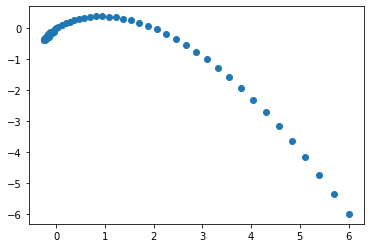

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def select_stepsize(point1, point2, num_steps):
    # Calculate the Euclidean distance between the two points
    distance = np.linalg.norm(point2 - point1)

    # Determine the increment size
    increment_size = distance / num_steps

    # Generate intermediate points between the two points
    intermediate_points = []
    for i in range(1, num_steps + 1):
        # Calculate the position of the intermediate point
        position = point1 + (point2 - point1) * (i / num_steps)

        intermediate_points.append(position)

    return intermediate_points

# Example usage

def f(x,y):
    return x**2 -y , y**3 - x

point1 = np.linspace(-2,1,50)
point2 =  np.linspace(-2,1,50)
point1, point2 = f(point1, point2)
num_steps = 2

intermediate_points = select_stepsize(point1, point2, num_steps)
print(intermediate_points)

plt.scatter(point1, point2)
plt.scatter(*intermediate_points)

In [41]:
utilities_minus = []
actions_minus = []

for idx in range(2):
    for val in np.linspace(-400,2500,10):
        res_minus = game.planning_SO_inverse_by_piece_with_constraint_return(T, constraint_player=idx, constraint_value=val)

        utilities_minus.append(np.sum(res_minus[2], axis = 1))
        actions_minus.append(res_minus[0])

        # if len(utilities)>2:
        #     if np.all(utilities[-1] == utilities[-2]):
        #         print('passed')
        #         break


Planning SO, t_piece = 18: 100%|██████████| 1/1 [00:06<00:00,  6.60s/it]


     fun: 1419.1933685703561
     jac: array([-2.58602905, 48.75112915, -2.5411377 , 48.82949829, -2.4854126 ,
       48.92669678, -2.42012024, 49.04064941, -2.34405518, 49.17340088,
       -2.25941467, 49.32112122, -2.1660614 , 49.48402405, -2.06576538,
       49.6590271 , -1.95812988, 49.84683228, -1.84286499, 50.04800415,
       -1.71826172, 50.26539612, -1.58126831, 50.50448608, -1.42910767,
       50.77001953, -1.2583313 , 51.06802368, -1.06494141, 51.40551758,
       -0.84356689, 51.7918396 , -0.58700562, 52.23953247, -0.29223633,
       52.75392151])
 message: 'Positive directional derivative for linesearch'
    nfev: 4011
     nit: 98
    njev: 94
  status: 8
 success: False
       x: array([2.36033606e+01, 3.69980655e-11, 2.37032021e+01, 3.70475327e-11,
       2.38290368e+01, 3.71301532e-11, 2.39798024e+01, 3.71715322e-11,
       2.41598676e+01, 3.72702582e-11, 2.43662707e+01, 3.74288489e-11,
       2.46019020e+01, 3.75262430e-11, 2.48652282e+01, 3.76389199e-11,
       2.51606

Planning SO, t_piece = 18: 100%|██████████| 1/1 [00:06<00:00,  6.96s/it]


     fun: 1417.9853467839403
     jac: array([-2.60429382, 48.74627686, -2.559021  , 48.82478333, -2.50296021,
       48.92198181, -2.43725586, 49.03601074, -2.36062622, 49.16891479,
       -2.27542114, 49.31672668, -2.18147278, 49.47973633, -2.08044434,
       49.65496826, -1.97210693, 49.84289551, -1.85601807, 50.04428101,
       -1.7305603 , 50.26190186, -1.59259033, 50.50123596, -1.43937683,
       50.76705933, -1.2673645 , 51.06539917, -1.07258606, 51.40328979,
       -0.84960938, 51.7901001 , -0.59124756, 52.23829651, -0.29431152,
       52.75334167])
 message: 'Positive directional derivative for linesearch'
    nfev: 4167
     nit: 102
    njev: 98
  status: 8
 success: False
       x: array([2.36431464e+01, 1.25280880e-12, 2.37428642e+01, 1.26770179e-12,
       2.38685502e+01, 1.24951208e-12, 2.40190785e+01, 1.25059812e-12,
       2.41989046e+01, 1.28109175e-12, 2.44050941e+01, 1.27194662e-12,
       2.46404401e+01, 1.28482786e-12, 2.49034954e+01, 1.27472501e-12,
       2.5198

Planning SO, t_piece = 18: 100%|██████████| 1/1 [00:06<00:00,  6.13s/it]


     fun: 1416.7552705445448
     jac: array([-2.62275696, 48.74125671, -2.57720947, 48.81977844, -2.52076721,
       48.91712952, -2.45457458, 49.03126526, -2.37747192, 49.16421509,
       -2.29168701, 49.31216431, -2.19706726, 49.47531128, -2.09539795,
       49.65065002, -1.98625183, 49.83882141, -1.86935425, 50.04042053,
       -1.74301147, 50.25827026, -1.60406494, 50.49789429, -1.44972229,
       50.76400757, -1.27650452, 51.06272888, -1.08033752, 51.40101624,
       -0.85572815, 51.78831482, -0.59550476, 52.23701477, -0.29646301,
       52.75270081])
 message: 'Positive directional derivative for linesearch'
    nfev: 3698
     nit: 92
    njev: 88
  status: 8
 success: False
       x: array([2.36833702e+01, 5.01253808e-12, 2.37829509e+01, 5.02162430e-12,
       2.39084787e+01, 5.03050660e-12, 2.40588073e+01, 5.04328633e-12,
       2.42383965e+01, 5.05489967e-12, 2.44443477e+01, 5.07132427e-12,
       2.46794065e+01, 5.09110675e-12, 2.49421970e+01, 5.10570050e-12,
       2.52370

Planning SO, t_piece = 18: 100%|██████████| 1/1 [00:05<00:00,  5.56s/it]


     fun: 1415.4670418908938
     jac: array([-2.64173889, 48.7361908 , -2.59585571, 48.81481934, -2.53907776,
       48.91215515, -2.47242737, 49.02641296, -2.39477539, 49.15950012,
       -2.30838013, 49.30755615, -2.21307373, 49.47085571, -2.11070251,
       49.64634705, -2.00083923, 49.8346405 , -1.88304138, 50.0365448 ,
       -1.75579834, 50.25462341, -1.61582947, 50.49449158, -1.46037292,
       50.76098633, -1.28587341, 51.06001282, -1.08824158, 51.39872742,
       -0.86201477, 51.78648376, -0.59983826, 52.23580933, -0.29862976,
       52.75209045])
 message: 'Positive directional derivative for linesearch'
    nfev: 3815
     nit: 93
    njev: 89
  status: 8
 success: False
       x: array([2.37251674e+01, 1.12709575e-12, 2.38246401e+01, 1.12703635e-12,
       2.39499774e+01, 1.12657678e-12, 2.41001028e+01, 1.13252616e-12,
       2.42794481e+01, 1.13668600e-12, 2.44851344e+01, 1.14029917e-12,
       2.47199280e+01, 1.14341747e-12, 2.49824156e+01, 1.14574639e-12,
       2.52769

Planning SO, t_piece = 18: 100%|██████████| 1/1 [00:04<00:00,  4.68s/it]


     fun: 1414.4167308385026
     jac: array([-2.65713501, 48.73199463, -2.61099243, 48.81066895, -2.55389404,
       48.90809631, -2.48684692, 49.0223999 , -2.40881348, 49.1555481 ,
       -2.32191467, 49.3037262 , -2.22610474, 49.46714783, -2.12310791,
       49.64282227, -2.01263428, 49.83126831, -1.89419556, 50.03326416,
       -1.76617432, 50.25158691, -1.62539673, 50.4916687 , -1.46902466,
       50.75842285, -1.29350281, 51.05778503, -1.0947113 , 51.39682007,
       -0.86714172, 51.78497314, -0.60340881, 52.23477173, -0.30038452,
       52.75158691])
 message: 'Positive directional derivative for linesearch'
    nfev: 3481
     nit: 87
    njev: 83
  status: 8
 success: False
       x: array([2.37590213e+01, 1.17824174e-11, 2.38583684e+01, 1.18000637e-11,
       2.39835647e+01, 1.18199034e-11, 2.41335358e+01, 1.18494790e-11,
       2.43127051e+01, 1.18779434e-11, 2.45181601e+01, 1.19115399e-11,
       2.47527281e+01, 1.19506611e-11, 2.50150130e+01, 1.19886017e-11,
       2.53093

Planning SO, t_piece = 18: 100%|██████████| 1/1 [00:04<00:00,  4.72s/it]


     fun: 1412.807338574566
     jac: array([-2.68048096, 48.72555542, -2.63391113, 48.80435181, -2.57629395,
       48.9019165 , -2.50875854, 49.01629639, -2.42999268, 49.14959717,
       -2.34243774, 49.2979126 , -2.24580383, 49.46148682, -2.14193726,
       49.63735962, -2.0304718 , 49.82611084, -1.91098022, 50.02838135,
       -1.78186035, 50.24700928, -1.63987732, 50.48742676, -1.48210144,
       50.75456238, -1.30502319, 51.05438232, -1.10446167, 51.3939209 ,
       -0.87486267, 51.78269958, -0.60879517, 52.2331543 , -0.30307007,
       52.7507782 ])
 message: 'Positive directional derivative for linesearch'
    nfev: 2941
     nit: 74
    njev: 70
  status: 8
 success: False
       x: array([2.38104952e+01, 3.94846022e-13, 2.39096975e+01, 4.03107399e-13,
       2.40346908e+01, 4.01467277e-13, 2.41843711e+01, 4.00408033e-13,
       2.43632351e+01, 4.06202305e-13, 2.45683985e+01, 4.06096827e-13,
       2.48026461e+01, 4.11763560e-13, 2.50645779e+01, 4.11527077e-13,
       2.535857

Planning SO, t_piece = 18: 100%|██████████| 1/1 [00:04<00:00,  4.27s/it]


     fun: 1411.4235039775776
     jac: array([-2.70011902, 48.7202301 , -2.65325928, 48.79908752, -2.59524536,
       48.896698  , -2.52722168, 49.01118469, -2.44796753, 49.14459229,
       -2.35977173, 49.29301453, -2.26242065, 49.45681763, -2.15782166,
       49.63282776, -2.04554749, 49.82174683, -1.92520142, 50.02426147,
       -1.79516602, 50.24310303, -1.65206909, 50.48384094, -1.49313354,
       50.75132751, -1.31472778, 51.05154419, -1.1126709 , 51.39151001,
       -0.88137817, 51.78079224, -0.61331177, 52.23184204, -0.30531311,
       52.75012207])
 message: 'Positive directional derivative for linesearch'
    nfev: 2652
     nit: 68
    njev: 64
  status: 8
 success: False
       x: array([2.38543881e+01, 4.16735967e-12, 2.39534514e+01, 4.16624689e-12,
       2.40782606e+01, 4.17657927e-12, 2.42277559e+01, 4.19897142e-12,
       2.44063909e+01, 4.18381853e-12, 2.46112633e+01, 4.20756901e-12,
       2.48452070e+01, 4.21819881e-12, 2.51068429e+01, 4.23097903e-12,
       2.54005

Planning SO, t_piece = 18: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]


     fun: 1410.005047181058
     jac: array([-2.72010803, 48.71473694, -2.67295837, 48.79359436, -2.61451721,
       48.89134216, -2.54597473, 49.00593567, -2.46614075, 49.13945007,
       -2.37730408, 49.28804016, -2.27932739, 49.45193481, -2.17393494,
       49.62815857, -2.06085205, 49.817276  , -1.93963623, 50.02003479,
       -1.80860901, 50.23913574, -1.66447449, 50.48017883, -1.50436401,
       50.74797058, -1.324646  , 51.04858398, -1.12104797, 51.38905334,
       -0.88798523, 51.77882385, -0.61791992, 52.23049927, -0.30761719,
       52.74946594])
 message: 'Positive directional derivative for linesearch'
    nfev: 2376
     nit: 62
    njev: 58
  status: 8
 success: False
       x: array([2.38990331e+01, 1.56464629e-11, 2.39979846e+01, 1.56729333e-11,
       2.41226139e+01, 1.57080544e-11, 2.42718589e+01, 1.57415062e-11,
       2.44502350e+01, 1.57817442e-11, 2.46548743e+01, 1.58264855e-11,
       2.48885331e+01, 1.58761905e-11, 2.51498421e+01, 1.59354209e-11,
       2.544328

Planning SO, t_piece = 18: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


     fun: 190.41746345316864
     jac: array([ 1.43889809, -2.01508331,  1.49599457, -1.95798492,  1.57635307,
       34.15336418,  1.66930962, 51.44231987,  1.77158356, 51.54458618,
        1.87779427, 51.65080261,  1.98698425, 51.75999451,  2.09590149,
       51.8689003 ,  2.2042141 , 51.97722435,  2.31158257, 52.08459663,
        2.41892242, 52.19193459,  2.52861404, 52.30161667,  2.64221764,
       52.41522217,  2.76152992, 52.53453636,  2.88830566, 52.6613121 ,
        3.02478409, 52.79779053,  3.17390442, 52.94691086,  3.3363781 ,
       53.10938263])
 message: 'Positive directional derivative for linesearch'
    nfev: 740
     nit: 24
    njev: 20
  status: 8
 success: False
       x: array([3.09634132e-11, 2.00400000e+01, 8.46954492e-12, 2.00400000e+01,
       8.26238518e-12, 1.86384657e+00, 7.97288809e-12, 0.00000000e+00,
       7.66712437e-12, 4.93880702e-14, 7.38446712e-12, 8.13117297e-11,
       7.07921188e-12, 7.27770098e-11, 6.78035173e-12, 6.58182073e-11,
       6.500469

Planning SO, t_piece = 18: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

     fun: 2171.81111082083
     jac: array([-2.21954346e-01, -3.67593384e+00, -1.56005859e-01, -3.61001587e+00,
       -7.08312988e-02, -3.52484131e+00,  3.10668945e-02, -3.42297363e+00,
        1.51062012e-01, -3.30297852e+00,  2.85125732e-01, -3.16894531e+00,
        4.32983398e-01, -3.02105713e+00,  5.91461182e-01, -2.86248779e+00,
        7.60864258e-01, -2.69314575e+00,  9.41436768e-01, -2.51257324e+00,
        1.13531494e+00, -2.31866455e+00,  1.34729004e+00, -2.10671997e+00,
        1.58142090e+00, -1.87261963e+00,  1.84197998e+00, -1.61203003e+00,
        2.13000488e+00,  4.42505493e+01,  2.43951416e+00,  5.22125244e+01,
        2.77316284e+00,  5.25461731e+01,  3.13619995e+00, -3.17749023e-01])
 message: 'Positive directional derivative for linesearch'
    nfev: 888
     nit: 28
    njev: 24
  status: 8
 success: False
       x: array([0.00000000e+00, 2.00400000e+01, 1.69864123e-13, 2.00400000e+01,
       7.78266340e-14, 2.00400000e+01, 0.00000000e+00, 2.00400000e+01,
       0

In [42]:
arr_minus = np.array(utilities_minus)
arr_actions_minus = np.stack(actions_minus,axis=0)


In [43]:
arr_actions_minus.shape

(100, 2, 18)

In [44]:
minus_perturbated = np.concatenate([np.concatenate([generate_perturbation(minus, lower_bounds, upper_bounds, scale=scale) for scale in [0.05, 0.15, 0.5, 1, 1.5]]) for minus in arr_actions_minus])

In [45]:
def process(list_strategy_profile, game : Game) : 
    data_utilities = []
    data_temp = []
    list_sum_strategy = np.sum(list_strategy_profile, axis=1)
    list_ = list(zip(list_strategy_profile,list_sum_strategy))
    for strategy, sum_ in tqdm(list_, total = len(list_), desc ='Processing'):
        u,temp = game.game_with_strategies_profile(strategy,sum_)
        data_utilities.append(u)
        data_temp.append(temp)
    return np.array(data_utilities), np.array(data_temp)

In [15]:
utilities = []
for idx in range(2):
    for val in np.linspace(-300,3500,10):
        res = game.planning_SO_by_piece_with_constraint_return(T, constraint_player=idx, constraint_value=val)
        utilities.append(np.sum(res[2], axis=1))

arr = np.array(utilities)


Planning SO, t_piece = 16: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


     fun: -2451.295696493298
     jac: array([-0.36132812,  3.09255981, -0.41891479,  3.03500366, -0.49731445,
        2.956604  , -0.59384155,  2.8600769 , -0.70993042,  2.74398804,
       -0.8416748 ,  2.61227417, -0.98876953,  2.46511841, -1.14828491,
        2.30563354, -1.32043457,  2.13348389, -1.50576782,  1.94818115,
       -1.70669556,  1.74728394, -1.92834473,  1.52563477, -2.17562866,
        1.27828979, -2.45529175,  0.99868774, -2.7749939 ,  0.67895508,
       -3.13693237,  0.3170166 ])
 message: 'Inequality constraints incompatible'
    nfev: 509
     nit: 13
    njev: 13
  status: 4
 success: False
       x: array([9.17600016e-09, 2.00400000e+01, 9.17600016e-09, 2.00400000e+01,
       9.17600012e-09, 2.00400000e+01, 9.17600001e-09, 2.00400000e+01,
       1.05012017e-16, 2.00400000e+01, 9.17601734e-09, 2.00400000e+01,
       1.62110302e-16, 2.00400000e+01, 9.17600025e-09, 2.00400000e+01,
       1.45974980e-16, 2.00400000e+01, 9.17600012e-09, 2.00400000e+01,
       9.17600

Planning SO, t_piece = 16: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


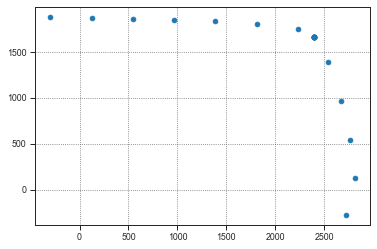

In [16]:
plt.scatter(arr[:,1], arr[:,0])

In [48]:
ir_0 = game.minmax_value(0)
ir_1 = game.minmax_value(1)

In [49]:
print(horizon, ir_0, ir_1)

2110 1527.7621686865618 1908.7270447201563


2150 641.2654860353757 -1355.5246057973357


2100 1632.7679663918234 2247.5258704857824


2105 1486.6283397484817 2182.567939055066

In [51]:
game.reset()
a_rece, sum_a_rece, u_rece, sum_u_rece, temp_rece = game.receding_BRD_by_piece_return(T)
game.reset()
a_plan, sum_a_plan, u_plan, sum_u_plan, temp_plan = game.planning_BRD_by_piece_return(T)

game.reset()
a_plan_so, sum_a_plan_so, u_plan_so, sum_u_plan_so, temp_plan_so = game.planning_SO_by_piece_return(T)
game.reset()
a_rece_so, sum_a_rece_so, u_rece_so, sum_u_rece_so, temp_rece_so = game.receding_SO_by_piece_return(T)

u_p = np.sum(u_plan, axis=1)
u_r = np.sum(u_rece, axis=1)
u_p_so = np.sum(u_plan_so, axis =1)
u_r_so = np.sum(u_rece_so, axis =1)


argsort = arr[:,0].argsort()

sorted = np.zeros_like(arr)
sorted[:,0] = arr[:,0][argsort]
sorted[:,1] = arr[:,1][argsort]


argsort = arr_minus[:,0].argsort()

sorted_minus = np.zeros_like(arr_minus)
sorted_minus[:,0] = arr_minus[:,0][argsort]
sorted_minus[:,1] = arr_minus[:,1][argsort]
x = np.linspace(np.min(sorted[:,0]), np.max(sorted[:,0]),100)
y = np.linspace(np.min(sorted[:,1]), np.max(sorted[:,1]),100)
inter = np.interp(x, sorted[:,0], sorted[:,1])
plt.plot(inter)

Receding SO, t_piece = 18: 100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


In [52]:
inter = np.interp(x, sorted[:,0], sorted[:,1])

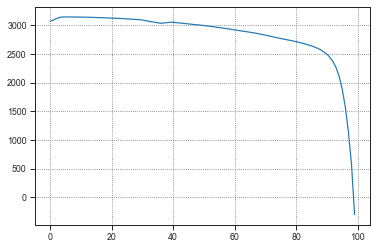

In [53]:
plt.plot(inter)

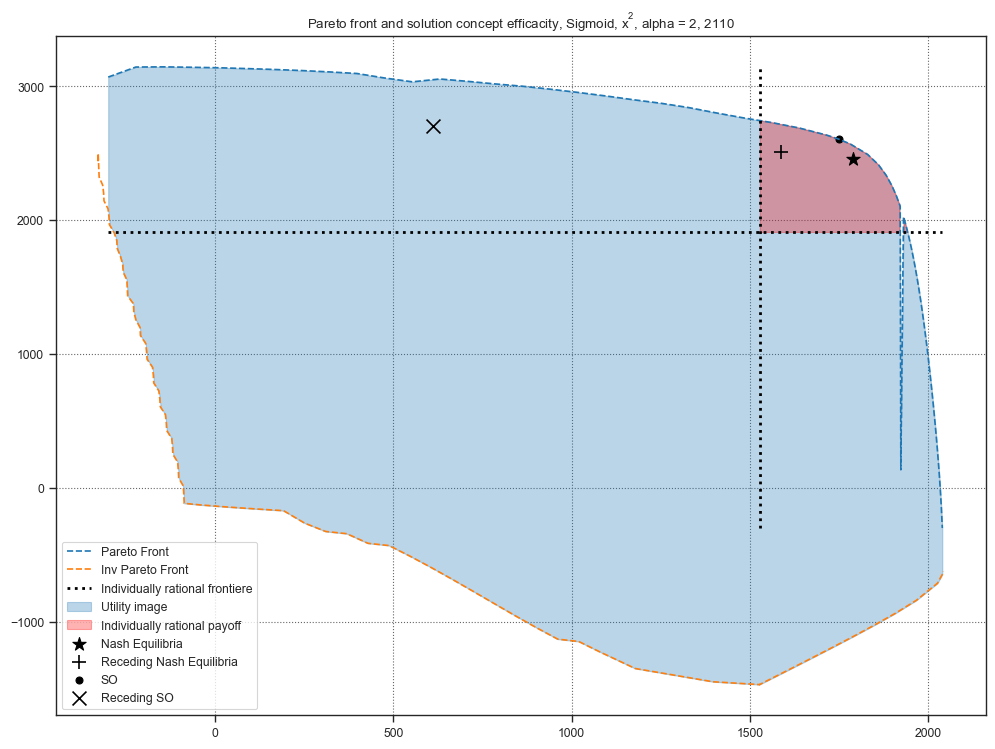

In [54]:
plt.figure( dpi=100, figsize=(12,9))
x = np.linspace(np.min(sorted[:,0]), np.max(sorted[:,0]),1000)

inter = np.interp(x, sorted[:,0], sorted[:,1])
inter_minus = np.interp(x, sorted_minus[:,0], sorted_minus[:,1])


# plt.scatter(arr[:,0], arr[:,1], label='Pareto Front')
# plt.scatter(arr_minus[:,0], arr_minus[:,1], label='Inv Pareto Front')
plt.plot(sorted[:,0], sorted[:,1], ls='--', label='Pareto Front')
plt.plot(sorted_minus[:,0], sorted_minus[:,1], ls='--', label='Inv Pareto Front')
# plt.plot(x, inter)
plt.plot(x, np.ones_like(x)* ir_1,lw=2,ls='dotted', color='black', label='Individually rational frontiere')
plt.plot(np.ones_like(y)* ir_0,y ,lw=2,ls='dotted', color='black')
plt.fill_between(x, inter, inter_minus, alpha=0.3, label='Utility image', color='C0')
plt.fill_between(x, ir_1,inter, where=((x >= ir_0 *np.ones_like(x))  * (inter > ir_1 * np.ones_like(x))), label='Individually rational payoff', color='red', alpha=0.3)
# plt.scatter(u_minus[:,0], u_minus[:,1], c=u_minus_temp[:,16])

plt.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
plt.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
plt.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
plt.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
plt.title('Pareto front and solution concept efficacity, Sigmoid, $x^2$, alpha = 2, {}'.format(horizon))
plt.legend()
plt.show()

In [55]:
l = np.random.random((2,3))
print(l)
print(np.sum(l, axis=0))

[[0.75533081 0.27412365 0.34729761]
 [0.78206579 0.61235675 0.81478067]]
[1.5373966  0.8864804  1.16207828]


In [58]:
np.sum(arr_actions_minus[0],axis=0).shape

(18,)

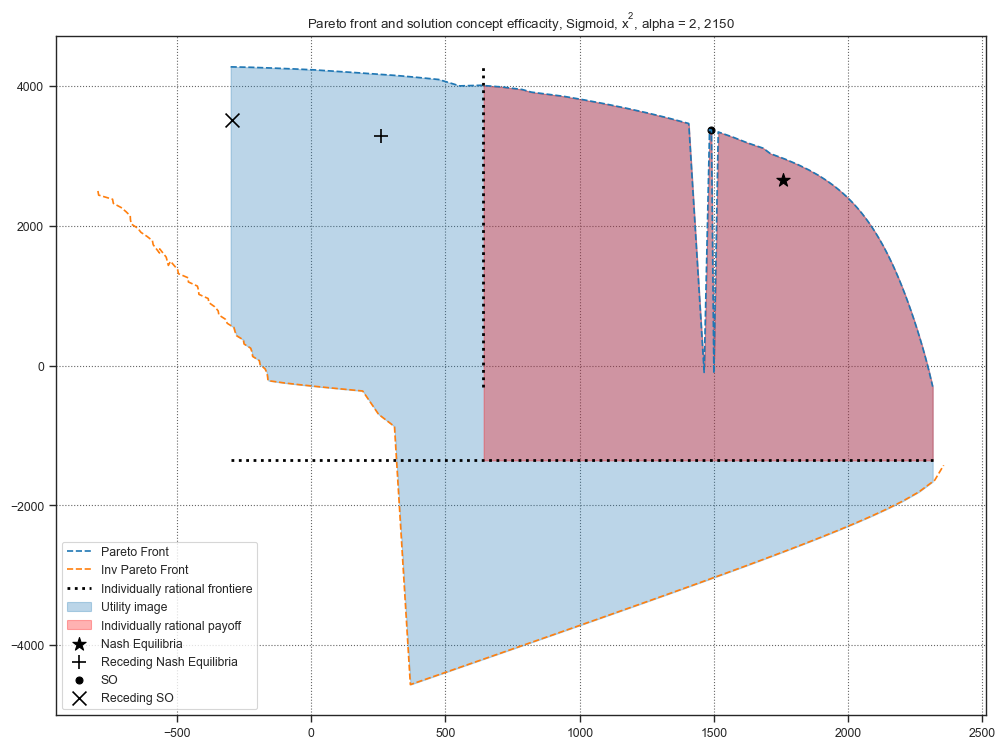

In [ ]:
plt.figure( dpi=100, figsize=(12,9))
x = np.linspace(np.min(sorted[:,0]), np.max(sorted[:,0]),1000)

inter = np.interp(x, sorted[:,0], sorted[:,1])
inter_minus = np.interp(x, sorted_minus[:,0], sorted_minus[:,1])


# plt.scatter(arr[:,0], arr[:,1], label='Pareto Front')
# plt.scatter(arr_minus[:,0], arr_minus[:,1], label='Inv Pareto Front')
plt.plot(sorted[:,0], sorted[:,1], ls='--', label='Pareto Front')
plt.plot(sorted_minus[:,0], sorted_minus[:,1], ls='--', label='Inv Pareto Front')
# plt.plot(x, inter)
plt.plot(x, np.ones_like(x)* ir_1,lw=2,ls='dotted', color='black', label='Individually rational frontiere')
plt.plot(np.ones_like(y)* ir_0,y ,lw=2,ls='dotted', color='black')
plt.fill_between(x, inter, inter_minus, alpha=0.3, label='Utility image', color='C0')
plt.fill_between(x, ir_1,inter, where=((x >= ir_0 *np.ones_like(x))  * (inter > ir_1 * np.ones_like(x))), label='Individually rational payoff', color='red', alpha=0.3)
# plt.scatter(u_minus[:,0], u_minus[:,1], c=u_minus_temp[:,16])

plt.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
plt.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
plt.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
plt.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
plt.title('Pareto front and solution concept efficacity, Sigmoid, $x^2$, alpha = 2, {}'.format(horizon))
plt.legend()
plt.show()

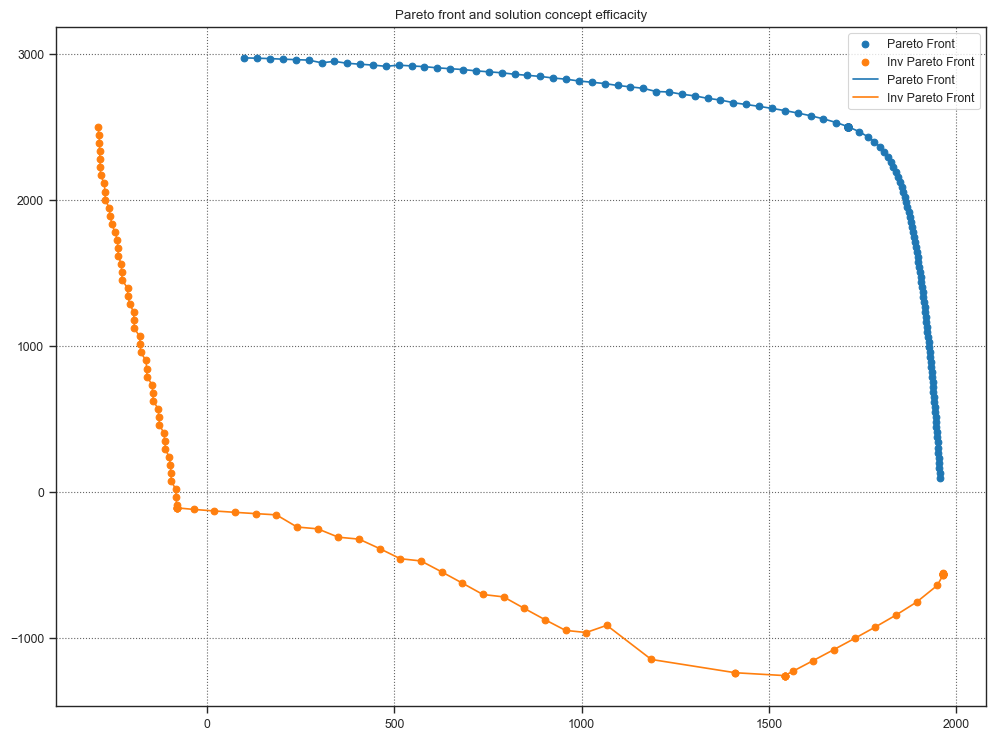

In [ ]:
plt.figure( dpi=100, figsize=(12,9))
plt.scatter(arr[:,0], arr[:,1], label='Pareto Front')
plt.scatter(arr_minus[:,0], arr_minus[:,1], label='Inv Pareto Front')
plt.plot(sorted[:,0], sorted[:,1], label='Pareto Front')
plt.plot(sorted_minus[:,0], sorted_minus[:,1], label='Inv Pareto Front')


# plt.scatter(u_minus[:,0], u_minus[:,1], c=u_minus_temp[:,T-1])

# plt.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
# plt.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
# plt.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
# plt.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
plt.title('Pareto front and solution concept efficacity')
plt.legend()
plt.show()

In [50]:
if np.all(utilities[-1] == utilities[-2]):
    print('ok')

ok


In [42]:
arr

array([[  99.99999991, 2974.79852895],
       [ 169.38775457, 2969.82392012],
       [ 238.77550874, 2962.70669151],
       [ 308.1632659 , 2944.75948449],
       [ 377.55101962, 2937.02819109],
       [ 446.93877525, 2924.47544504],
       [ 516.32653002, 2924.0952237 ],
       [ 585.71428441, 2913.68352979],
       [ 655.10203877, 2899.94460218],
       [ 724.48979553, 2884.65512055],
       [ 793.87755082, 2871.00598529],
       [ 863.26530593, 2853.7771945 ],
       [ 932.65306014, 2834.83641781],
       [1002.04081619, 2814.24667051],
       [1071.42857089, 2796.20683405],
       [1140.81632624, 2773.21633894],
       [1210.20408042, 2736.27935616],
       [1279.59183634, 2721.76845443],
       [1348.97958981, 2693.34831656],
       [1418.36734667, 2663.13517473],
       [1487.75510163, 2637.07375006],
       [1557.14285675, 2606.71096327],
       [1626.5306117 , 2569.16075359],
       [1695.9183666 , 2517.89314178],
       [1709.94776888, 2504.57813712],
       [1709.94776888, 25

In [ ]:
utilities = []
for idx in range(2):
    for val in np.linspace(100,3500,100):
        res = game.planning_SO_by_piece_with_constraint_return(17, constraint_player=idx, constraint_value=val)
        utilities.append(np.sum(res[2], axis=1))
        if len(utilities)>2:
            if np.all(utilities[-1] == utilities[-2]):
                print('passed')
                break


Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


passed


Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:21<00:00, 21.17s/it]


     fun: -2622.8375177084126
     jac: array([  2.30322266, -49.08126831,   2.26367188, -48.65533447,
         2.21325684, -47.57351685,   2.15307617, -46.27929688,
         2.08190918, -44.74990845,   2.00177002, -43.02719116,
         1.91247559, -41.10757446,   1.81549072, -39.02374268,
         1.71026611, -36.76190186,   1.59625244, -34.31149292,
         1.47164917, -31.63259888,   1.33294678, -28.65075684,
         1.17684937, -25.29547119,   0.99899292, -21.47247314,
         0.79388428, -17.0630188 ,   0.55432129, -11.9151001 ,
         0.27685547,  -5.95214844])
 message: 'Positive directional derivative for linesearch'
    nfev: 3589
     nit: 104
    njev: 100
  status: 8
 success: False
       x: array([2.37449610e+01, 1.12412444e-07, 2.38433736e+01, 6.09492888e-02,
       2.39707382e+01, 2.00763919e-01, 2.41263640e+01, 3.62233704e-01,
       2.43151488e+01, 5.46917038e-01, 2.45345112e+01, 7.49250302e-01,
       2.47884551e+01, 9.70069692e-01, 2.50763143e+01, 1.20678171e+

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


     fun: -3084.7553749533868
     jac: array([  2.32476807, -39.21194458,   2.2850647 , -38.54196167,
         2.23446655, -37.6880188 ,   2.17404175, -36.66934204,
         2.10247803, -35.46237183,   2.0218811 , -34.10263062,
         1.93179321, -32.5843811 ,   1.83395386, -30.93313599,
         1.72769165, -29.13983154,   1.61242676, -27.19723511,
         1.48635864, -25.07385254,   1.34613037, -22.70846558,
         1.18838501, -20.04598999,   1.00878906, -17.01382446,
         0.80130005, -13.51730347,   0.55947876,  -9.43832397,
         0.27935791,  -4.71255493])
 message: 'Positive directional derivative for linesearch'
    nfev: 2969
     nit: 87
    njev: 83
  status: 8
 success: False
       x: array([23.5656983 ,  1.08598848, 23.6638746 ,  1.16367354, 23.79109094,
        1.26251081, 23.94648649,  1.38038443, 24.1352681 ,  1.52030202,
       24.35496568,  1.67877404, 24.60922522,  1.8574399 , 24.89786097,
        2.05470951, 25.22702814,  2.27362772, 25.60497955,  2.5179

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:10<00:00, 10.89s/it]


     fun: -3183.0337291353467
     jac: array([  2.32791138, -36.70736694,   2.28817749, -36.08120728,
         2.2376709 , -35.28323364,   2.17721558, -34.33117676,
         2.10562134, -33.20193481,   2.02493286, -31.92984009,
         1.93484497, -30.50930786,   1.83688354, -28.96347046,
         1.73046875, -27.28689575,   1.61508179, -25.46740723,
         1.48886108, -23.47717285,   1.34841919, -21.26150513,
         1.1902771 , -18.76818848,   1.01019287, -15.92892456,
         0.80252075, -12.65509033,   0.56021118,  -8.83395386,
         0.27975464,  -4.41043091])
 message: 'Positive directional derivative for linesearch'
    nfev: 3194
     nit: 93
    njev: 89
  status: 8
 success: False
       x: array([23.51714629,  1.34550477, 23.61529857,  1.41851612, 23.74259095,
        1.51169578, 23.89797745,  1.62330119, 24.08669482,  1.75645172,
       24.30641223,  1.90792326, 24.56084983,  2.07945565, 24.84970028,
        2.26974761, 25.17916877,  2.48153454, 25.55763229,  2.7192

Planning SO, t_piece = 17: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]

passed


In [45]:
np.sum(utilities[-1] - utilities[-2]) == 0

True

In [41]:
arr[-1]- arr[-2]

array([0., 0.])

In [63]:
argsort = arr[:,0].argsort()

In [65]:
sorted = np.zeros_like(arr)
sorted[:,0] = arr[:,0][argsort]
sorted[:,1] = arr[:,1][argsort]

In [66]:
sorted

array([[  99.99999991, 2974.79852895],
       [ 134.34342744, 2972.60873033],
       [ 168.68686841, 2969.89006701],
       [ 203.03030259, 2965.67544175],
       [ 237.37373498, 2962.82932333],
       [ 271.71717156, 2959.52258419],
       [ 306.06060543, 2941.02874908],
       [ 340.40403647, 2950.77945304],
       [ 374.74747381, 2937.60493634],
       [ 409.0909082 , 2930.99696326],
       [ 443.43434262, 2925.11575555],
       [ 477.7777779 , 2917.0065569 ],
       [ 512.12121207, 2924.66791684],
       [ 546.46464539, 2919.85558726],
       [ 580.80807635, 2914.50984306],
       [ 615.15151435, 2906.42015213],
       [ 649.49494881, 2900.89535598],
       [ 683.83838351, 2894.7794863 ],
       [ 718.18181617, 2885.77352859],
       [ 752.52525238, 2879.47975243],
       [ 786.86868662, 2872.5306231 ],
       [ 821.21212078, 2862.60024066],
       [ 855.5555551 , 2855.46904202],
       [ 889.89898919, 2847.60820038],
       [ 924.24242395, 2836.74606429],
       [ 958.58585775, 28

In [64]:
argsort

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  48,  47, 122, 123,  50,
        49, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110,
       109, 108, 107, 106, 105, 104, 103, 102, 101, 100,  99,  98,  97,
        96,  95,  94,  93,  92,  91,  90,  89,  88,  87,  86,  85,  84,
        83,  82,  81,  80,  79,  78,  77,  76,  75,  74,  73,  72,  71,
        70,  69,  68,  67,  66,  65,  64,  63,  62,  61,  60,  59,  58,
        57,  56,  55,  54,  53,  52,  51], dtype=int64)

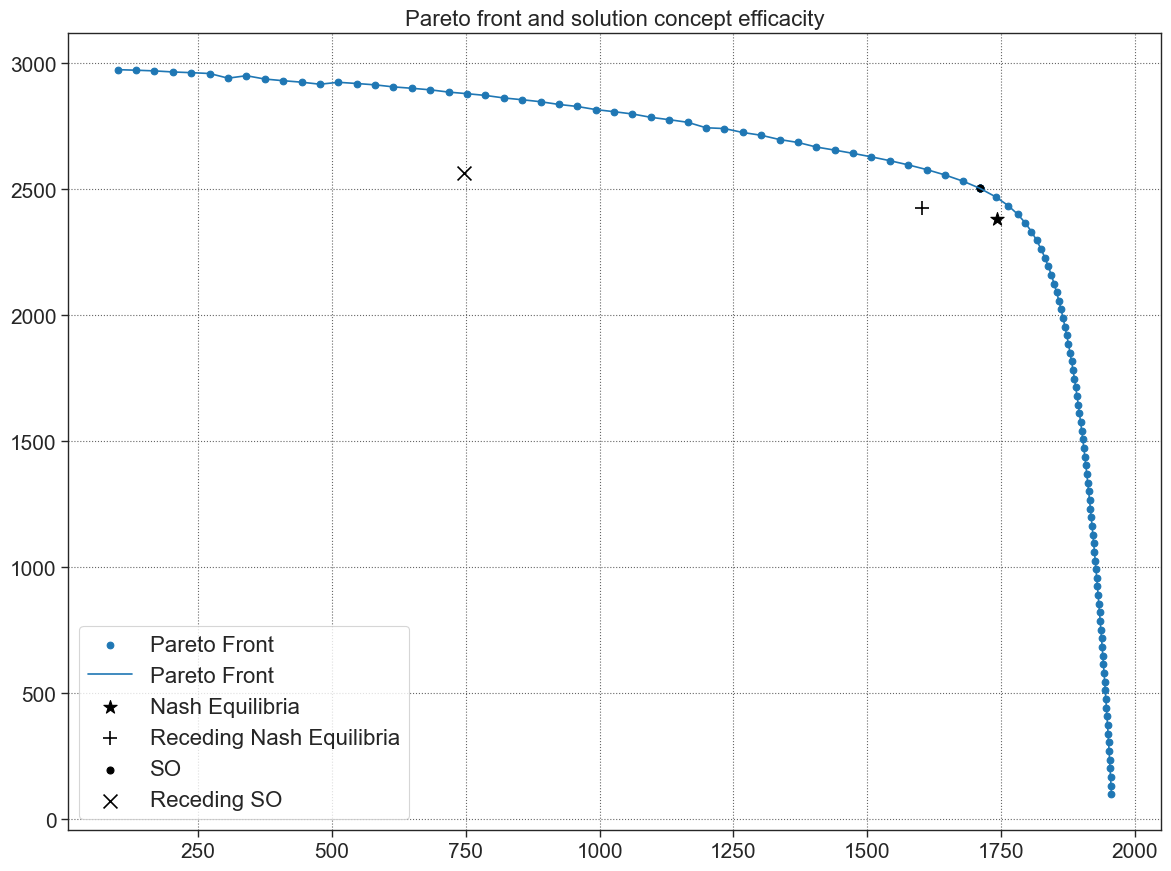

In [67]:
plt.figure( dpi=100, figsize=(12,9))
plt.scatter(arr[:,0], arr[:,1], label='Pareto Front')
plt.plot(sorted[:,0], sorted[:,1], label='Pareto Front')

plt.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
plt.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
plt.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
plt.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
plt.title('Pareto front and solution concept efficacity')
plt.legend()
plt.show()

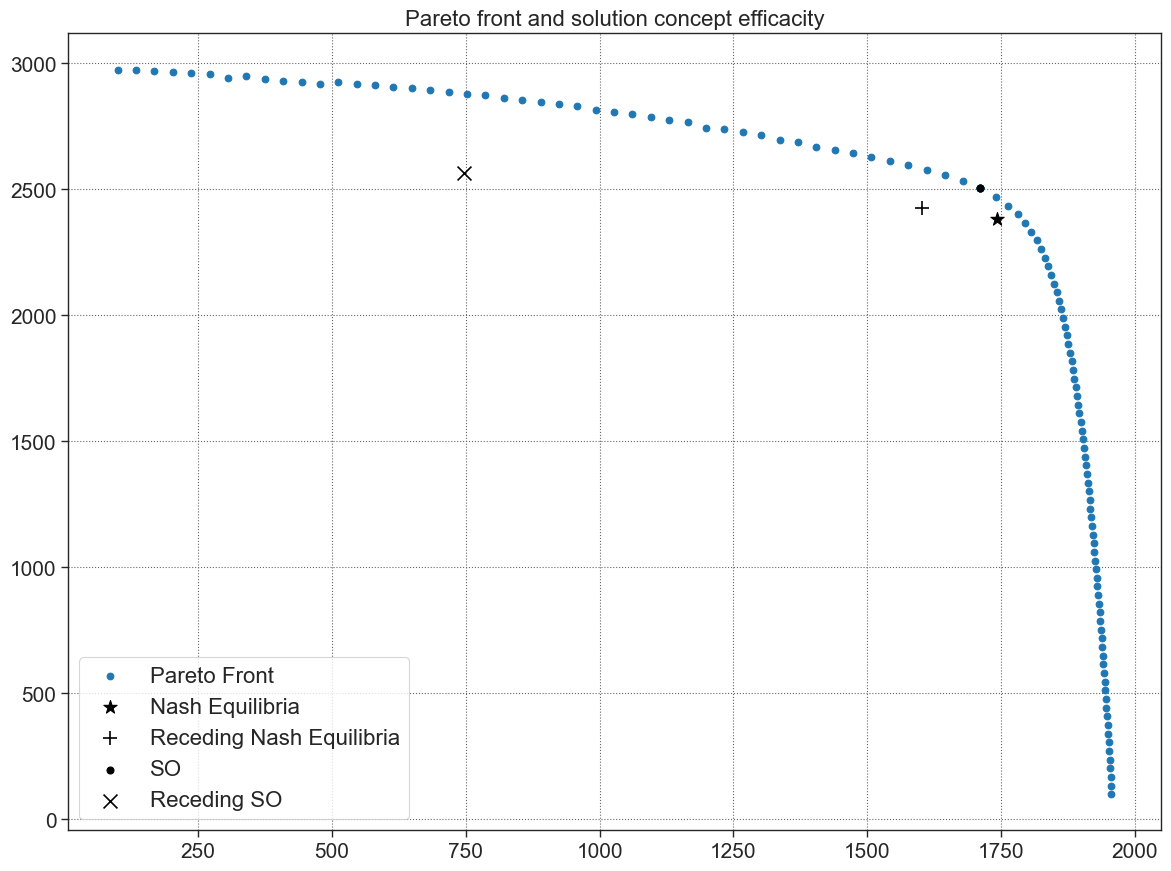

In [ ]:
plt.figure( dpi=100, figsize=(12,9))
plt.scatter(arr[:,0], arr[:,1], label='Pareto Front')

plt.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
plt.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
plt.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
plt.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
plt.title('Pareto front and solution concept efficacity')
plt.legend()
plt.show()

In [19]:
list_players[0].utility_sum_over_t(res[0][0], np.sum(res[0], axis =0)-res[0][0]) 

699.999999916701

In [14]:
list_players[1].utility_sum_over_t(res[0][1], np.sum(res[0], axis =0)) 

2633.4853248495824

In [5]:
game.list_players

# Action randomized

In [6]:
k = 10
num_sample = 100000

In [8]:
ACTION_SETS

array([[[ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94],
        [ 0.  , 22.94]],

       [[ 0.  , 10.02],
        [ 0.  , 10.02],
        [ 0.  , 10.02],
        [ 0.  , 10.02],
        [ 0.  , 10.02],
        [ 0.  , 10.02],
        [ 0.  , 10.02],
        [ 0.  , 10.02],
        [ 0.  , 10.02],
        [ 0.  

In [9]:
lower_bounds = np.copy(ACTION_SETS[:,:T,:][..., 0])
upper_bounds = np.copy(ACTION_SETS[:,:T,:][..., 1])

In [9]:
from itertools import zip_longest
import numpy as np

def invNormal(low : np.ndarray, high : np.ndarray, loc = None, scale=1, *, size=1, block_size=1024, random_state=None):
    remain = size
    result = []
    if not loc:
        loc = (high + low) / 2
    
    mul = -0.5 * scale**-2

    while remain:
        # draw next block of uniform variates within interval
        x = np.random.uniform(low, high, size=min((remain+5)*2, block_size))
        
        # reject proportional to normal density
        x = x[np.exp(mul*(x-loc)**2) < np.random.rand(*x.shape)]
        
        # make sure we don't add too much
        if remain < len(x):
            x = x[:remain]

        result.append(x)
        remain -= len(x)

    return np.concatenate(result)

def _check_shape(argshape, size):
    """
    This is a utility function used by `_rvs()` in the class geninvgauss_gen.
    It compares the tuple argshape to the tuple size.

    Parameters
    ----------
    argshape : tuple of integers
        Shape of the arguments.
    size : tuple of integers or integer
        Size argument of rvs().

    Returns
    -------
    The function returns two tuples, scalar_shape and bc.

    scalar_shape : tuple
        Shape to which the 1-d array of random variates returned by
        _rvs_scalar() is converted when it is copied into the
        output array of _rvs().

    bc : tuple of booleans
        bc is an tuple the same length as size. bc[j] is True if the data
        associated with that index is generated in one call of _rvs_scalar().

    """
    scalar_shape = []
    bc = []
    for argdim, sizedim in zip_longest(argshape[::-1], size[::-1],
                                       fillvalue=1):
        if sizedim > argdim or (argdim == sizedim == 1):
            scalar_shape.append(sizedim)
            bc.append(True)
        else:
            bc.append(False)
    return tuple(scalar_shape[::-1]), tuple(bc[::-1])

def invNormal_rvs(a, b, loc = None, scale = 1, size=None, random_state=None):
    # if a and b are scalar, use _rvs_scalar, otherwise need to create
    # output by iterating over parameters
    if np.isscalar(a) and np.isscalar(b):
        out = invNormal(a, b, size, random_state=random_state)
    elif a.size == 1 and b.size == 1:
        out = invNormal(a.item(), b.item(), size,
                                random_state=random_state)
    else:
        # When this method is called, size will be a (possibly empty)
        # tuple of integers.  It will not be None; if `size=None` is passed
        # to `rvs()`, size will be the empty tuple ().

        a, b = np.broadcast_arrays(a, b)
        # a and b now have the same shape.

        # `shp` is the shape of the blocks of random variates that are
        # generated for each combination of parameters associated with
        # broadcasting a and b.
        # bc is a tuple the same length as size.  The values
        # in bc are bools.  If bc[j] is True, it means that
        # entire axis is filled in for a given combination of the
        # broadcast arguments.
        shp, bc = _check_shape(a.shape, size)

        # `numsamples` is the total number of variates to be generated
        # for each combination of the input arguments.
        numsamples = int(np.prod(shp))

        # `out` is the array to be returned.  It is filled in in the
        # loop below.
        out = np.empty(size)

        it = np.nditer([a, b],
                        flags=['multi_index'],
                        op_flags=[['readonly'], ['readonly']])
        while not it.finished:
            # Convert the iterator's multi_index into an index into the
            # `out` array where the call to _rvs_scalar() will be stored.
            # Where bc is True, we use a full slice; otherwise we use the
            # index value from it.multi_index.  len(it.multi_index) might
            # be less than len(bc), and in that case we want to align these
            # two sequences to the right, so the loop variable j runs from
            # -len(size) to 0.  This doesn't cause an IndexError, as
            # bc[j] will be True in those cases where it.multi_index[j]
            # would cause an IndexError.
            idx = tuple((it.multi_index[j] if not bc[j] else slice(None))
                        for j in range(-len(size), 0))
            out[idx] =  invNormal(it[0], it[1], loc=loc, scale=scale, size=numsamples,
                                        random_state = random_state).reshape(shp)
            it.iternext()

    if size == ():
        out = out.item()
    return out

In [10]:
from itertools import zip_longest
import numpy as np
from scipy.stats import norm

def truncNormal(low : np.ndarray, high : np.ndarray, loc = 0, scale=1, *, size=1, block_size=1024, random_state=None):
    remain = size
    result = []

    while remain:
        # draw next block of uniform variates within interval
        x = np.random.normal(loc=loc, scale=scale, size=block_size)
        
        # reject proportional to normal density
        x = x[low < x]
        x = x[x <high]
        # make sure we don't add too much
        if remain < len(x):
            x = x[:remain]

        result.append(x)
        remain -= len(x)

    return np.concatenate(result)

def _check_shape(argshape, size):
    """
    This is a utility function used by `_rvs()` in the class geninvgauss_gen.
    It compares the tuple argshape to the tuple size.

    Parameters
    ----------
    argshape : tuple of integers
        Shape of the arguments.
    size : tuple of integers or integer
        Size argument of rvs().

    Returns
    -------
    The function returns two tuples, scalar_shape and bc.

    scalar_shape : tuple
        Shape to which the 1-d array of random variates returned by
        _rvs_scalar() is converted when it is copied into the
        output array of _rvs().

    bc : tuple of booleans
        bc is an tuple the same length as size. bc[j] is True if the data
        associated with that index is generated in one call of _rvs_scalar().

    """
    scalar_shape = []
    bc = []
    for argdim, sizedim in zip_longest(argshape[::-1], size[::-1],
                                       fillvalue=1):
        if sizedim > argdim or (argdim == sizedim == 1):
            scalar_shape.append(sizedim)
            bc.append(True)
        else:
            bc.append(False)
    return tuple(scalar_shape[::-1]), tuple(bc[::-1])

def truncNormal_rvs(a, b, loc = None, scale = 1, size=None, random_state=None):
    # if a and b are scalar, use _rvs_scalar, otherwise need to create
    # output by iterating over parameters
    if np.isscalar(a) and np.isscalar(b):
        out = truncNormal(a, b, size, random_state=random_state)
    elif a.size == 1 and b.size == 1:
        out = truncNormal(a.item(), b.item(), size,
                                random_state=random_state)
    else:
        # When this method is called, size will be a (possibly empty)
        # tuple of integers.  It will not be None; if `size=None` is passed
        # to `rvs()`, size will be the empty tuple ().

        a, b = np.broadcast_arrays(a, b)
        # a and b now have the same shape.

        # `shp` is the shape of the blocks of random variates that are
        # generated for each combination of parameters associated with
        # broadcasting a and b.
        # bc is a tuple the same length as size.  The values
        # in bc are bools.  If bc[j] is True, it means that
        # entire axis is filled in for a given combination of the
        # broadcast arguments.
        shp, bc = _check_shape(a.shape, size)

        # `numsamples` is the total number of variates to be generated
        # for each combination of the input arguments.
        numsamples = int(np.prod(shp))

        # `out` is the array to be returned.  It is filled in in the
        # loop below.
        out = np.empty(size)

        it = np.nditer([a, b],
                        flags=['multi_index'],
                        op_flags=[['readonly'], ['readonly']])
        while not it.finished:
            # Convert the iterator's multi_index into an index into the
            # `out` array where the call to _rvs_scalar() will be stored.
            # Where bc is True, we use a full slice; otherwise we use the
            # index value from it.multi_index.  len(it.multi_index) might
            # be less than len(bc), and in that case we want to align these
            # two sequences to the right, so the loop variable j runs from
            # -len(size) to 0.  This doesn't cause an IndexError, as
            # bc[j] will be True in those cases where it.multi_index[j]
            # would cause an IndexError.
            idx = tuple((it.multi_index[j] if not bc[j] else slice(None))
                        for j in range(-len(size), 0))
            out[idx] =  truncNormal(it[0], it[1], loc=loc, scale=scale, size=numsamples,
                                        random_state = random_state).reshape(shp)
            it.iternext()

    if size == ():
        out = out.item()
    return out

In [5]:
from scipy.stats import norm
from ipywidgets import interact

def f(a,b,loc, scale):
    rv = norm(loc= loc, scale=scale)
    remain = 10000
    epoch = 1024
    vector = []
    while remain>0:
        
        vect = norm.rvs( loc= loc, scale=scale, size=epoch)
        vect = vect[ a < vect]
        vect = vect[vect < b]
        if len(vect) >remain:
            vect = vect[:remain]
        vector.append(vect)
        remain -= min(len(vect), epoch)

    vector = np.concatenate(vector)

    x = np.linspace(a,b)
    plt.plot(x, rv.pdf(x))
    plt.hist(norm.rvs( loc=loc, scale=scale, size=10000), bins=50, density=True, alpha= 0.5)
    plt.hist(vector, bins=50, density=True, alpha=0.5)
interact(f, a=(-12,10),b= (-10,10),loc=(-10,10),scale=(1,3))

interactive(children=(IntSlider(value=-1, description='a', max=10, min=-12), IntSlider(value=0, description='b…

<function __main__.f(a, b, loc, scale)>

In [11]:
from scipy.stats import truncnorm


# Generate random vectors within the specified bounds

n_row = 1
n_col = 2
size = 100_001


a = lower_bounds
b = upper_bounds
lam = 1/2
loc = lam * np.array([a[0], b[1]]) + (1-lam) * np.array([b[0], a[1]]) 
scale = 3
random_vector = truncnorm.rvs(a=a, b=b, loc= loc, scale=scale, size=(size, N, T))

plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=(12,9))
t = 0
k = 0
for row in range(n_row):
    for col in range(n_col):
        axes[col].hist(random_vector[:,k,t], bins=30,  alpha=0.7, density=True)
        x = np.linspace(ACTION_SETS[k,t,0],ACTION_SETS[k,t,1])
        rv = truncnorm(b=b[k,t], a=a[k,t], loc = loc[k,t], scale=scale)
        print(x.shape)
        axes[col].plot(x, rv.pdf(x), lw=2)
        k += 1
fig.supylabel('Probability of Action')
fig.supxlabel('Action set')

fig.suptitle('For t = {}'.format(t +1))

plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [342]:
random_vector.shape

(100000, 2, 17)

In [13]:
ACTION_SETS[:,:T,:].shape

(2, 16, 2)

In [75]:
(size, ACTION_SETS[:,:T,:].shape[0], ACTION_SETS[:,:T,:].shape[1])

(100000, 2, 17)

In [12]:
n_row = 1
n_col = 2
size = 1_0000

def f (lam):
    loc = lam * np.array([lower_bounds[0,0], upper_bounds[1,0]]) + (1 - lam) * np.array([upper_bounds[0,0], lower_bounds[1,0]])
    random_vector = truncNormal_rvs(lower_bounds[0], upper_bounds[0], loc=loc[0], scale= 2, size=(size, ACTION_SETS[:,:T,:].shape[1]))
    random_vector2 = truncNormal_rvs(lower_bounds[1], upper_bounds[1], loc=loc[1], scale= 2, size=(size,  ACTION_SETS[:,:T,:].shape[1]))

    random_vector = np.stack((random_vector,random_vector2), axis=1)

    plt.rcParams["figure.autolayout"] = True

    fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=(12,9))
    t = 0
    k = 0
    for row in range(n_row):
        for col in range(n_col):
            axes[col].hist(random_vector[:,k,t], bins=100,  alpha=0.7, density=True)
            k += 1
    fig.supylabel('Probability of Action')
    fig.supxlabel('Action set')

    fig.suptitle('For t = {}'.format(t +1))

    plt.show()

interact(f, lam=(0,1,0.01))

interactive(children=(FloatSlider(value=0.0, description='lam', max=1.0, step=0.01), Output()), _dom_classes=(…

<function __main__.f(lam)>

In [12]:
scale =2

In [13]:
def genererate_proportional(lam):
    loc = lam * np.array([lower_bounds[0,0], lower_bounds[1,0]]) + (1 - lam) * np.array([upper_bounds[0,0], upper_bounds[1,0]])
    random_vector = truncNormal_rvs(lower_bounds[0], upper_bounds[0], loc=loc[0], scale= scale, size=(size, ACTION_SETS[:,:T,:].shape[1]))
    random_vector2 = truncNormal_rvs(lower_bounds[1], upper_bounds[1], loc=loc[1], scale= scale, size=(size,  ACTION_SETS[:,:T,:].shape[1]))

    random_vector = np.stack((random_vector,random_vector2), axis=1)
    return random_vector

In [14]:
def genererate_symetry(lam):
    loc = lam * np.array([lower_bounds[0,0], upper_bounds[1,0]]) + (1 - lam) * np.array([upper_bounds[0,0], lower_bounds[1,0]])
    random_vector = truncNormal_rvs(lower_bounds[0], upper_bounds[0], loc=loc[0], scale= scale, size=(size, ACTION_SETS[:,:T,:].shape[1]))
    random_vector2 = truncNormal_rvs(lower_bounds[1], upper_bounds[1], loc=loc[1], scale= scale, size=(size,  ACTION_SETS[:,:T,:].shape[1]))

    random_vector = np.stack((random_vector,random_vector2), axis=1)
    return random_vector

In [15]:
scale = 2
size = 1_000
x= np.concatenate([np.concatenate([genererate_proportional(lam), genererate_symetry(lam)]) for lam in np.linspace(.6,0.7,30, endpoint=True)])


In [32]:
x= np.concatenate([genererate_symetry(lam) for lam in np.linspace(.1,.9,100, endpoint=True)])


In [25]:
x= np.concatenate([genererate_proportional(lam) for lam in np.linspace(.5,.9,100, endpoint=True)])


In [16]:
x.shape

(60000, 2, 16)

In [88]:
def test(lam):
    def f(alpha, x):
        return alpha * x
    
    fig, axes = plt.subplots(2)
    alpha = lam * np.array([2,-2]) + (1-lam ) * np.array([-2,5])
    x = np.linspace(-1,1)
    axes[0].plot(x, f(alpha[0] ,x))
    axes[1].plot(x, f(alpha[1], x))
    plt.show()

interact(test, lam=(0,1,0.1))

interactive(children=(FloatSlider(value=0.0, description='lam', max=1.0), Output()), _dom_classes=('widget-int…

<function __main__.test(lam)>

IndexError: index 2 is out of bounds for axis 1 with size 2

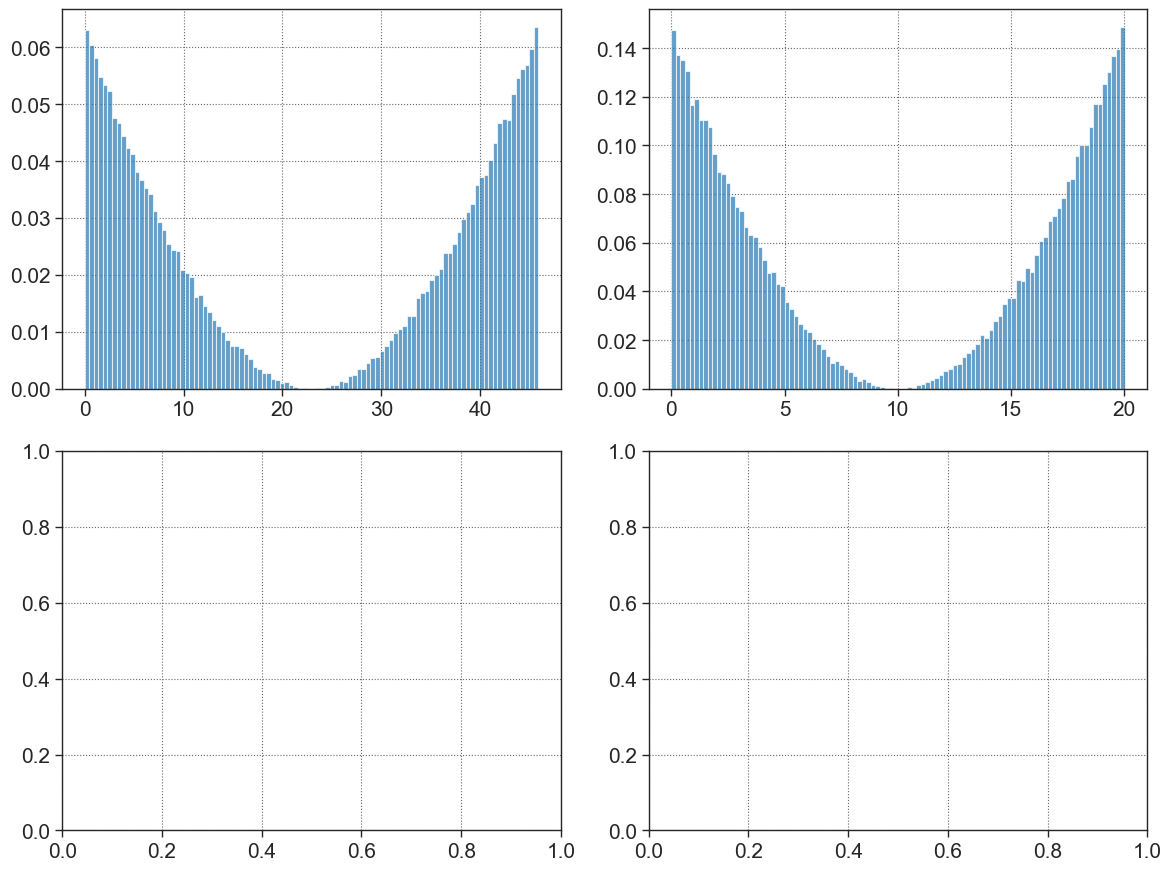

In [338]:
n_row = 2
n_col = 2
size = 100_000
random_vector = invNormal_rvs(lower_bounds, upper_bounds, scale= 60, size=(size, ACTION_SETS[:,:T,:].shape[0], ACTION_SETS[:,:T,:].shape[1]))

plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=(12,9))
t = 0
k = 0
for row in range(n_row):
    for col in range(n_col):
        axes[row, col].hist(random_vector[:,k,t], bins=100,  alpha=0.7, density=True)
        k += 1
fig.supylabel('Probability of Action')
fig.supxlabel('Action set')

fig.suptitle('For t = {}'.format(t +1))

plt.show()


IndexError: index 2 is out of bounds for axis 1 with size 2

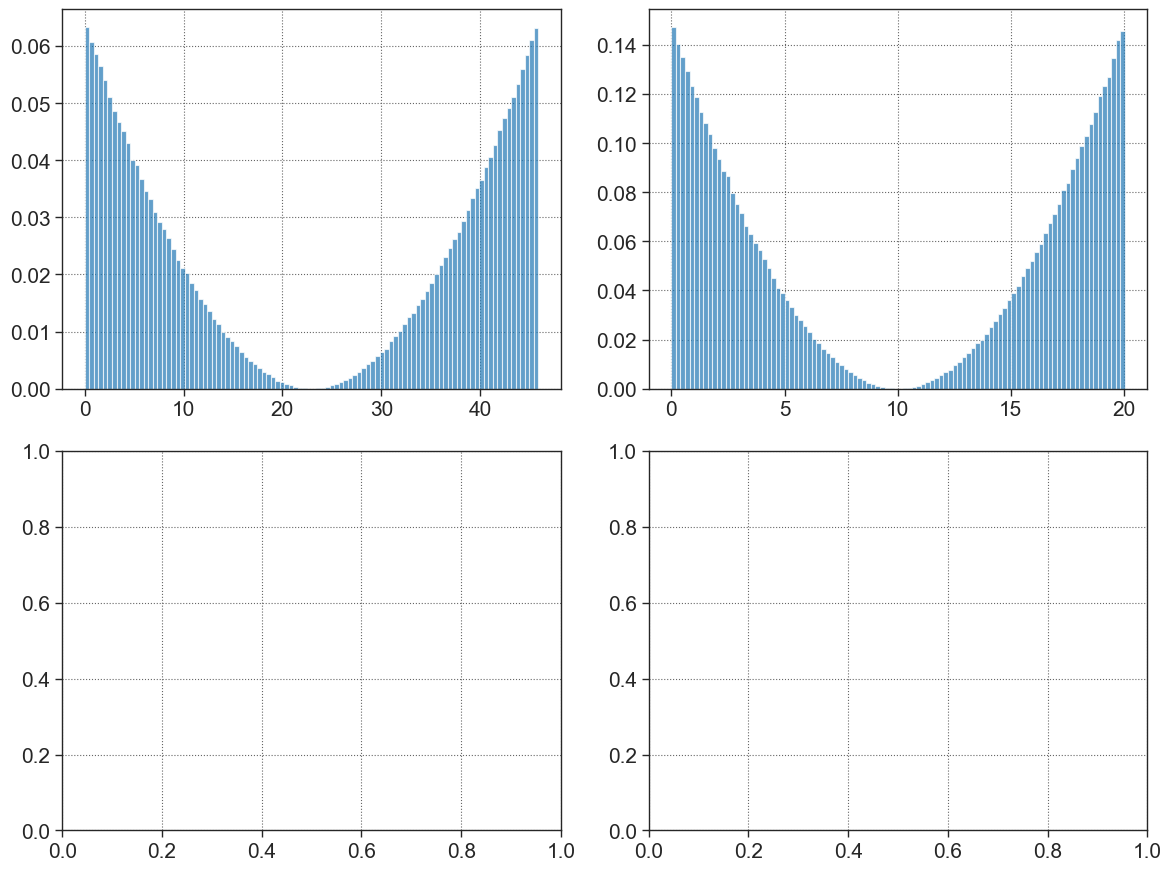

In [ ]:
n_row = 2
n_col = 2
size = 100_000
random_vector = invNormal_rvs(lower_bounds, upper_bounds, scale= 60, size=(size, ACTION_SETS[:,:T,:].shape[0], ACTION_SETS[:,:T,:].shape[1]))

plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=(12,9))
t = 0
k = 0
for row in range(n_row):
    for col in range(n_col):
        axes[row, col].hist(random_vector[:,k,t], bins=100,  alpha=0.7, density=True)
        k += 1
fig.supylabel('Probability of Action')
fig.supxlabel('Action set')

fig.suptitle('For t = {}'.format(t +1))

plt.show()


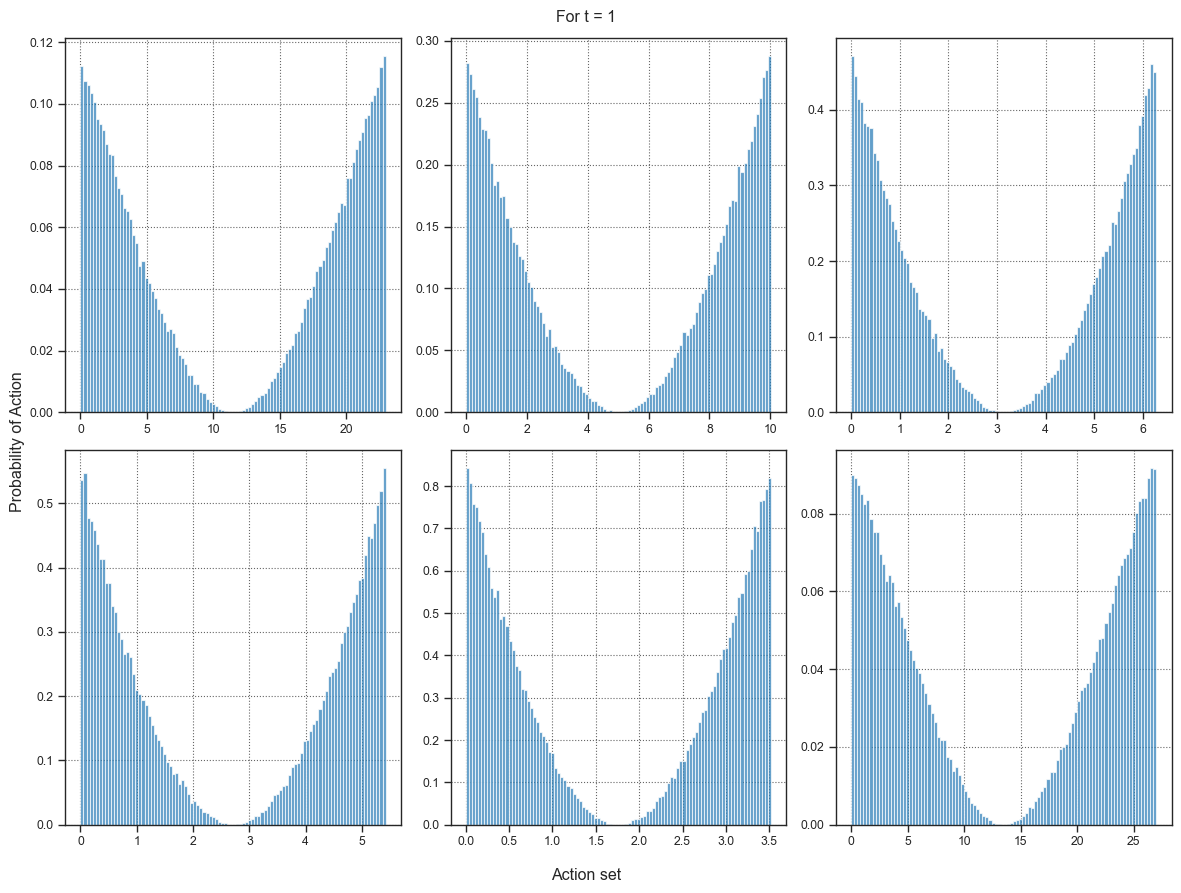

In [ ]:
n_row = 2
n_col = 3
size = 100000
random_vector = invNormal_rvs(lower_bounds, upper_bounds, scale= 10, size=(size, ACTION_SETS[:,:T,:].shape[0], ACTION_SETS[:,:T,:].shape[1]))

plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=(12,9))
t = 0
k = 0
for row in range(n_row):
    for col in range(n_col):
        axes[row, col].hist(random_vector[:,k,t], bins=100,  alpha=0.7, density=True)
        k += 1
fig.supylabel('Probability of Action')
fig.supxlabel('Action set')

fig.suptitle('For t = {}'.format(t +1))

plt.show()


In [21]:
game.game_with_strategies_profile(random_vector[0], 0*np.sum(random_vector, axis = 1)[10])

NameError: name 'random_vector' is not defined

In [26]:
def process(list_strategy_profile, game : Game) : 
    data_utilities = []
    data_temp = []
    list_sum_strategy = np.sum(list_strategy_profile, axis=1)
    list_ = list(zip(list_strategy_profile,list_sum_strategy))
    for strategy, sum_ in tqdm(list_, total = len(list_), desc ='Processing'):
        u,temp = game.game_with_strategies_profile(strategy,sum_)
        data_utilities.append(u)
        data_temp.append(temp)
    return np.array(data_utilities), np.array(data_temp)

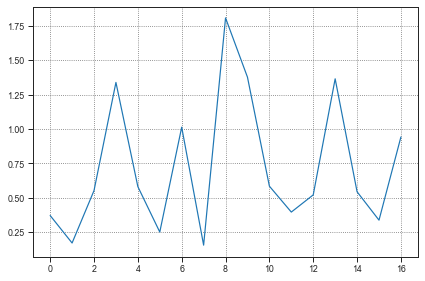

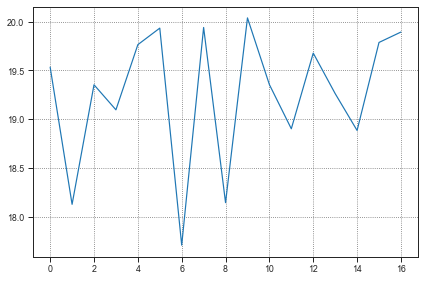

In [110]:
for k in range(2):
    plt.plot(random_vector[0][k])
    plt.show()

In [12]:
alpha = list_alpha[0]
benef = list_list_benefit_functions[0]
coef = list_damage_coef[0]

In [13]:
list_players = create_players(alpha=alpha, list_action_sets=ACTION_SETS, list_of_names=NAMES, list_benefit_functions=benef, damage_function=damage_polynome(coef), discount=1)

game = Game(list_players, horizon=horizon)

In [14]:
game.reset()
a_, sum_a_, u_, sum_u_, temp_ = game.receding_BRD_by_piece_return(1)
game.reset()
a_so, sum_a_so, u_so, sum_u_so, temp_so = game.planning_SO_by_piece_return(1)

game.reset()
a_rece, sum_a_rece, u_rece, sum_u_rece, temp_rece = game.receding_BRD_by_piece_return(T)
game.reset()
a_plan, sum_a_plan, u_plan, sum_u_plan, temp_plan = game.planning_BRD_by_piece_return(T)

game.reset()
a_plan_so, sum_a_plan_so, u_plan_so, sum_u_plan_so, temp_plan_so = game.planning_SO_by_piece_return(T)
game.reset()
a_rece_so, sum_a_rece_so, u_rece_so, sum_u_rece_so, temp_rece_so = game.receding_SO_by_piece_return(T)

u_p = np.sum(u_plan, axis=1)
u_r = np.sum(u_rece, axis=1)
u_p_so = np.sum(u_plan_so, axis =1)
u_r_so = np.sum(u_rece_so, axis =1)

Receding SO, t_piece = 16: 100%|██████████| 16/16 [00:39<00:00,  2.46s/it]


In [15]:
def generate_perturbation(action, lower_bounds=lower_bounds, upper_bounds=upper_bounds, size=5000, scale=.05):
    shape = action.shape
    perturbation = stats.norm.rvs(loc = 0, scale=scale, size=(size,*shape))
    # perturbation = truncNormal_rvs(action - lower_bounds, upper_bounds - action, loc=0, scale= scale, size=(size, *shape))
    arr = action + perturbation
    res = np.where(arr < upper_bounds, arr, upper_bounds)
    res = np.where(res > lower_bounds, res, lower_bounds)
    return res

In [16]:
x = np.concatenate([np.concatenate([generate_perturbation(a_, scale=scale), generate_perturbation(a_so, scale=scale), generate_perturbation(a_plan_so, scale=scale), generate_perturbation(a_plan, scale=scale), generate_perturbation(a_rece, scale=scale), generate_perturbation(a_rece_so, scale=scale)]) for scale in [0.05, 0.15, 0.5, 1, 1.5 ,2]])

In [17]:
x.shape

(180000, 6, 16)

In [19]:
x[0].shape

(6, 16)

In [20]:
p = np.where(x < upper_bounds, x, upper_bounds)
p = np.where(p > lower_bounds, p, lower_bounds)


In [21]:
for l in x :
    if (upper_bounds < l).any() :
        print( upper_bounds - l ) 

In [22]:
game.reset()
data_u, data_t = process(x, game)


Processing: 100%|██████████| 180000/180000 [03:37<00:00, 828.88it/s] 


In [26]:
print(data_u.shape)
print(np.sum(data_u, axis = 1).shape)

(180000, 6)
(180000,)


In [28]:
sum_u_vs = np.sum(data_u, axis = 1)
temp_vs =  data_t[:,T-1]

In [29]:
u__ = np.sum(u_, axis=1)

u_so_ = np.sum(u_so, axis =1)

u_p = np.sum(u_plan, axis=1)
u_r = np.sum(u_rece, axis=1)
u_p_so = np.sum(u_plan_so, axis =1)
u_r_so = np.sum(u_rece_so, axis =1)

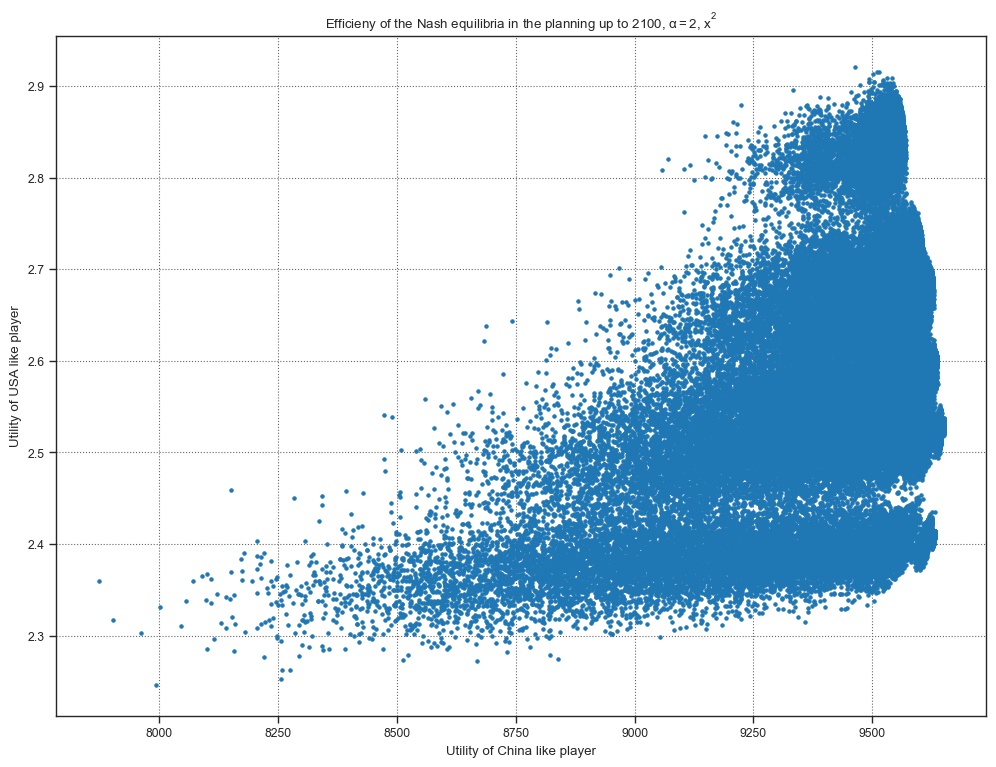

In [32]:
fig = plt.figure(dpi = 100, figsize=(12,9))
ax = fig.gca()
p = ax.scatter(sum_u_vs, temp_vs, marker='.',)
# ax[0] =  sns.kdeplot(x=data_u[:,0], y=data_u[:,1], hue=data_t[:,T-1], warn_singular=False)

# cbar = fig.colorbar(p)

# ax.scatter(u__[0], u__[1], marker='^', c='black', s=100, label='Repeated one-shot NE')
# ax.scatter(u_so_[0], u_so_[1], marker='v', c='black', s=100, label='Repeated one-shot SO')

# ax.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Planning NE')
# ax.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding NE')
# ax.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='Planning SO')
# ax.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
# x_s = cbar.ax.set_xlim()
# x_s = sum(x_s)/2
# ax.legend()
# cbar.ax.scatter(x_s,temp_[T-1], marker='^',c='black', s=100, label='Repeated one-shot NE')
# cbar.ax.scatter(x_s,temp_so[T-1], marker='v',c='black', s=100, label='Repeated one-shot SO')

# cbar.set_label('Temperature variation', rotation=270, labelpad=20)
# cbar.ax.scatter(x_s,temp_plan[T-1], marker='*', c='black', s=100, label='Nash Equilibria')
# cbar.ax.scatter(x_s,temp_rece[T-1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
# cbar.ax.scatter(x_s,temp_plan_so[T-1], marker='.',c='black', s=100, label='SO')
# cbar.ax.scatter(x_s,temp_rece_so[T-1], marker='x',c='black', s=100, label='Receding SO')

plt.xlabel('Utility of China like player')
plt.ylabel('Utility of USA like player')
plt.title('Efficieny of the Nash equilibria in the planning up to {}, $\\alpha = 2$, $x^2$'.format(horizon))
plt.savefig('journal/Efficiency' + '.pdf', format='pdf')
plt.show()

In [49]:
u__ = np.sum(u_, axis=1)

u_so_ = np.sum(u_so, axis =1)

u_p = np.sum(u_plan, axis=1)
u_r = np.sum(u_rece, axis=1)
u_p_so = np.sum(u_plan_so, axis =1)
u_r_so = np.sum(u_rece_so, axis =1)

In [46]:
sns.set_style('ticks',  {"axes.grid" : "True", "grid.color": ".4", "grid.linestyle": ":"})
sns.set_context('paper')
plt.rcParams.update({'mathtext.default':  'regular' })
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.labelsize']  =15
plt.rcParams['xtick.labelsize']  =15
plt.rcParams['legend.fontsize']  = 16
plt.rcParams['axes.labelsize' ] = 16
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams["figure.autolayout"] = True


C:\Users\Anthony Couthures\AppData\Local\Temp\ipykernel_29264\765810087.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(p)


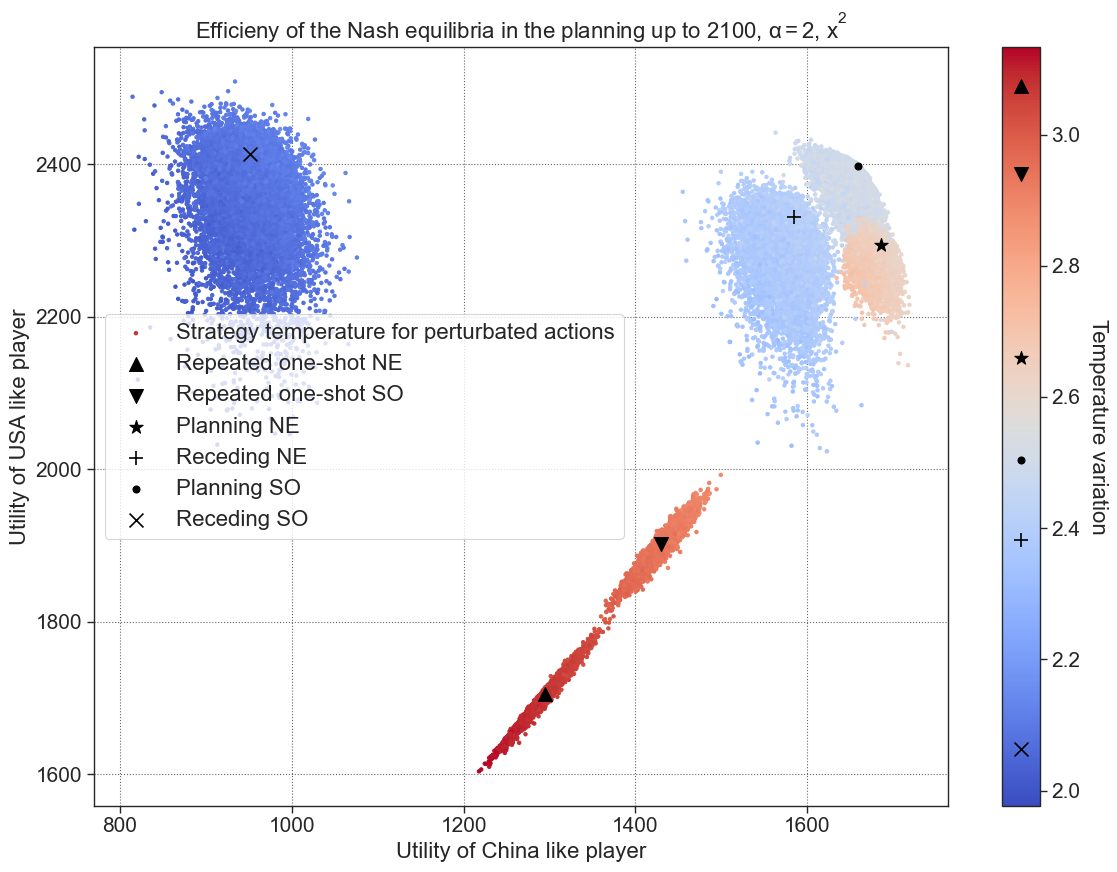

In [64]:
fig = plt.figure(dpi = 100, figsize=(12,9))
ax = fig.gca()
p = ax.scatter(data_u[:,0], data_u[:,1], c=data_t[:,T-1],cmap='coolwarm', marker='.', label='Strategy temperature for perturbated actions')
# ax[0] =  sns.kdeplot(x=data_u[:,0], y=data_u[:,1], hue=data_t[:,T-1], warn_singular=False)

cbar = fig.colorbar(p)

ax.scatter(u__[0], u__[1], marker='^', c='black', s=100, label='Repeated one-shot NE')
ax.scatter(u_so_[0], u_so_[1], marker='v', c='black', s=100, label='Repeated one-shot SO')

ax.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Planning NE')
ax.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding NE')
ax.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='Planning SO')
ax.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
ax.legend()
cbar.ax.scatter(x_s,temp_[T-1], marker='^',c='black', s=100, label='Repeated one-shot NE')
cbar.ax.scatter(x_s,temp_so[T-1], marker='v',c='black', s=100, label='Repeated one-shot SO')

cbar.set_label('Temperature variation', rotation=270, labelpad=20)
cbar.ax.scatter(x_s,temp_plan[T-1], marker='*', c='black', s=100, label='Nash Equilibria')
cbar.ax.scatter(x_s,temp_rece[T-1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
cbar.ax.scatter(x_s,temp_plan_so[T-1], marker='.',c='black', s=100, label='SO')
cbar.ax.scatter(x_s,temp_rece_so[T-1], marker='x',c='black', s=100, label='Receding SO')

plt.xlabel('Utility of China like player')
plt.ylabel('Utility of USA like player')
plt.title('Efficieny of the Nash equilibria in the planning up to {}, $\\alpha = 2$, $x^2$'.format(horizon))
plt.savefig('journal/Efficiency' + '.pdf', format='pdf')
plt.show()

C:\Users\Anthony Couthures\AppData\Local\Temp\ipykernel_18208\2719120300.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(p)


0.5


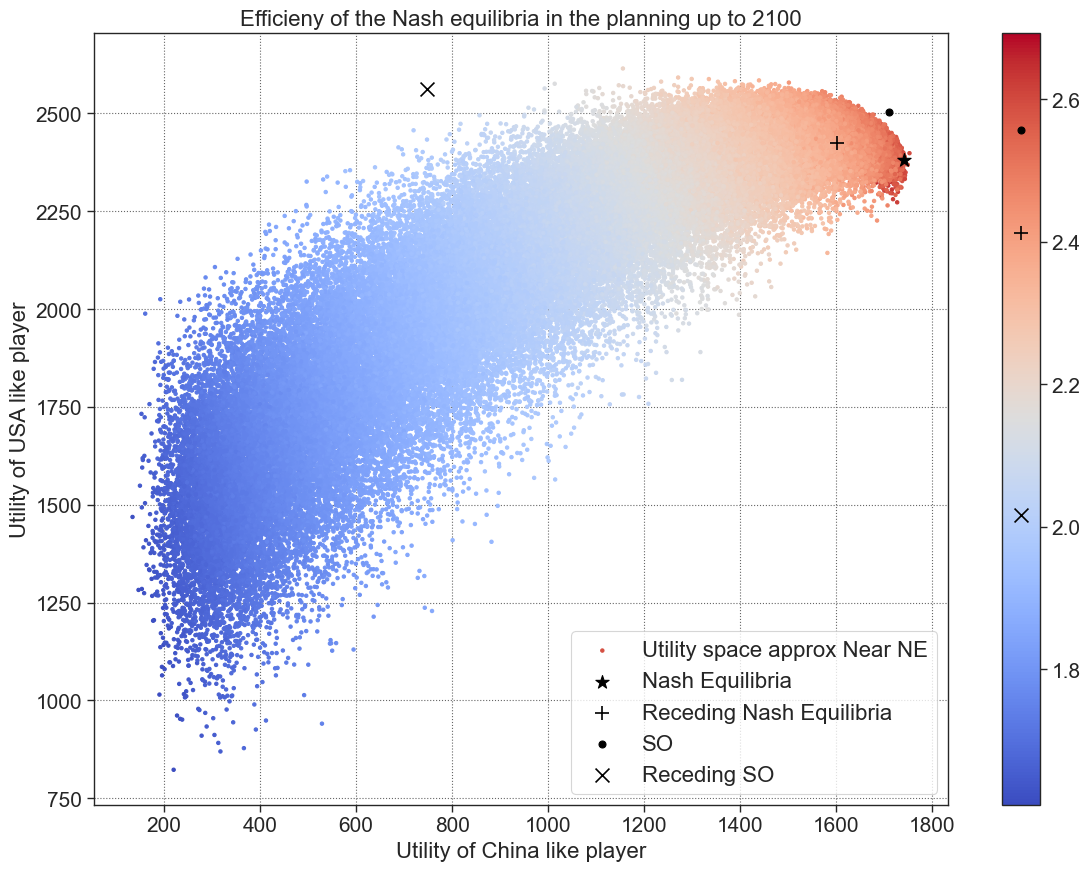

In [ ]:
fig = plt.figure(dpi = 100, figsize=(12,9))
ax = fig.gca()
p = ax.scatter(data_u[:,0], data_u[:,1], c=data_t[:,T-1],cmap='coolwarm', marker='.', label='Utility space approx Near NE')
cbar = fig.colorbar(p)

ax.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
ax.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
ax.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
ax.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
print(x_s)
ax.legend()

cbar.ax.scatter(x_s,temp_plan[16], marker='*', c='black', s=100, label='Nash Equilibria')
cbar.ax.scatter(x_s,temp_rece[16], marker='+', c='black',s=100, label='Receding Nash Equilibria')
cbar.ax.scatter(x_s,temp_plan_so[16], marker='.',c='black', s=100, label='SO')
cbar.ax.scatter(x_s,temp_rece_so[16], marker='x',c='black', s=100, label='Receding SO')

plt.xlabel('Utility of China like player')
plt.ylabel('Utility of USA like player')
plt.title('Efficieny of the Nash equilibria in the planning up to {}'.format(horizon))
plt.show()

In [31]:
np.save('sample', x)

NameError: name 'data_u' is not defined

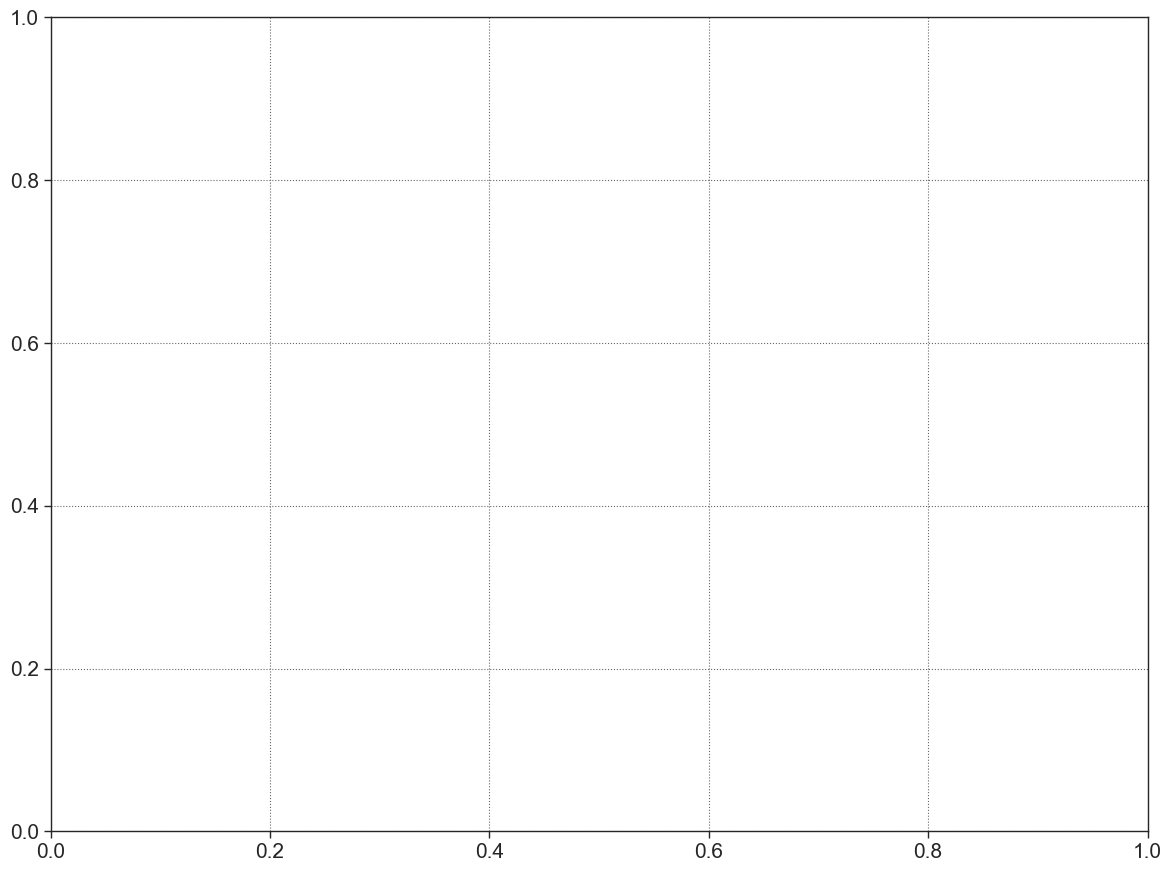

In [78]:
fig = plt.figure(dpi = 100, figsize=(12,9))
ax = fig.gca()
p = ax.scatter(data_u[:,0], data_u[:,1], c=data_t[:,T-1],cmap='coolwarm', marker='.', label='Utility space approx Near NE')
cbar = fig.colorbar(p)

p = ax.scatter(data_u[:,0], data_u[:,1], c=data_t[:,T-1],cmap='coolwarm', marker='.', label='Utility space approx Near NE')

ax.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
ax.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
ax.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
ax.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
print(x_s)
ax.legend()

cbar.ax.scatter(x_s,temp_plan[16], marker='*', c='black', s=100, label='Nash Equilibria')
cbar.ax.scatter(x_s,temp_rece[16], marker='+', c='black',s=100, label='Receding Nash Equilibria')
cbar.ax.scatter(x_s,temp_plan_so[16], marker='.',c='black', s=100, label='SO')
cbar.ax.scatter(x_s,temp_rece_so[16], marker='x',c='black', s=100, label='Receding SO')

plt.xlabel('Utility of China like player')
plt.ylabel('Utility of USA like player')
plt.title('Efficieny of the Nash equilibria in the planning up to {}'.format(horizon))
plt.show()
ax.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
ax.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
ax.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
ax.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
print(x_s)
ax.legend()

cbar.ax.scatter(x_s,temp_plan[16], marker='*', c='black', s=100, label='Nash Equilibria')
cbar.ax.scatter(x_s,temp_rece[16], marker='+', c='black',s=100, label='Receding Nash Equilibria')
cbar.ax.scatter(x_s,temp_plan_so[16], marker='.',c='black', s=100, label='SO')
cbar.ax.scatter(x_s,temp_rece_so[16], marker='x',c='black', s=100, label='Receding SO')

plt.xlabel('Utility of China like player')
plt.ylabel('Utility of USA like player')
plt.title('Efficieny of the Nash equilibria in the planning up to {}'.format(horizon))
plt.show()

C:\Users\Anthony Couthures\AppData\Local\Temp\ipykernel_30764\2719120300.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(p)


0.5


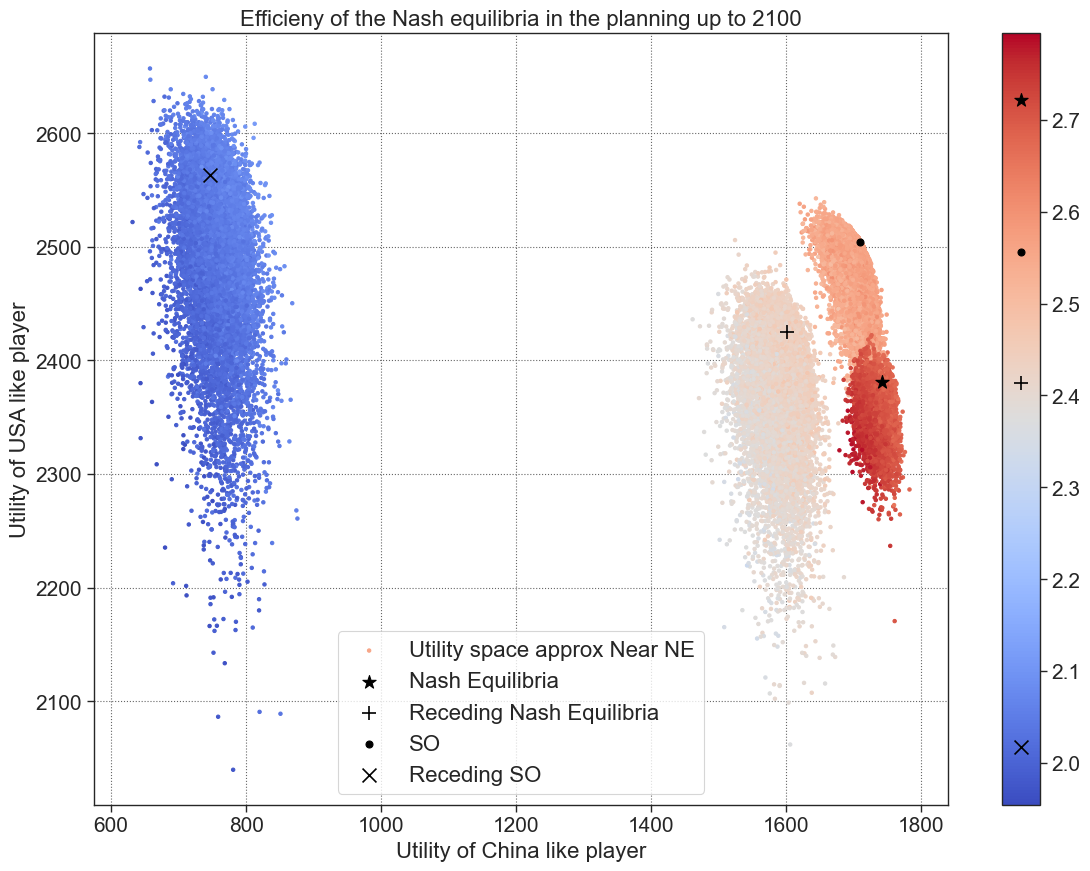

In [ ]:
fig = plt.figure(dpi = 100, figsize=(12,9))
ax = fig.gca()
p = ax.scatter(data_u[:,0], data_u[:,1], c=data_t[:,T-1],cmap='coolwarm', marker='.', label='Utility space approx Near NE')
cbar = fig.colorbar(p)

ax.scatter(u_p[0], u_p[1], marker='*', c='black', s=100, label='Nash Equilibria')
ax.scatter(u_r[0], u_r[1], marker='+', c='black',s=100, label='Receding Nash Equilibria')
ax.scatter(u_p_so[0], u_p_so[1], marker='.',c='black', s=100, label='SO')
ax.scatter(u_r_so[0], u_r_so[1], marker='x',c='black', s=100, label='Receding SO')
x_s = cbar.ax.set_xlim()
x_s = sum(x_s)/2
print(x_s)
ax.legend()

cbar.ax.scatter(x_s,temp_plan[16], marker='*', c='black', s=100, label='Nash Equilibria')
cbar.ax.scatter(x_s,temp_rece[16], marker='+', c='black',s=100, label='Receding Nash Equilibria')
cbar.ax.scatter(x_s,temp_plan_so[16], marker='.',c='black', s=100, label='SO')
cbar.ax.scatter(x_s,temp_rece_so[16], marker='x',c='black', s=100, label='Receding SO')

plt.xlabel('Utility of China like player')
plt.ylabel('Utility of USA like player')
plt.title('Efficieny of the Nash equilibria in the planning up to {}'.format(horizon))
plt.show()

In [ ]:
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)
list_product_strategy = [list(x) for x in product_strategy]
random_product = []
for k in tqdm(range(num_sample), desc='Sampling'):
    random_product.append(random.choices(list_product_strategy, k= T))
random_product = np.array(random_product)
list_product_strategy_profile = np.moveaxis(random_product, [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, SCM, list_players)

Sampling: 100%|██████████| 100000/100000 [00:00<00:00, 132667.95it/s]


(100000, 5, 17)


NameError: name 'list_players' is not defined

In [23]:
percentage = np.arange(k+1)/k


In [24]:
percentage

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [27]:
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]


In [35]:
T = 3
ACTION_SETS =  np.array([[[0.0, 11.47],        # China  
                         [0.0, 5.01],         # USA
                         [0.0, 3.14],         # EU
                         [0.0, 2.71],         # India
                         [0.0, 1.76],         # Russia
                         [0.0, 13.51]]]*T)*2       # other 

np.swapaxes(ACTION_SETS,0,1).shape

(6, 3, 2)

In [272]:
import numpy as np

# Given array
arr = np.array([[[0.0, 22.94],
                [0.0, 22.94],
                [0.0, 22.94]],

               [[0.0, 10.02],
                [0.0, 10.02],
                [0.0, 10.02]],

               [[0.0, 6.28],
                [0.0, 6.28],
                [0.0, 6.28]],

               [[0.0, 5.42],
                [0.0, 5.42],
                [0.0, 5.42]],

               [[0.0, 3.52],
                [0.0, 3.52],
                [0.0, 3.52]],

               [[0.0, 27.02],
                [0.0, 27.02],
                [0.0, 27.02]]])

# Get lower and upper bounds from the last axis of the array
lower_bounds = arr[..., 0]
upper_bounds = arr[..., 1]

# Generate random vectors within the specified bounds
random_vectors = np.random.uniform(lower_bounds, upper_bounds, size=(100, arr.shape[0], arr.shape[1]))

print(random_vectors)

[[[1.68103565e+01 3.99571457e+00 2.75766146e+00]
  [6.34231635e+00 4.32001538e+00 7.50354047e+00]
  [5.43880188e+00 1.86351713e-01 6.26592662e-01]
  [1.36700905e+00 3.58132542e+00 3.55461593e+00]
  [1.89888706e+00 2.28666625e+00 2.52186555e+00]
  [1.44363867e+01 2.09083842e+01 9.78922559e-01]]

 [[6.06270437e-01 1.47051668e+01 1.47932310e+00]
  [1.02780978e+00 2.98978319e+00 7.67028154e+00]
  [4.87863766e+00 3.20939863e+00 3.04314771e+00]
  [4.85038492e+00 5.64268230e-03 4.22933400e-01]
  [3.39064601e-01 1.57437884e+00 2.77505548e+00]
  [3.56283909e+00 8.34121734e+00 1.94257229e+01]]

 [[1.72694147e+01 1.56615230e+01 7.42442443e+00]
  [5.36328709e+00 8.28205064e+00 1.21051260e+00]
  [3.68554970e+00 2.22879884e+00 1.03592773e+00]
  [3.42787590e+00 2.31601837e+00 6.05402473e-01]
  [1.86279882e+00 1.03802553e-01 1.44348702e+00]
  [2.23602237e+01 4.03340319e+00 2.97755211e-01]]

 ...

 [[8.01290042e+00 1.80555352e+01 9.39768874e-01]
  [1.83791575e-01 6.05437672e+00 9.79010866e+00]
  [2.215

In [118]:
upper_bounds

array([[22.94, 22.94, 22.94],
       [10.02, 10.02, 10.02],
       [ 6.28,  6.28,  6.28],
       [ 5.42,  5.42,  5.42],
       [ 3.52,  3.52,  3.52],
       [27.02, 27.02, 27.02]])

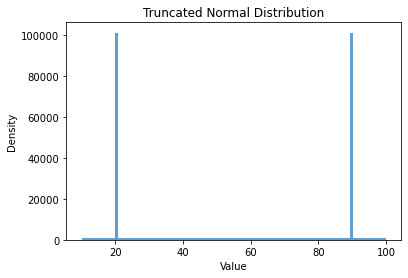

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import truncnorm, norm

# Set the boundaries and mean of the truncated normal distribution
a = 10  # Lower bound
b = 100  # Upper bound
mean =  2*a # (b-a) / 1000 # Mean close to the lower boundary
scale = 0
# Calculate the bounds for the standard normal distribution
lower_bound = (a - mean)   # Divide by standard deviation (1) to get z-score
upper_bound = (b - mean) 


# Generate a sample from the truncated normal distribution
size = 100000
samples = truncnorm.rvs(a, b, loc=mean, scale=scale, size=size, )
samples = np.concatenate((samples,a + b - truncnorm.rvs(a, b, loc=mean, scale=scale, size=size)), axis=0)
samples = np.concatenate((samples, a + (b-a) * stats.uniform.rvs(size=size)), axis=0)

# Plot the histogram of the samples
plt.hist(samples, bins=100,  alpha=0.7)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Truncated Normal Distribution')
plt.show()


In [181]:
import numpy as np

def invNormal(low : np.ndarray, high : np.ndarray, loc = None, scale=1, *, size=1, block_size=1024, random_state=None):
    remain = size
    result = []
    if not loc:
        loc = (high + low) / 2
    
    mul = -0.5 * scale**-2

    while remain:
        # draw next block of uniform variates within interval
        x = np.random.uniform(low, high, size=min((remain+5)*2, block_size))
        
        # reject proportional to normal density
        x = x[np.exp(mul*(x-loc)**2) < np.random.rand(*x.shape)]
        
        # make sure we don't add too much
        if remain < len(x):
            x = x[:remain]

        result.append(x)
        remain -= len(x)

    return np.concatenate(result)

In [182]:
from itertools import zip_longest
import numpy as np

def invNormal(low : np.ndarray, high : np.ndarray, loc = None, scale=1, *, size=1, block_size=1024, random_state=None):
    remain = size
    result = []
    if not loc:
        loc = (high + low) / 2
    
    mul = -0.5 * scale**-2

    while remain:
        # draw next block of uniform variates within interval
        x = np.random.uniform(low, high, size=min((remain+5)*2, block_size))
        
        # reject proportional to normal density
        x = x[np.exp(mul*(x-loc)**2) < np.random.rand(*x.shape)]
        
        # make sure we don't add too much
        if remain < len(x):
            x = x[:remain]

        result.append(x)
        remain -= len(x)

    return np.concatenate(result)

def _check_shape(argshape, size):
    """
    This is a utility function used by `_rvs()` in the class geninvgauss_gen.
    It compares the tuple argshape to the tuple size.

    Parameters
    ----------
    argshape : tuple of integers
        Shape of the arguments.
    size : tuple of integers or integer
        Size argument of rvs().

    Returns
    -------
    The function returns two tuples, scalar_shape and bc.

    scalar_shape : tuple
        Shape to which the 1-d array of random variates returned by
        _rvs_scalar() is converted when it is copied into the
        output array of _rvs().

    bc : tuple of booleans
        bc is an tuple the same length as size. bc[j] is True if the data
        associated with that index is generated in one call of _rvs_scalar().

    """
    scalar_shape = []
    bc = []
    for argdim, sizedim in zip_longest(argshape[::-1], size[::-1],
                                       fillvalue=1):
        if sizedim > argdim or (argdim == sizedim == 1):
            scalar_shape.append(sizedim)
            bc.append(True)
        else:
            bc.append(False)
    return tuple(scalar_shape[::-1]), tuple(bc[::-1])

def invNormal_rvs(a, b, loc = None, scale = 1, size=None, random_state=None):
    # if a and b are scalar, use _rvs_scalar, otherwise need to create
    # output by iterating over parameters
    if np.isscalar(a) and np.isscalar(b):
        out = invNormal(a, b, size, random_state=random_state)
    elif a.size == 1 and b.size == 1:
        out = invNormal(a.item(), b.item(), size,
                                random_state=random_state)
    else:
        # When this method is called, size will be a (possibly empty)
        # tuple of integers.  It will not be None; if `size=None` is passed
        # to `rvs()`, size will be the empty tuple ().

        a, b = np.broadcast_arrays(a, b)
        # a and b now have the same shape.

        # `shp` is the shape of the blocks of random variates that are
        # generated for each combination of parameters associated with
        # broadcasting a and b.
        # bc is a tuple the same length as size.  The values
        # in bc are bools.  If bc[j] is True, it means that
        # entire axis is filled in for a given combination of the
        # broadcast arguments.
        shp, bc = _check_shape(a.shape, size)

        # `numsamples` is the total number of variates to be generated
        # for each combination of the input arguments.
        numsamples = int(np.prod(shp))

        # `out` is the array to be returned.  It is filled in in the
        # loop below.
        out = np.empty(size)

        it = np.nditer([a, b],
                        flags=['multi_index'],
                        op_flags=[['readonly'], ['readonly']])
        while not it.finished:
            # Convert the iterator's multi_index into an index into the
            # `out` array where the call to _rvs_scalar() will be stored.
            # Where bc is True, we use a full slice; otherwise we use the
            # index value from it.multi_index.  len(it.multi_index) might
            # be less than len(bc), and in that case we want to align these
            # two sequences to the right, so the loop variable j runs from
            # -len(size) to 0.  This doesn't cause an IndexError, as
            # bc[j] will be True in those cases where it.multi_index[j]
            # would cause an IndexError.
            idx = tuple((it.multi_index[j] if not bc[j] else slice(None))
                        for j in range(-len(size), 0))
            out[idx] =  invNormal(it[0], it[1], loc=loc, scale=scale, size=numsamples,
                                        random_state = random_state).reshape(shp)
            it.iternext()

    if size == ():
        out = out.item()
    return out

In [183]:
def invNormal_rvs(a, b, loc = None, scale = 1, size=None, random_state=None):
    # if a and b are scalar, use _rvs_scalar, otherwise need to create
    # output by iterating over parameters
    if np.isscalar(a) and np.isscalar(b):
        out = invNormal(a, b, size, random_state=random_state)
    elif a.size == 1 and b.size == 1:
        out = invNormal(a.item(), b.item(), size,
                                random_state=random_state)
    else:
        # When this method is called, size will be a (possibly empty)
        # tuple of integers.  It will not be None; if `size=None` is passed
        # to `rvs()`, size will be the empty tuple ().

        a, b = np.broadcast_arrays(a, b)
        # a and b now have the same shape.

        # `shp` is the shape of the blocks of random variates that are
        # generated for each combination of parameters associated with
        # broadcasting a and b.
        # bc is a tuple the same length as size.  The values
        # in bc are bools.  If bc[j] is True, it means that
        # entire axis is filled in for a given combination of the
        # broadcast arguments.
        shp, bc = _check_shape(a.shape, size)

        # `numsamples` is the total number of variates to be generated
        # for each combination of the input arguments.
        numsamples = int(np.prod(shp))

        # `out` is the array to be returned.  It is filled in in the
        # loop below.
        out = np.empty(size)

        it = np.nditer([a, b],
                        flags=['multi_index'],
                        op_flags=[['readonly'], ['readonly']])
        while not it.finished:
            # Convert the iterator's multi_index into an index into the
            # `out` array where the call to _rvs_scalar() will be stored.
            # Where bc is True, we use a full slice; otherwise we use the
            # index value from it.multi_index.  len(it.multi_index) might
            # be less than len(bc), and in that case we want to align these
            # two sequences to the right, so the loop variable j runs from
            # -len(size) to 0.  This doesn't cause an IndexError, as
            # bc[j] will be True in those cases where it.multi_index[j]
            # would cause an IndexError.
            idx = tuple((it.multi_index[j] if not bc[j] else slice(None))
                        for j in range(-len(size), 0))
            out[idx] =  invNormal(it[0], it[1], loc=loc, scale=scale, size=numsamples,
                                        random_state = random_state).reshape(shp)
            it.iternext()

    if size == ():
        out = out.item()
    return out

In [187]:
random_vector[:,4,:].shape

(100000, 3)

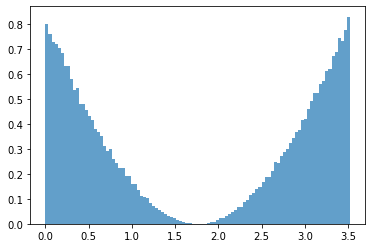

In [185]:
random_vector = invNormal_rvs(lower_bounds, upper_bounds, scale= 3, size=(100000, arr.shape[0], arr.shape[1]))
ax, fig = plt.figure()
plt.hist(random_vector[:,4,0], bins=100,  alpha=0.7, density=True)
plt.show()

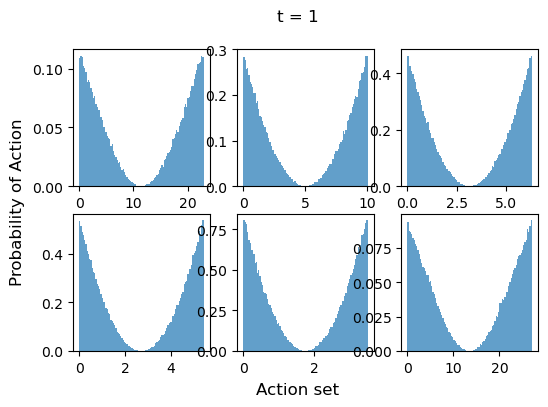

In [193]:
n_row = 2
n_col = 3
random_vector = invNormal_rvs(lower_bounds, upper_bounds, scale= 10, size=(100000, arr.shape[0], arr.shape[1]))

plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=(12,9))
t = 0
k = 0
for row in range(n_row):
    for col in range(n_col):
        axes[row, col].hist(random_vector[:,k,t], bins=100,  alpha=0.7, density=True)
        k += 1
fig.supylabel('Probability of Action')
fig.supxlabel('Action set')

fig.suptitle('For t = {}'.format(t +1))

plt.show()


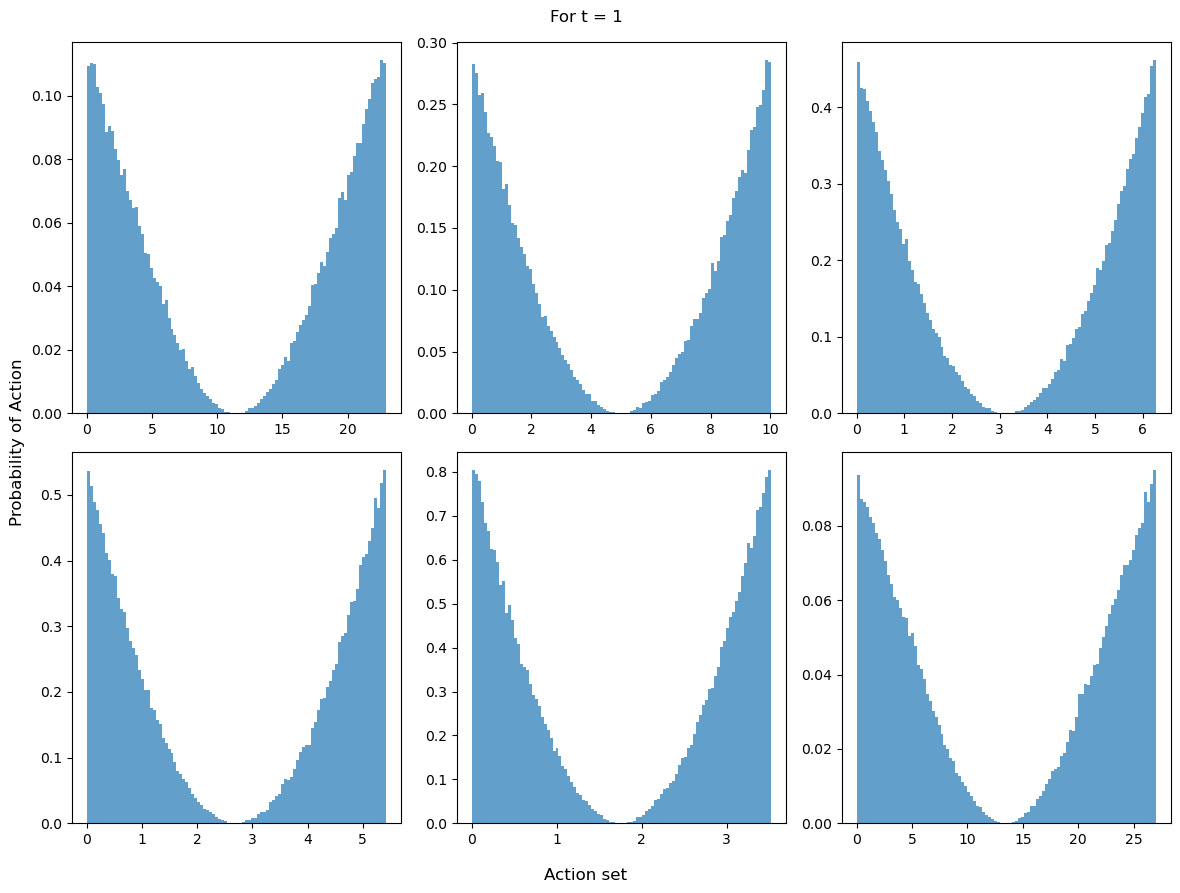

In [197]:
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(n_row, n_col, dpi = 100, figsize=(12,9))
t = 0
k = 0
for row in range(n_row):
    for col in range(n_col):
        axes[row, col].hist(random_vector[:,k,t], bins=100,  alpha=0.7, density=True)
        k += 1
fig.supylabel('Probability of Action')
fig.supxlabel('Action set')

fig.suptitle('For t = {}'.format(t +1))

plt.show()

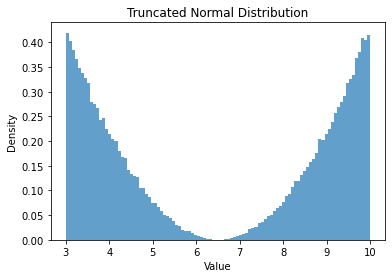

In [112]:

plt.hist(invNormal(3, 10,  sd=30, size=100_000), bins=100,  alpha=0.7, density=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Truncated Normal Distribution')
plt.show()

In [113]:
arr = np.array([[[0.0, 22.94],
                [0.0, 22.94],
                [0.0, 22.94]],

               [[0.0, 10.02],
                [0.0, 10.02],
                [0.0, 10.02]],

               [[0.0, 6.28],
                [0.0, 6.28],
                [0.0, 6.28]],

               [[0.0, 5.42],
                [0.0, 5.42],
                [0.0, 5.42]],

               [[0.0, 3.52],
                [0.0, 3.52],
                [0.0, 3.52]],

               [[0.0, 27.02],
                [0.0, 27.02],
                [0.0, 27.02]]])

# Get lower and upper bounds from the last axis of the array
lower_bounds = arr[..., 0]
upper_bounds = arr[..., 1]

In [26]:
ACTION_SETS.shape

(6, 34, 2)

In [19]:
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)
list_product_strategy = [list(x) for x in product_strategy]
random_product = []
for k in tqdm(range(num_sample), desc='Sampling'):
    random_product.append(random.choices(list_product_strategy, k= T))
random_product = np.array(random_product)
list_product_strategy_profile = np.moveaxis(random_product, [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, SCM, list_players)

Sampling: 100%|██████████| 100000/100000 [00:00<00:00, 132667.95it/s]


(100000, 5, 17)


NameError: name 'list_players' is not defined

In [ ]:
def process(list_product_strategy_profile, game : Game) : 
    data_utilities = []
    data_actions_profiles = []
    for strategy in tqdm(list_product_strategy_profile, 'Processing'):
        data_utilities.append(game.game_with_strategies_profile(strategy))
        data_utilities.append(game.strat_utilities_profiles)
        data_actions_profiles.append(game.strat_action_profiles)
    return data_utilities, data_actions_profiles

In [2]:
indice_1 = 0
indice_2 = 1

In [3]:
def process(list_product_strategy_profile, smc, list_players) : 
    data_utilities = []
    data_actions_profiles = []
    for strategy in tqdm(list_product_strategy_profile, 'Processing'):
        game = Game(deepcopy(smc), list_players)
        game.repeated_one_shot_game_with_strategies_profile(strategy)
        data_utilities.append(game.strat_utilities_profiles)
        data_actions_profiles.append(game.strat_action_profiles)
    return data_utilities, data_actions_profiles

def process_one_shot(list_product_strategy_profile, product_strategy_sum, smc, list_players) : 
    data_utilities = []
    for idx in tqdm(range(len(product_strategy_sum)), 'Processing'):
        strategy = list_product_strategy_profile[idx]
        strat_sum = product_strategy_sum[idx]
        game = Game(deepcopy(smc), list_players)
        utilities = game.one_shot_game_with_strategies_profile(strategy,strat_sum, smc)
        data_utilities.append(utilities)
    return data_utilities

def process_following(following, smc, list_players) : 
    data_follow_utilities = []
    data_follow_actions = []
    for time in range(T):
        data_utilities = []
        data_actions_profiles = []
        list_product_strategy_profile = following[time]
        for strategy in tqdm(list_product_strategy_profile, 'Processing'):
            game = Game(deepcopy(smc), list_players)
            game.repeated_one_shot_game_with_strategies_profile(strategy)
            data_utilities.append(game.strat_utilities_profiles)
            data_actions_profiles.append(game.strat_action_profiles)
        data_follow_utilities.append(data_utilities)
        data_follow_actions.append(data_actions_profiles)
    return data_follow_utilities, data_follow_actions



In [4]:
def pareto_domine(NE_utilities, strat_utilities):
    for i in range(len(NE_utilities)) :
        if NE_utilities[i] > strat_utilities[i] :
            return False
    return True

delta_step = 5

def pareto_domine_uptill_time(profile_NE_utilities, profile_strat_utilities, time):
    for t in range(time):
        if not pareto_domine(profile_NE_utilities[:,t], profile_strat_utilities[:,t]):
            return False
    return True 

def pareto_domine_over_delta(NE_utilities, strat_utilities, delta):
    for i in range(len(NE_utilities)) :
        tsup = min(i + delta, len(NE_utilities))
        if np.sum(NE_utilities[i:tsup]) > np.sum(strat_utilities[i:tsup]) :
            return False
    return True

def pareto_domine_over_time(profile_NE_utilities, profile_strat_utilities):
    n,tmax = np.shape(profile_NE_utilities)
    for time in range(tmax):
        if not pareto_domine(profile_NE_utilities[:,time], profile_strat_utilities[:,time]):
            return False
    return True 

def pareto_domine_sum_utility(NE_utilities, strat_utilities):
    for i in range(len(NE_utilities)) :
        if NE_utilities[i] > strat_utilities[i] :
            return False
    return True

In [5]:
def sort_data(data_u, data_a, utilities_NE) :
    pareto_strict_u = []
    pareto_strict_a = []
    pareto_sum_u = []
    pareto_sum_a = []

    for idx in range(len(data_u)):
        profile_u = data_u[idx]
        profile_a = data_a[idx]
        if pareto_domine_over_time(utilities_NE, profile_u):
            pareto_strict_u.append(profile_u)
            pareto_strict_a.append(profile_a)

        if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_u,axis=1)):
            pareto_sum_u.append(profile_u)
            pareto_sum_a.append(profile_a)

    pareto_up_u = []
    pareto_up_a = []
    for time in range(T):
        pareto_up_time_u = []
        pareto_up_time_a = []
        for idx in range(len(data_u)):
            profile_u = data_u[idx]
            profile_a = data_u[idx]

            if pareto_domine_uptill_time(utilities_NE, profile_u, time+1):
                pareto_up_time_u.append(profile_u)
                pareto_up_time_a.append(profile_a)

        pareto_up_u.append(pareto_up_time_u)
        pareto_up_a.append(pareto_up_time_a)

    print('Num strat Pareto every step :', len(pareto_strict_u))
    print('Num strat Pareto in sum :', len(pareto_sum_u))

    return pareto_strict_u, pareto_strict_a, pareto_sum_u, pareto_sum_a


def sort_follow(following_u, following_a, utilities_NE):
    pareto_at_u = []
    pareto_at_a = []
    pareto_delta_u = []
    pareto_delta_a = []
    pareto_sum_u = []
    pareto_sum_a = []
    for time in range(T):

        data_u = following_u[time]
        data_a = following_a[time]

        pareto_at_time_u = []
        pareto_at_time_a = []
        pareto_delta_time_u = []
        pareto_delta_time_a = []
        pareto_sum_time_u = []
        pareto_sum_time_a = []

        for idx in range(len(data_u)):
            profile_u = data_u[idx]
            profile_a = data_a[idx]
            if pareto_domine(utilities_NE[:,time], profile_u[:,time]):
                pareto_at_time_u.append(profile_u)
                pareto_at_time_a.append(profile_a)

            if pareto_domine_over_delta(utilities_NE, profile_u, delta=delta_step):
                pareto_delta_time_u.append(profile_u)
                pareto_delta_time_a.append(profile_a)

            if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_u,axis=1)):
                pareto_sum_time_u.append(profile_u)
                pareto_sum_time_a.append(profile_a)

        pareto_at_u.append(pareto_at_time_u)
        pareto_at_a.append(pareto_at_time_a)
        pareto_delta_u.append(pareto_delta_time_u)
        pareto_delta_a.append(pareto_delta_time_a)
        pareto_sum_u.append(pareto_sum_time_u)
        pareto_sum_a.append(pareto_sum_time_a)

    return pareto_at_u, pareto_at_a, pareto_delta_u, pareto_delta_a, pareto_sum_u, pareto_sum_a 


def sort_one_shot(strat_u, strat_a, list_utilities_NE):
    pareto_at_u = []
    pareto_at_a = []

    for idx in range(len(strat_u)):

        data_u = strat_u[idx]
        data_a = strat_a[idx]
        utilities_NE = list_utilities_NE[idx]

        pareto_at_time_u = []
        pareto_at_time_a = []

        for idx_ in range(len(data_u)):
            profile_u = data_u[idx_]
            profile_a = data_a[idx_]
            if pareto_domine(utilities_NE, profile_u):
                pareto_at_time_u.append(profile_u)
                pareto_at_time_a.append(profile_a)

        pareto_at_u.append(pareto_at_time_u)
        pareto_at_a.append(pareto_at_time_a)


    return pareto_at_u, pareto_at_a

In [6]:
from matplotlib import hatch




def fill_convex_hull(p_1, p_2, color, label):
    points = np.array([p_1,p_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=color, lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=color,  alpha=0.3, label=label)

def hatch_convex_hull(p_1, p_2, color, label, hatch ='/'):
    points = np.array([p_1,p_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=color, lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], color="none", hatch=hatch ,edgecolor=color, alpha=0.3, label=label)

def plot_utilities_merged_temp(data_utilities, list_temp, list_pareto, list_utilities_NE):
    plt.figure(figsize=(8,8),dpi=120)
    k = len(list_temp)
    colors = sns.color_palette("rocket",k)
    c = 0
    for idx in range(0,k):
        feasible_u = data_utilities[idx]
        utilities_NE = list_utilities_NE[idx]
        temp = list_temp[idx]
        pareto = list_pareto[idx]
        p_1 = [profile[indice_1] for profile in feasible_u]
        p_2 = [profile[indice_2] for profile in feasible_u]
        fill_convex_hull(p_1, p_2, colors[c], 'Feasible utilities at temp {}'.format(temp))
        plt.scatter(utilities_NE[indice_1], utilities_NE[indice_2], color=colors[c], zorder=10, label ='NE at temp {}'.format(temp), marker='X',s=90, edgecolor='black')

        try :
            p_1 = [profile[indice_1] for profile in pareto]
            p_2 = [profile[indice_2] for profile in pareto]
            plt.scatter(p_1,p_2,c='black',marker='*', alpha=0.9)

            hatch_convex_hull(p_1, p_2, 'black', 'Convex hull of pareto utilities at temp {}'.format(temp))
        except:
            pass
        # plt.scatter(p_1,p_2, alpha=0.4)
        c += 1


    plt.xlabel('Utility player {}'.format(indice_1+1))
    plt.ylabel('Utility player {}'.format(indice_2+1))
    plt.legend()
    plt.title('Evolution of utility space  for player {} and {} with respect to temperature'.format( indice_1+1, indice_2+1))
    plt.show()

def plot_utilities_merged(feasible_u, utilities_NE):
    plt.figure(figsize=(8,8),dpi=120)
    colors = sns.color_palette("rocket",T//2+1)
    c = 0
    for time in range(0,T, 2):
        p_1 = [profile[indice_1,time] for profile in feasible_u]
        p_2 = [profile[indice_2,time] for profile in feasible_u]
        fill_convex_hull(p_1, p_2, colors[c], 'Feasible utilities at time {}'.format(time * 5 +2020))
        plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], zorder=10, label ='NE at time {}'.format(time *5 + 2020), marker='X',s=90, edgecolor='black')

        # plt.scatter(p_1,p_2, alpha=0.4)
        c += 1


    plt.xlabel('Utility player {}'.format(indice_1+1))
    plt.ylabel('Utility player {}'.format(indice_2+1))
    plt.legend()
    plt.title('Evolution of utility space for strategy over {} to {} for player {} and {}'.format(FIRST_YEAR, FINAL_YEAR, indice_1+1, indice_2+1))
    plt.show()

def plot_utilities_space(following, utilities_NE, pareto_delta_u, pareto_dominant_sum_utilities, pareto_dominant_strict_utilities, pareto_dominant_at) :
    colors = sns.color_palette("tab10")
    for time in range(0,T, 2):
        plt.figure(figsize=(6,6),dpi=120)

        ## Feasible set 
        try :
            p_1 = [profile[indice_1,time] for profile in following[time]]
            p_2 = [profile[indice_2,time] for profile in following[time]]
            # plt.scatter(p_1,p_2,c='b', alpha=0.9)

            fill_convex_hull(p_1, p_2, 'b', 'Convex hull of feasible utilities')
        except:
            pass
        
        ## Sum optimal
        try :        
            p_1 = [profile[indice_1,time] for profile in pareto_dominant_sum_utilities[time]]
            p_2 = [profile[indice_2,time] for profile in pareto_dominant_sum_utilities[time]]

            fill_convex_hull(p_1, p_2, 'brown', 'Convex hull sum utilities btw {} and {} dominant'.format(FIRST_YEAR, FINAL_YEAR))
            # plt.scatter(p_1,p_2,c='brown', alpha=0.9)
        except:
            pass

        ## Delta_optimal 
        try :
            p_1 = [profile[indice_1,time] for profile in pareto_delta_u[time]]
            p_2 = [profile[indice_2,time] for profile in pareto_delta_u[time]]

            fill_convex_hull(p_1, p_2, 'orange', 'Convex hull utilities sum over {} years dominant'.format(delta_step*5 ))
            # plt.scatter(p_1,p_2,c='orange', alpha=0.9)
        except:
            pass      

        try :
            p_1 = [profile[indice_1,time] for profile in pareto_dominant_strict_utilities]
            p_2 = [profile[indice_2,time] for profile in pareto_dominant_strict_utilities]
            fill_convex_hull(p_1, p_2, 'yellow', 'Convex hull utilities dominant at every time')
            # plt.scatter(p_1,p_2,c='yellow', alpha=0.9)
        except:
            pass

        try :
            p_1 = [profile[indice_1,time] for profile in pareto_dominant_at[time]]
            p_2 = [profile[indice_2,time] for profile in pareto_dominant_at[time]]
            hatch_convex_hull(p_1, p_2, 'black', 'Pareto dominant utilities', hatch= '/' )
            plt.scatter(p_1,p_2,c='black', marker='*', s=10, alpha=0.9)
        except:
            pass
        
        plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='+',s=10,c='black', edgecolor='black')
        plt.xlabel('Utility player {}'.format(indice_1+1))
        plt.ylabel('Utility player {}'.format(indice_2+1)) 
        plt.title('Utilities of player {} and {} at {}'.format(indice_1+1, indice_2+1, 2020 + time *5))
        plt.legend()
        plt.show()



# Changement de l'état

In [ ]:
list_players = create_players(alpha=1, list_benefit_functions=list_list_benefit_functions[0], damage_function=damage_polynome(list_damage_coef[0]), discount=1)

game = Game(list_players, horizon=horizon, temperature_target= temperature_target, final_multiplier=final_multiplier)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.1)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.1)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_strict_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_strict_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


In [ ]:


plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)

    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90, edgecolor='black')
plt.legend()
plt.show()


## Benefit fixed Convexe

In [ ]:
list_benef_function = [benefit_quadratic_convex_with_percentage_green(gdp_max[i], action_sets[i,1], percentage_green=0.3) for i in range(N)]

In [ ]:
list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = benefit_quadratic_concave_with_percentage_green(gdp_max[i], action_sets[i][1], percentage_green=0.2),
                                damage_function = damage_function,
                                impact_factor_of_temperature = deltas[i],
                                alpha=alpha) for i in range(N)]

game = Game(deepcopy(smc), list_players)
game.repeated_one_shot_game()
utilities_NE = game.utilities_profiles
actions_NE = game.action_profiles

## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 5, 10])/10
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.9)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.9)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 2, 4, 6, 8, 10])/10

tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.9)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.9)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 1, 2, 3,  4, 5,  6, 7,  8, 9, 10])/10
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.1)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.1)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_strict_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_strict_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


# Action randomized

In [ ]:
k = 10
num_sample = 100000

In [ ]:
percentage

In [ ]:
percentage = np.arange(k+1)/k
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)
list_product_strategy = [list(x) for x in product_strategy]
random_product = []
for k in tqdm(range(num_sample), desc='Sampling'):
    random_product.append(random.choices(list_product_strategy, k= T))
random_product = np.array(random_product)
list_product_strategy_profile = np.moveaxis(random_product, [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.1)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.1)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_strict_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_strict_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Benefit fixed Sigmoid

In [ ]:
list_benef_function = [benefice_sigm(gdp_max[i], action_sets[i,1], power=10) for i in range(N)]

In [ ]:
list_players = [player_class(name = 'player {}'.format(i), action_set = action_sets[i], smc = deepcopy(smc),
                                benefit_function = benefit_quadratic_concave_with_percentage_green(gdp_max[i], action_sets[i][1], percentage_green=0.2),
                                damage_function = damage_function,
                                impact_factor_of_temperature = deltas[i],
                                alpha=alpha) for i in range(N)]

game = Game(deepcopy(smc), list_players)
game.repeated_one_shot_game()
utilities_NE = game.utilities_profiles
actions_NE = game.action_profiles

## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 5, 10])/10
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.9)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.9)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 2, 4, 6, 8, 10])/10

tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.9)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.9)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.9)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


## Discretisation en 0\%, 50\% et 100\%

In [ ]:
percentage = np.array([0, 1, 2, 3,  4, 5,  6, 7,  8, 9, 10])/10
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)

list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.1)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.1)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_strict_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_strict_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


# Action randomized

In [ ]:
k = 10
num_sample = 100000

In [ ]:
percentage

In [ ]:
percentage = np.arange(k+1)/k
tuple_percentage = [percentage * ub for ub in action_sets[:,1]]
product_strategy = product(*tuple_percentage)
list_product_strategy = [list(x) for x in product_strategy]
random_product = []
for k in tqdm(range(num_sample), desc='Sampling'):
    random_product.append(random.choices(list_product_strategy, k= T))
random_product = np.array(random_product)
list_product_strategy_profile = np.moveaxis(random_product, [0,1,2], [0,2,1])
print(list_product_strategy_profile.shape)
data_utilities, data_actions_profiles = process(list_product_strategy_profile, smc, list_players)

In [ ]:
plt.figure(figsize=(8,8),dpi=120)
colors = sns.color_palette("rocket",T//4+1)
c = 0
for time in range(0,T, 4):
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c=colors[c], lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], c=colors[c] , alpha=0.3)

    # plt.scatter(scatter_indice_1,scatter_indice_2, alpha=0.4)
    c += 1

plt.gca().set_prop_cycle(None)
c = 0

for time in range(0,T, 4):

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], color=colors[c], label ='NE', marker='X',s=90, edgecolor='black')
    c += 1

plt.legend()
plt.show()

In [ ]:
pareto_domiant_strict_utilities = []
pareto_domiant_delta_utilities = []
pareto_domiant_sum_utilities = []

pareto_domiant_strict_actions_profiles = []
pareto_domiant_delta_actions_profiles = []
pareto_domiant_sum_actions_profiles = []


for idx in range(len(data_utilities)):
    profile_strat_utilities = data_utilities[idx]
    if pareto_domine_over_time(utilities_NE, profile_strat_utilities):
        pareto_domiant_strict_utilities.append(profile_strat_utilities)
        pareto_domiant_strict_actions_profiles.append(data_actions_profiles[idx])

    if pareto_domine_over_delta(utilities_NE, profile_strat_utilities, delta=delta_step):
        pareto_domiant_delta_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])
    if pareto_domine_sum_utility(np.sum(utilities_NE,axis=1), np.sum(profile_strat_utilities,axis=1)):
        pareto_domiant_sum_utilities.append(profile_strat_utilities)
        pareto_domiant_delta_actions_profiles.append(data_actions_profiles[idx])

print('Num strat Pareto every step :', len(pareto_domiant_strict_utilities))
print('Num strat Pareto over {} steps :'.format(delta_step), len(pareto_domiant_delta_utilities))
print('Num strat Pareto in sum :', len(pareto_domiant_sum_utilities))

In [ ]:


colors = sns.color_palette("tab10")
for time in range(0,T, 4):
    plt.figure(figsize=(6,6),dpi=120)
    scatter_indice_1 = [profile[indice_1,time] for profile in data_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in data_utilities]
    plt.scatter(scatter_indice_1,scatter_indice_2,c='b', alpha=0.1)

    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='b', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'b', alpha=0.3,label ='convex hull utilities')


    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_delta_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_delta_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='orange', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'orange', alpha=0.3,label ='convex hull sum over {} step dominant'.format(delta_step))
    plt.scatter(scatter_indice_1,scatter_indice_2,c='orange', alpha=0.1)
    
    scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_sum_utilities]
    scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_sum_utilities]
    points = np.array([scatter_indice_1,scatter_indice_2]).T
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
    plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
    plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
    c += 1

    try :
        scatter_indice_1 = [profile[indice_1,time] for profile in pareto_domiant_strict_utilities]
        scatter_indice_2 = [profile[indice_2,time] for profile in pareto_domiant_strict_utilities]
        points = np.array([scatter_indice_1,scatter_indice_2]).T
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            plt.plot(points[simplex, 0], points[simplex, 1],'--', c='brown', lw = .7)
        plt.fill(points[hull.vertices,0], points[hull.vertices,1], 'brown', alpha=0.3,label ='convex hull sum dominant')
        plt.scatter(scatter_indice_1,scatter_indice_2,c='brown', alpha=0.1)
        c += 1
    except:
        pass

    plt.scatter(utilities_NE[indice_1,time], utilities_NE[indice_2,time], label ='NE', marker='X',s=90,c='black', edgecolor='black')
    plt.legend()
    plt.show()


In [ ]:
percentage = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])/10
# percentage = np.array([0, 2, 4, 6, 8, 10])/10
# percentage = np.array([0.0, 2.5, 5.0, 7.5, 10.0])/10

# percentage = np.array([0, 5, 10])/10

num_sample = 100000

# list_strategy = [dummy_one_shot_strat(percent) for percent in percentage]

tuple_percentage = [percentage * ub for ub in action_sets[:,1]]

product_strategy = product(*tuple_percentage)
list_product_strategy = [list(x) for x in product_strategy]

random_product = []
for k in tqdm(range(num_sample)):
    random_product.append(random.choices(list_product_strategy, k= T))

random_product = np.array(random_product)
list_product_strategy_profile = np.moveaxis(random_product, [0,1,2], [0,2,1])

# list_product_strategy = np.array([list(x) for x in product_strategy], ndmin=3)
# list_product_strategy_profile = np.moveaxis(np.moveaxis(np.repeat(list_product_strategy, repeats=T, axis=0), [0,1,2],[1,0,2]), [0,1,2], [0,2,1])